In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00


In [2]:
# Cell-1 Environment setup and seeds

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader as GeometricDataLoader
from torch_geometric.utils import add_self_loops, degree

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Global constants
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 64
BATCH_SIZE_TEST = 64
LEARNING_RATE = 0.001
EPOCHS = 100
PATIENCE = 15

# Data paths
PATHS = {
    'netflix': '/content/drive/MyDrive/Netflix_1.csv',
    'zoom1': '/content/drive/MyDrive/Zoom_1.csv',
    'zoom2': '/content/drive/MyDrive/Zoom_2.csv',
    'zoom3': '/content/drive/MyDrive/Zoom_3.csv'
}

print("Environment setup complete")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

Using device: cpu
Environment setup complete
PyTorch version: 2.8.0+cu126
PyTorch Geometric version: 2.6.1


In [3]:
# Cell-2 Data paths and availability


import os

# Check file existence and basic info
data_info = {}

for name, path in PATHS.items():
    if os.path.exists(path):
        # Get file size
        size_mb = os.path.getsize(path) / (1024 * 1024)

        # Load and preview
        df = pd.read_csv(path, nrows=1000)  # Preview first 1000 rows

        data_info[name] = {
            'path': path,
            'exists': True,
            'size_mb': round(size_mb, 2),
            'preview_rows': len(df),
            'columns': list(df.columns),
            'shape_preview': df.shape
        }

        print(f"\n{name.upper()} Dataset:")
        print(f"  Size: {size_mb:.2f} MB")
        print(f"  Columns: {df.columns.tolist()}")
        print(f"  Preview shape: {df.shape}")
        print(f"  First few rows:")
        print(df.head(3))

    else:
        data_info[name] = {
            'path': path,
            'exists': False,
            'error': 'File not found'
        }
        print(f"\nERROR: {name} file not found at {path}")

print(f"\nData availability summary:")
available_files = sum(1 for info in data_info.values() if info['exists'])
print(f"Available files: {available_files}/{len(PATHS)}")


NETFLIX Dataset:
  Size: 704.59 MB
  Columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']
  Preview shape: (1000, 7)
  First few rows:
   No.                        Time        Source   Destination Protocol  \
0    3  2022-06-17 23:48:34.871426     192.0.0.2  10.215.173.2      TCP   
1    6  2022-06-17 23:48:34.953834  10.215.173.1    45.57.41.1      TCP   
2    7  2022-06-17 23:48:35.035546    45.57.41.1  10.215.173.1      TCP   

   Length                                               Info  
0      60  43968  >  853 [SYN] Seq=0 Win=65535 Len=0 MSS=...  
1      60  33420  >  443 [SYN] Seq=0 Win=65535 Len=0 MSS=...  
2      48  443  >  33420 [SYN, ACK] Seq=0 Ack=1 Win=1024 ...  

ZOOM1 Dataset:
  Size: 628.04 MB
  Columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']
  Preview shape: (1000, 7)
  First few rows:
   No.                        Time     Source    Destination Protocol  Length  \
0    2  2022-05-30 16:01:36.328035  192.0.

In [4]:
# Cell-3 Schema inference and validation

def analyze_dataset_schema(df, dataset_name):
    """Analyze dataset schema and infer column meanings"""
    print(f"\n=== {dataset_name.upper()} SCHEMA ANALYSIS ===")

    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Data types:\n{df.dtypes}")

    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:\n{missing[missing > 0]}")
    else:
        print("\nNo missing values found")

    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")

    # Infer column purposes
    cols = df.columns.str.lower()

    # Time column detection
    time_cols = [col for col in df.columns if any(term in col.lower() for term in ['time', 'timestamp', 'ts', 'datetime'])]

    # Node column detection
    node_cols = [col for col in df.columns if any(term in col.lower() for term in ['src', 'dst', 'source', 'dest', 'from', 'to', 'node']) and col.lower() != 'protocol']

    # Traffic/size columns
    traffic_cols = [col for col in df.columns if any(term in col.lower() for term in ['len', 'length', 'size', 'bytes', 'packet', 'volume'])]

    # Label columns
    label_cols = [col for col in df.columns if any(term in col.lower() for term in ['label', 'class', 'target', 'bottleneck'])]

    print(f"\nInferred column purposes:")
    print(f"  Time columns: {time_cols}")
    print(f"  Node columns: {node_cols}")
    print(f"  Traffic columns: {traffic_cols}")
    print(f"  Label columns: {label_cols}")

    # Unique values for categorical columns
    for col in df.columns:
        unique_vals = df[col].nunique()
        if unique_vals < 20 and df[col].dtype == 'object':
            print(f"  {col} unique values: {df[col].unique()}")

    # Time range if time column exists
    if time_cols:
        time_col = time_cols[0]
        try:
            df[time_col] = pd.to_datetime(df[time_col])
            print(f"\nTime range: {df[time_col].min()} to {df[time_col].max()}")
            print(f"Duration: {df[time_col].max() - df[time_col].min()}")
        except:
            print(f"Could not parse {time_col} as datetime")

    # Unique nodes count
    if len(node_cols) >= 2:
        src_col, dst_col = node_cols[0], node_cols[1]
        unique_nodes = set(df[src_col].unique()) | set(df[dst_col].unique())
        print(f"\nUnique nodes: {len(unique_nodes)}")
        print(f"Source nodes: {df[src_col].nunique()}")
        print(f"Destination nodes: {df[dst_col].nunique()}")

    return {
        'time_cols': time_cols,
        'node_cols': node_cols,
        'traffic_cols': traffic_cols,
        'label_cols': label_cols,
        'shape': df.shape,
        'missing': missing.sum(),
        'duplicates': duplicates
    }

# Analyze each dataset
schemas = {}
for name, path in PATHS.items():
    if os.path.exists(path):
        df = pd.read_csv(path, nrows=5000)  # Analyze first 5000 rows
        schemas[name] = analyze_dataset_schema(df, name)

print(f"\n=== SCHEMA SUMMARY ===")
for name, schema in schemas.items():
    print(f"{name}: {schema['shape'][0]} rows, {schema['shape'][1]} cols, {schema['missing']} missing, {schema['duplicates']} duplicates")


=== NETFLIX SCHEMA ANALYSIS ===
Shape: (5000, 7)
Columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']
Data types:
No.             int64
Time           object
Source         object
Destination    object
Protocol       object
Length          int64
Info           object
dtype: object

No missing values found
Duplicate rows: 0

Inferred column purposes:
  Time columns: ['Time']
  Node columns: ['Source', 'Destination']
  Traffic columns: ['Length']
  Label columns: []
  Source unique values: ['192.0.0.2' '10.215.173.1' '45.57.41.1' '23.246.46.167' '54.189.33.245']
  Destination unique values: ['10.215.173.2' '45.57.41.1' '10.215.173.1' '23.246.46.167'
 '54.189.33.245']
  Protocol unique values: ['TCP' 'TLSv1.3']

Time range: 2022-06-17 23:48:34.871426 to 2022-06-17 23:49:35.646048
Duration: 0 days 00:01:00.774622

Unique nodes: 6
Source nodes: 5
Destination nodes: 5

=== ZOOM1 SCHEMA ANALYSIS ===
Shape: (5000, 7)
Columns: ['No.', 'Time', 'Source', 'Destination',

In [5]:
# cell-4 Data cleaning

import pandas as pd
import os

def clean_dataset(df, dataset_name):
    """Clean and standardize dataset format"""
    print(f"\nCleaning {dataset_name}...")
    original_shape = df.shape

    # Make a copy
    df_clean = df.copy()

    # Standardize column names based on common patterns
    col_mapping = {}

    for col in df_clean.columns:
        col_lower = col.lower()
        col_words = col_lower.replace('_', ' ').replace('.', ' ').split()

        # Time column
        time_terms = ['time', 'timestamp', 'ts']
        if any(t in col_words for t in time_terms):
            col_mapping[col] = 'Time'

        # Source node
        elif any(t in col_words for t in ['src', 'source', 'from']) and 'ip' not in col_words:
            col_mapping[col] = 'Source'

        # Destination node
        elif any(t in col_words for t in ['dst', 'dest', 'destination', 'to']) and 'ip' not in col_words:
            col_mapping[col] = 'Destination'

        # Traffic/length
        elif any(t in col_words for t in ['len', 'length', 'size', 'bytes']):
            col_mapping[col] = 'Length'

        # Protocol
        elif any(t in col_words for t in ['protocol', 'proto']):
            col_mapping[col] = 'Protocol'

        # Port information
        elif 'port' in col_words:
            if any(t in col_words for t in ['src', 'source']):
                col_mapping[col] = 'SrcPort'
            elif any(t in col_words for t in ['dst', 'dest', 'destination']):
                col_mapping[col] = 'DstPort'

    # Apply column renaming
    df_clean = df_clean.rename(columns=col_mapping)
    print(f"Renamed columns: {col_mapping}")

    # Ensure we have minimum required columns
    required_cols = ['Time', 'Source', 'Destination']
    missing_required = [col for col in required_cols if col not in df_clean.columns]

    if missing_required:
        print(f"WARNING: Missing required columns: {missing_required}")
        # Try to infer from available columns
        available_cols = df_clean.columns.tolist()
        print(f"Available columns: {available_cols}")

        # Use first few columns as fallback
        if len(available_cols) >= 3:
            fallback_mapping = {
                available_cols[0]: 'Time',
                available_cols[1]: 'Source',
                available_cols[2]: 'Destination'
            }
            df_clean = df_clean.rename(columns=fallback_mapping)
            print(f"Used fallback mapping: {fallback_mapping}")

    # Data type conversions
    try:
        # Convert time to numeric if possible
        if 'Time' in df_clean.columns:
            if df_clean['Time'].dtype == 'object':
                try:
                    df_clean['Time'] = pd.to_datetime(df_clean['Time'])
                    # Convert to milliseconds for higher precision
                    df_clean['Time'] = df_clean['Time'].astype('int64') // 10**6
                except:
                    df_clean['Time'] = pd.to_numeric(df_clean['Time'], errors='coerce')

        # Ensure source/destination are strings
        for col in ['Source', 'Destination']:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].astype(str)

        # Convert length to numeric
        if 'Length' in df_clean.columns:
            df_clean['Length'] = pd.to_numeric(df_clean['Length'], errors='coerce')
        else:
            # Create default length column
            df_clean['Length'] = 1.0

    except Exception as e:
        print(f"Warning: Data type conversion error: {e}")

    # Remove invalid rows
    initial_len = len(df_clean)

    # Remove rows with missing source or destination
    df_clean = df_clean.dropna(subset=['Source', 'Destination'])

    # Remove rows where source equals destination
    df_clean = df_clean[df_clean['Source'] != df_clean['Destination']]

    # Remove negative lengths
    if 'Length' in df_clean.columns:
        df_clean = df_clean[df_clean['Length'] >= 0]

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()

    final_len = len(df_clean)
    print(f"Removed {initial_len - final_len} invalid rows ({final_len} remaining)")

    print(f"Final shape: {df_clean.shape} (was {original_shape})")
    print(f"Final columns: {df_clean.columns.tolist()}")

    return df_clean

# Clean all datasets
cleaned_data = {}
for name, path in PATHS.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        cleaned_data[name] = clean_dataset(df, name)

print("\n=== CLEANING SUMMARY ===")
for name, df in cleaned_data.items():
    print(f"{name}: {df.shape[0]} rows, {df.shape[1]} columns")
    if len(df) > 0:
        print(f"  Time range: {df['Time'].min():.0f} to {df['Time'].max():.0f}")
        print(f"  Unique nodes: {len(set(df['Source'].unique()) | set(df['Destination'].unique()))}")


Cleaning netflix...
Renamed columns: {'Time': 'Time', 'Source': 'Source', 'Destination': 'Destination', 'Protocol': 'Protocol', 'Length': 'Length'}
Removed 0 invalid rows (4290778 remaining)
Final shape: (4290778, 7) (was (4290778, 7))
Final columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']

Cleaning zoom1...
Renamed columns: {'Time': 'Time', 'Source': 'Source', 'Destination': 'Destination', 'Protocol': 'Protocol', 'Length': 'Length'}
Removed 0 invalid rows (6095138 remaining)
Final shape: (6095138, 7) (was (6095138, 7))
Final columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']

Cleaning zoom2...
Renamed columns: {'Time': 'Time', 'Source': 'Source', 'Destination': 'Destination', 'Protocol': 'Protocol', 'Length': 'Length'}
Removed 0 invalid rows (5810990 remaining)
Final shape: (5810990, 7) (was (5810990, 7))
Final columns: ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info']

Cleaning zoom3...
Renamed columns:

In [6]:
# Cell-5 Define bottleneck labeling policy


import numpy as np
import pandas as pd

BOTTLENECK_THRESHOLD_PERCENTILE = 85  # Top 15% of nodes by traffic
DEGREE_PERCENTILE = 70  # Minimum connections set to 70th percentile of node degrees

def compute_node_bottleneck_labels(df, threshold_percentile=BOTTLENECK_THRESHOLD_PERCENTILE, degree_percentile=DEGREE_PERCENTILE):
    """
    Compute bottleneck labels for nodes based on traffic and connectivity.

    Bottleneck definition:
    1. Node has traffic volume >= threshold_percentile
    2. Node has degree >= degree_percentile of all nodes
    3. Combines both in-traffic and out-traffic
    """
    # Calculate in-traffic (traffic flowing TO the node)
    in_traffic = df.groupby('Destination')['Length'].sum()

    # Calculate out-traffic (traffic flowing FROM the node)
    out_traffic = df.groupby('Source')['Length'].sum()

    # Calculate node degree (number of unique connections)
    in_degree = df.groupby('Destination').size()
    out_degree = df.groupby('Source').size()

    # Get all unique nodes
    all_nodes = set(df['Source'].unique()) | set(df['Destination'].unique())

    # Combine traffic and degree info
    node_stats = []
    for node in all_nodes:
        total_traffic = in_traffic.get(node, 0) + out_traffic.get(node, 0)
        # Compute degree as number of unique connections (avoid double-counting)
        in_count = in_degree.get(node, 0)
        out_count = out_degree.get(node, 0)
        total_degree = in_count + out_count  # Sum in and out degrees

        node_stats.append({
            'node': node,
            'total_traffic': total_traffic,
            'in_traffic': in_traffic.get(node, 0),
            'out_traffic': out_traffic.get(node, 0),
            'total_degree': total_degree,
            'in_degree': in_count,
            'out_degree': out_count
        })

    # Convert to DataFrame
    node_df = pd.DataFrame(node_stats)

    # Calculate thresholds
    traffic_threshold = np.percentile(node_df['total_traffic'].dropna(), threshold_percentile)
    degrees = node_df['total_degree'].dropna()
    min_connections = max(3, int(np.percentile(degrees, degree_percentile)) if len(degrees) > 0 else 3)

    # Define bottlenecks based on criteria
    node_df['is_bottleneck'] = (
        (node_df['total_traffic'] >= traffic_threshold) &
        (node_df['total_degree'] >= min_connections)
    ).astype(int)

    # Create node to label mapping
    node_label_map = dict(zip(node_df['node'], node_df['is_bottleneck']))

    # Debug logging
    print(f"Bottleneck labeling policy for {df.name if hasattr(df, 'name') else 'dataset'}:")
    print(f"  Traffic threshold (>= {threshold_percentile}th percentile): {traffic_threshold:.2f}")
    print(f"  Degree threshold (>= {degree_percentile}th percentile): {min_connections}")
    print(f"  Degree distribution: min={degrees.min() if len(degrees) > 0 else 0}, "
          f"max={degrees.max() if len(degrees) > 0 else 0}, "
          f"mean={degrees.mean() if len(degrees) > 0 else 0:.1f}")
    print(f"  Total nodes: {len(all_nodes)}")
    print(f"  Bottleneck nodes: {node_df['is_bottleneck'].sum()}")
    print(f"  Bottleneck percentage: {100 * node_df['is_bottleneck'].mean():.1f}%")
    if node_df['is_bottleneck'].sum() > 0:
        print(f"  Bottleneck node details:")
        for _, row in node_df[node_df['is_bottleneck'] == 1][['node', 'total_traffic', 'total_degree']].iterrows():
            print(f"    {row['node']}: traffic={row['total_traffic']:.1f}, degree={row['total_degree']}")

    return node_label_map, node_df

# Test labeling policy on all cleaned datasets
for name, df in cleaned_data.items():
    df.name = name  # Assign name for printing
    print(f"\nTesting bottleneck labeling on {name}:")
    labels, stats = compute_node_bottleneck_labels(df)

    # Show top bottlenecks
    top_bottlenecks = stats.nlargest(10, 'total_traffic')
    print(f"\nTop 10 nodes by traffic:")
    for _, row in top_bottlenecks.iterrows():
        status = "BOTTLENECK" if row['is_bottleneck'] else "normal"
        print(f"  {row['node']}: traffic={row['total_traffic']:.1f}, degree={row['total_degree']}, {status}")

# Rationale for chosen thresholds
print(f"\nLabel policy rationale:")
print(f"1. Traffic-based: Nodes handling >= {BOTTLENECK_THRESHOLD_PERCENTILE}th percentile traffic are high-load")
print(f"2. Connectivity-based: Nodes with >= {DEGREE_PERCENTILE}th percentile connections are critical junction points")
print(f"3. Combined criteria: Both conditions must be met to avoid false positives")
print(f"4. Adaptive degree threshold (min 3) ensures robustness across network sizes")


Testing bottleneck labeling on netflix:
Bottleneck labeling policy for netflix:
  Traffic threshold (>= 85th percentile): 395065478.90
  Degree threshold (>= 70th percentile): 268411
  Degree distribution: min=7, max=4290771, mean=214538.9
  Total nodes: 40
  Bottleneck nodes: 6
  Bottleneck percentage: 15.0%
  Bottleneck node details:
    23.246.46.148: traffic=426552291.0, degree=359362
    23.246.46.177: traffic=403629115.0, degree=349797
    23.246.46.135: traffic=463839471.0, degree=400793
    23.246.46.143: traffic=448008819.0, degree=391115
    23.246.46.150: traffic=654705538.0, degree=541910
    10.215.173.1: traffic=5023548449.0, degree=4290771

Top 10 nodes by traffic:
  10.215.173.1: traffic=5023548449.0, degree=4290771, BOTTLENECK
  23.246.46.150: traffic=654705538.0, degree=541910, BOTTLENECK
  23.246.46.135: traffic=463839471.0, degree=400793, BOTTLENECK
  23.246.46.143: traffic=448008819.0, degree=391115, BOTTLENECK
  23.246.46.148: traffic=426552291.0, degree=359362, 

In [7]:
# Cell-6 Compute bottleneck counts for each dataset

import pandas as pd
import numpy as np

bottleneck_summary = []

print("BOTTLENECK DETECTION SUMMARY")
print("=" * 50)

for dataset_name, df in cleaned_data.items():
    if len(df) == 0:
        continue

    print(f"\nProcessing {dataset_name.upper()}...")

    # Get bottleneck labels
    node_labels, node_stats = compute_node_bottleneck_labels(df)

    # Calculate summary statistics
    total_nodes = len(node_labels)
    bottleneck_nodes = sum(node_labels.values())
    normal_nodes = total_nodes - bottleneck_nodes
    pct_bottleneck = (bottleneck_nodes / total_nodes) * 100 if total_nodes > 0 else 0

    # Traffic statistics
    total_traffic = node_stats['total_traffic'].sum()
    bottleneck_traffic = node_stats[node_stats['is_bottleneck'] == 1]['total_traffic'].sum()
    pct_traffic_bottlenecks = (bottleneck_traffic / total_traffic) * 100 if total_traffic > 0 else 0

    # Degree statistics for bottlenecks
    bottleneck_degrees = node_stats[node_stats['is_bottleneck'] == 1]['total_degree']
    avg_bottleneck_degree = bottleneck_degrees.mean() if len(bottleneck_degrees) > 0 else 0

    summary = {
        'dataset': dataset_name,
        'total_nodes': total_nodes,
        'bottleneck_nodes': bottleneck_nodes,
        'normal_nodes': normal_nodes,
        'pct_bottleneck': pct_bottleneck,
        'total_edges': len(df),
        'pct_traffic_bottlenecks': pct_traffic_bottlenecks,
        'avg_bottleneck_degree': avg_bottleneck_degree
    }

    bottleneck_summary.append(summary)

    print(f"  Total nodes: {total_nodes}")
    print(f"  Bottleneck nodes: {bottleneck_nodes} ({pct_bottleneck:.1f}%)")
    print(f"  Normal nodes: {normal_nodes} ({100-pct_bottleneck:.1f}%)")
    print(f"  Total edges: {len(df)}")
    print(f"  Traffic handled by bottlenecks: {pct_traffic_bottlenecks:.1f}%")
    print(f"  Average degree of bottleneck nodes: {avg_bottleneck_degree:.1f}")

# Create summary table
summary_df = pd.DataFrame(bottleneck_summary)

print(f"\n{'='*70}")
print("BOTTLENECK SUMMARY TABLE")
print(f"{'='*70}")
print(f"{'Dataset':<15} {'Total Nodes':<12} {'Bottlenecks':<12} {'% Bottleneck':<12} {'Total Edges':<12} {'% Traffic':<12} {'Avg Btl Degree':<12}")
print(f"{'-'*70}")

for _, row in summary_df.iterrows():
    print(f"{row['dataset']:<15} {row['total_nodes']:<12} {row['bottleneck_nodes']:<12} {row['pct_bottleneck']:<12.1f} {row['total_edges']:<12} {row['pct_traffic_bottlenecks']:<12.1f} {row['avg_bottleneck_degree']:<12.1f}")

print(f"{'-'*70}")

# Overall statistics
if len(summary_df) > 0:
    total_nodes_all = summary_df['total_nodes'].sum()
    total_bottlenecks_all = summary_df['bottleneck_nodes'].sum()
    avg_bottleneck_pct = summary_df['pct_bottleneck'].mean()

    print(f"{'OVERALL':<15} {total_nodes_all:<12} {total_bottlenecks_all:<12} {avg_bottleneck_pct:<12.1f} {summary_df['total_edges'].sum():<12} {summary_df['pct_traffic_bottlenecks'].mean():<12.1f} {summary_df['avg_bottleneck_degree'].mean():<12.1f}")

print(f"\nClass Balance Analysis:")
print(f"  Average bottleneck percentage: {avg_bottleneck_pct:.1f}%")
if avg_bottleneck_pct < 5:
    print("  WARNING: Severe class imbalance detected (< 5% bottlenecks)")
    print("  Recommendation: Use class weighting and balanced metrics")
elif avg_bottleneck_pct > 40:
    print("  WARNING: High bottleneck percentage (> 40%)")
    print("  Recommendation: Review threshold criteria (traffic or degree percentiles)")
else:
    print("  Class balance is reasonable for classification")

# Store for later use
BOTTLENECK_SUMMARY = summary_df

BOTTLENECK DETECTION SUMMARY

Processing NETFLIX...
Bottleneck labeling policy for netflix:
  Traffic threshold (>= 85th percentile): 395065478.90
  Degree threshold (>= 70th percentile): 268411
  Degree distribution: min=7, max=4290771, mean=214538.9
  Total nodes: 40
  Bottleneck nodes: 6
  Bottleneck percentage: 15.0%
  Bottleneck node details:
    23.246.46.148: traffic=426552291.0, degree=359362
    23.246.46.177: traffic=403629115.0, degree=349797
    23.246.46.135: traffic=463839471.0, degree=400793
    23.246.46.143: traffic=448008819.0, degree=391115
    23.246.46.150: traffic=654705538.0, degree=541910
    10.215.173.1: traffic=5023548449.0, degree=4290771
  Total nodes: 40
  Bottleneck nodes: 6 (15.0%)
  Normal nodes: 34 (85.0%)
  Total edges: 4290778
  Traffic handled by bottlenecks: 73.9%
  Average degree of bottleneck nodes: 1055624.7

Processing ZOOM1...
Bottleneck labeling policy for zoom1:
  Traffic threshold (>= 85th percentile): 4142816409.40
  Degree threshold (>= 7

In [8]:
# Cell-7  Temporal windowing configuration

import numpy as np

WINDOW_SIZE = 60  # seconds
OVERLAP_RATIO = 0.5  # 50% overlap between consecutive windows
MIN_EDGES_PER_WINDOW = 10  # Minimum edges required for a valid snapshot

def define_temporal_windows(df, window_size=WINDOW_SIZE, overlap_ratio=OVERLAP_RATIO):
    """
    Define temporal windows for graph snapshots

    Args:
        df: DataFrame with Time column
        window_size: Duration of each window in seconds
        overlap_ratio: Fraction of overlap between windows (0-1)

    Returns:
        List of (start_time, end_time) tuples
    """

    if 'Time' not in df.columns or len(df) == 0:
        return []

    # Get time range
    min_time = df['Time'].min()
    max_time = df['Time'].max()
    total_duration = max_time - min_time

    print(f"Temporal Windowing Strategy:")
    print(f"  Window size: {window_size} seconds (in ms: {window_size*1000})") # Added ms conversion
    print(f"  Overlap ratio: {overlap_ratio*100:.1f}%")
    print(f"  Step size: {window_size * (1-overlap_ratio):.1f} seconds (in ms: {window_size * (1-overlap_ratio)*1000:.1f})") # Added ms conversion
    print(f"  Total time range: {total_duration:.1f} ms") # Changed to ms
    print(f"  Min edges per window: {MIN_EDGES_PER_WINDOW}")

    # Calculate step size
    step_size = window_size * (1 - overlap_ratio) * 1000 # Convert to ms

    # Convert window size to ms
    window_size_ms = window_size * 1000

    # Generate potential windows (in ms) - vectorized
    num_windows = int((max_time - min_time - window_size_ms) / step_size) + 1
    if num_windows <= 0:
        return []

    start_times = np.arange(num_windows) * step_size + min_time
    end_times = start_times + window_size_ms

    # Filter out windows that exceed max_time
    valid_mask = end_times <= max_time
    start_times = start_times[valid_mask]
    end_times = end_times[valid_mask]

    windows_ms = list(zip(start_times, end_times))

    print(f"  Generated {len(windows_ms)} potential windows")

    # --- Optimization: Pre-sort once and use vectorized operations ---
    # Sort times once and convert to numpy array for faster operations
    sorted_times = np.sort(df['Time'].values)

    # Vectorized searchsorted for all windows at once
    start_indices = np.searchsorted(sorted_times, start_times, side='left')
    end_indices = np.searchsorted(sorted_times, end_times, side='left')

    # Calculate edge counts for all windows
    edge_counts = end_indices - start_indices

    # Filter valid windows
    valid_mask = edge_counts >= MIN_EDGES_PER_WINDOW
    valid_windows = [(int(start_times[i]), int(end_times[i])) for i in range(len(start_times)) if valid_mask[i]]

    print(f"  Valid windows (>= {MIN_EDGES_PER_WINDOW} edges): {len(valid_windows)}")

    return valid_windows

# Analyze temporal characteristics of each dataset
temporal_info = {}

for dataset_name, df in cleaned_data.items():
    if len(df) == 0:
        continue

    print(f"\n=== {dataset_name.upper()} TEMPORAL ANALYSIS ===")

    # Basic temporal stats
    if 'Time' in df.columns:
        time_range = df['Time'].max() - df['Time'].min()
        unique_times = df['Time'].nunique()
        # Average edges per millisecond
        avg_edges_per_ms = len(df) / time_range if time_range > 0 else 0

        print(f"  Time range: {time_range:.1f} ms ({time_range/1000:.1f} seconds, {time_range/60000:.1f} minutes)") # Changed to ms
        print(f"  Unique timestamps: {unique_times}")
        print(f"  Average edges/ms: {avg_edges_per_ms:.4f}") # Changed to edges/ms

        # Generate windows
        windows = define_temporal_windows(df)

        temporal_info[dataset_name] = {
            'time_range': time_range,
            'unique_times': unique_times,
            'edges_per_ms': avg_edges_per_ms, # Changed key name
            'windows': windows,
            'total_edges': len(df)
        }

        # Window size distribution - optimized
        if windows:
            # Pre-sort times once for all window calculations
            sorted_times = np.sort(df['Time'].values)

            # Vectorized calculation of window sizes
            start_times_arr = np.array([w[0] for w in windows])
            end_times_arr = np.array([w[1] for w in windows])

            start_indices = np.searchsorted(sorted_times, start_times_arr, side='left')
            end_indices = np.searchsorted(sorted_times, end_times_arr, side='left')
            window_sizes = end_indices - start_indices

            print(f"  Window sizes: min={window_sizes.min()}, max={window_sizes.max()}, avg={window_sizes.mean():.1f}")
    else:
        print("  No time column found")
        temporal_info[dataset_name] = {
            'time_range': 0,
            'unique_times': 0,
            'edges_per_ms': 0, # Changed key name
            'windows': [],
            'total_edges': len(df)
        }

print(f"\n=== TEMPORAL WINDOWING SUMMARY ===")
for name, info in temporal_info.items():
    print(f"{name}: {len(info['windows'])} windows, {info['total_edges']} total edges")

# Strategy justification
print(f"\nWindowing Strategy Justification:")
print(f"1. Window size ({WINDOW_SIZE}s or {WINDOW_SIZE*1000}ms): Balance between temporal granularity and statistical significance") # Added ms
print(f"2. Overlap ({OVERLAP_RATIO*100:.0f}%): Captures temporal transitions while maintaining independence")
print(f"3. Minimum edges ({MIN_EDGES_PER_WINDOW}): Ensures sufficient data for meaningful graph analysis")
print(f"4. This approach captures network dynamics while providing stable snapshots for GCN training")

TEMPORAL_INFO = temporal_info


=== NETFLIX TEMPORAL ANALYSIS ===
  Time range: 88980204.0 ms (88980.2 seconds, 1483.0 minutes)
  Unique timestamps: 438099
  Average edges/ms: 0.0482
Temporal Windowing Strategy:
  Window size: 60 seconds (in ms: 60000)
  Overlap ratio: 50.0%
  Step size: 30.0 seconds (in ms: 30000.0)
  Total time range: 88980204.0 ms
  Min edges per window: 10
  Generated 2965 potential windows
  Valid windows (>= 10 edges): 2965
  Window sizes: min=15, max=12323, avg=2892.3

=== ZOOM1 TEMPORAL ANALYSIS ===
  Time range: 21144332.0 ms (21144.3 seconds, 352.4 minutes)
  Unique timestamps: 3794790
  Average edges/ms: 0.2883
Temporal Windowing Strategy:
  Window size: 60 seconds (in ms: 60000)
  Overlap ratio: 50.0%
  Step size: 30.0 seconds (in ms: 30000.0)
  Total time range: 21144332.0 ms
  Min edges per window: 10
  Generated 703 potential windows
  Valid windows (>= 10 edges): 703
  Window sizes: min=10458, max=20092, avg=17296.3

=== ZOOM2 TEMPORAL ANALYSIS ===
  Time range: 23580810.0 ms (23580.

In [9]:
# Cell-8 Build graph snapshots

def create_graph_snapshot(df, start_time, end_time, snapshot_id):
    """
    Create a graph snapshot from network data within time window

    Args:
        df: Network data DataFrame
        start_time, end_time: Time window boundaries
        snapshot_id: Unique identifier for this snapshot

    Returns:
        Dict with snapshot metadata and edge data
    """

    # Filter data to time window
    window_df = df[(df['Time'] >= start_time) & (df['Time'] < end_time)].copy()

    if len(window_df) == 0:
        return None

    # Aggregate edges (sum traffic/length for same src-dst pairs)
    edge_agg = window_df.groupby(['Source', 'Destination']).agg({
        'Length': 'sum',  # Total traffic
        'Time': 'count'   # Number of packets
    }).reset_index()

    edge_agg.rename(columns={'Time': 'packet_count'}, inplace=True)

    # Get all unique nodes
    all_nodes = list(set(edge_agg['Source'].unique()) | set(edge_agg['Destination'].unique()))

    # Create node ID mapping
    node_to_id = {node: idx for idx, node in enumerate(all_nodes)}
    id_to_node = {idx: node for node, idx in node_to_id.items()}

    # Convert edges to numeric IDs
    edge_list = []
    edge_weights = []

    for _, row in edge_agg.iterrows():
        src_id = node_to_id[row['Source']]
        dst_id = node_to_id[row['Destination']]
        weight = row['Length']

        edge_list.append([src_id, dst_id])
        edge_weights.append(weight)

    snapshot_data = {
        'id': snapshot_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration': end_time - start_time,
        'nodes': all_nodes,
        'node_count': len(all_nodes),
        'edge_count': len(edge_list),
        'node_to_id': node_to_id,
        'id_to_node': id_to_node,
        'edge_list': edge_list,
        'edge_weights': edge_weights,
        'total_traffic': sum(edge_weights),
        'raw_packet_count': len(window_df)
    }

    return snapshot_data

# Build snapshots for all datasets
all_snapshots = {}

for dataset_name, df in cleaned_data.items():
    if dataset_name not in temporal_info or len(temporal_info[dataset_name]['windows']) == 0:
        continue

    print(f"\nBuilding snapshots for {dataset_name.upper()}...")

    windows = temporal_info[dataset_name]['windows']
    snapshots = []

    for i, (start_time, end_time) in enumerate(windows):
        snapshot = create_graph_snapshot(df, start_time, end_time, f"{dataset_name}_snapshot_{i}")

        if snapshot is not None:
            snapshots.append(snapshot)

    all_snapshots[dataset_name] = snapshots

    if snapshots:
        # Summary statistics
        node_counts = [s['node_count'] for s in snapshots]
        edge_counts = [s['edge_count'] for s in snapshots]
        traffic_volumes = [s['total_traffic'] for s in snapshots]

        print(f"  Created {len(snapshots)} valid snapshots")
        print(f"  Nodes per snapshot: min={min(node_counts)}, max={max(node_counts)}, avg={np.mean(node_counts):.1f}")
        print(f"  Edges per snapshot: min={min(edge_counts)}, max={max(edge_counts)}, avg={np.mean(edge_counts):.1f}")
        print(f"  Traffic per snapshot: min={min(traffic_volumes):.1f}, max={max(traffic_volumes):.1f}, avg={np.mean(traffic_volumes):.1f}")

# Overall summary
total_snapshots = sum(len(snapshots) for snapshots in all_snapshots.values())
print(f"\n=== SNAPSHOT BUILDING SUMMARY ===")
print(f"Total snapshots created: {total_snapshots}")

for dataset_name, snapshots in all_snapshots.items():
    if snapshots:
        avg_nodes = np.mean([s['node_count'] for s in snapshots])
        avg_edges = np.mean([s['edge_count'] for s in snapshots])
        print(f"  {dataset_name}: {len(snapshots)} snapshots, avg {avg_nodes:.1f} nodes, avg {avg_edges:.1f} edges")

# Store metadata for next steps
SNAPSHOT_METADATA = {}
for dataset_name, snapshots in all_snapshots.items():
    if snapshots:
        SNAPSHOT_METADATA[dataset_name] = {
            'count': len(snapshots),
            'avg_nodes': np.mean([s['node_count'] for s in snapshots]),
            'avg_edges': np.mean([s['edge_count'] for s in snapshots]),
            'total_unique_nodes': len(set().union(*[s['nodes'] for s in snapshots]))
        }

ALL_SNAPSHOTS = all_snapshots


Building snapshots for NETFLIX...
  Created 2965 valid snapshots
  Nodes per snapshot: min=2, max=7, avg=3.2
  Edges per snapshot: min=2, max=10, avg=4.3
  Traffic per snapshot: min=5069.0, max=14022784.0, avg=3386700.3

Building snapshots for ZOOM1...
  Created 703 valid snapshots
  Nodes per snapshot: min=2, max=5, avg=3.0
  Edges per snapshot: min=2, max=7, avg=4.0
  Traffic per snapshot: min=4137084.0, max=14592741.0, avg=11756555.8

Building snapshots for ZOOM2...
  Created 785 valid snapshots
  Nodes per snapshot: min=2, max=5, avg=3.0
  Edges per snapshot: min=2, max=7, avg=3.9
  Traffic per snapshot: min=2277079.0, max=14392104.0, avg=11556400.4

Building snapshots for ZOOM3...
  Created 3144 valid snapshots
  Nodes per snapshot: min=2, max=4, avg=2.9
  Edges per snapshot: min=2, max=6, avg=3.8
  Traffic per snapshot: min=517120.0, max=15007481.0, avg=7111238.7

=== SNAPSHOT BUILDING SUMMARY ===
Total snapshots created: 7597
  netflix: 2965 snapshots, avg 3.2 nodes, avg 4.3 ed

In [10]:
# Cell-9 Convert graph into NetworkX graph assembly

def create_networkx_graph(snapshot_data):
    """Convert snapshot data to NetworkX directed graph"""

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes
    for node_name in snapshot_data['nodes']:
        G.add_node(node_name)

    # Add edges with weights
    for i, (src_id, dst_id) in enumerate(snapshot_data['edge_list']):
        src_node = snapshot_data['id_to_node'][src_id]
        dst_node = snapshot_data['id_to_node'][dst_id]
        weight = snapshot_data['edge_weights'][i]

        G.add_edge(src_node, dst_node, weight=weight)

    return G

# Convert all snapshots to NetworkX graphs
networkx_graphs = {}

for dataset_name, snapshots in all_snapshots.items():
    if not snapshots:
        continue

    print(f"\nConverting {dataset_name} snapshots to NetworkX graphs...")

    graphs = []
    for snapshot in snapshots:
        G = create_networkx_graph(snapshot)

        # Store graph with metadata
        graph_data = {
            'id': snapshot['id'],
            'graph': G,
            'metadata': {
                'start_time': snapshot['start_time'],
                'end_time': snapshot['end_time'],
                'node_count': snapshot['node_count'],
                'edge_count': snapshot['edge_count'],
                'total_traffic': snapshot['total_traffic'],
                'is_connected': nx.is_weakly_connected(G),
                'density': nx.density(G)
            }
        }

        graphs.append(graph_data)

    networkx_graphs[dataset_name] = graphs

    # Analysis of graph properties
    if graphs:
        connectivities = [g['metadata']['is_connected'] for g in graphs]
        densities = [g['metadata']['density'] for g in graphs]

        print(f"  Processed {len(graphs)} graphs")
        print(f"  Weakly connected: {sum(connectivities)}/{len(connectivities)} ({100*np.mean(connectivities):.1f}%)")
        print(f"  Average density: {np.mean(densities):.4f}")
        print(f"  Density range: {min(densities):.4f} to {max(densities):.4f}")

# Handle isolated nodes - add self-loops if needed
def add_isolated_node_handling(G):
    """Add self-loops to isolated nodes to ensure they have features"""
    isolated_nodes = list(nx.isolates(G))

    if isolated_nodes:
        for node in isolated_nodes:
            G.add_edge(node, node, weight=1.0)  # Add self-loop with unit weight

    return len(isolated_nodes)

# Apply isolated node handling
for dataset_name, graphs in networkx_graphs.items():
    isolated_counts = []

    for graph_data in graphs:
        isolated_count = add_isolated_node_handling(graph_data['graph'])
        isolated_counts.append(isolated_count)

    if isolated_counts and max(isolated_counts) > 0:
        print(f"\n{dataset_name}: Added self-loops to {sum(isolated_counts)} isolated nodes across all snapshots")
        print(f"  Max isolated nodes in single snapshot: {max(isolated_counts)}")

print(f"\n=== GRAPH ASSEMBLY SUMMARY ===")
total_graphs = sum(len(graphs) for graphs in networkx_graphs.values())
print(f"Total NetworkX graphs created: {total_graphs}")

for dataset_name, graphs in networkx_graphs.items():
    if graphs:
        avg_nodes = np.mean([g['metadata']['node_count'] for g in graphs])
        avg_edges = np.mean([g['metadata']['edge_count'] for g in graphs])
        avg_density = np.mean([g['metadata']['density'] for g in graphs])

        print(f"  {dataset_name}: {len(graphs)} graphs")
        print(f"    Avg nodes: {avg_nodes:.1f}, Avg edges: {avg_edges:.1f}, Avg density: {avg_density:.4f}")

# Store for next steps
NETWORKX_GRAPHS = networkx_graphs


Converting netflix snapshots to NetworkX graphs...
  Processed 2965 graphs
  Weakly connected: 2960/2965 (99.8%)
  Average density: 0.6348
  Density range: 0.1905 to 1.0000

Converting zoom1 snapshots to NetworkX graphs...
  Processed 703 graphs
  Weakly connected: 703/703 (100.0%)
  Average density: 0.6681
  Density range: 0.3500 to 1.0000

Converting zoom2 snapshots to NetworkX graphs...
  Processed 785 graphs
  Weakly connected: 785/785 (100.0%)
  Average density: 0.6803
  Density range: 0.3500 to 1.0000

Converting zoom3 snapshots to NetworkX graphs...
  Processed 3144 graphs
  Weakly connected: 3144/3144 (100.0%)
  Average density: 0.6913
  Density range: 0.5000 to 1.0000

=== GRAPH ASSEMBLY SUMMARY ===
Total NetworkX graphs created: 7597
  netflix: 2965 graphs
    Avg nodes: 3.2, Avg edges: 4.3, Avg density: 0.6348
  zoom1: 703 graphs
    Avg nodes: 3.0, Avg edges: 4.0, Avg density: 0.6681
  zoom2: 785 graphs
    Avg nodes: 3.0, Avg edges: 3.9, Avg density: 0.6803
  zoom3: 3144 

In [11]:
# Cell-9 Convert graph into NetworkX graph assembly

def create_networkx_graph(snapshot_data):
    """Convert snapshot data to NetworkX directed graph"""

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes
    for node_name in snapshot_data['nodes']:
        G.add_node(node_name)

    # Add edges with weights
    for i, (src_id, dst_id) in enumerate(snapshot_data['edge_list']):
        src_node = snapshot_data['id_to_node'][src_id]
        dst_node = snapshot_data['id_to_node'][dst_id]
        weight = snapshot_data['edge_weights'][i]

        G.add_edge(src_node, dst_node, weight=weight)

    return G

# Convert all snapshots to NetworkX graphs
networkx_graphs = {}

for dataset_name, snapshots in all_snapshots.items():
    if not snapshots:
        continue

    print(f"\nConverting {dataset_name} snapshots to NetworkX graphs...")

    graphs = []
    for snapshot in snapshots:
        G = create_networkx_graph(snapshot)

        # Store graph with metadata
        graph_data = {
            'id': snapshot['id'],
            'graph': G,
            'metadata': {
                'start_time': snapshot['start_time'],
                'end_time': snapshot['end_time'],
                'node_count': snapshot['node_count'],
                'edge_count': snapshot['edge_count'],
                'total_traffic': snapshot['total_traffic'],
                'is_connected': nx.is_weakly_connected(G),
                'density': nx.density(G)
            }
        }

        graphs.append(graph_data)

    networkx_graphs[dataset_name] = graphs

    # Analysis of graph properties
    if graphs:
        connectivities = [g['metadata']['is_connected'] for g in graphs]
        densities = [g['metadata']['density'] for g in graphs]

        print(f"  Processed {len(graphs)} graphs")
        print(f"  Weakly connected: {sum(connectivities)}/{len(connectivities)} ({100*np.mean(connectivities):.1f}%)")
        print(f"  Average density: {np.mean(densities):.4f}")
        print(f"  Density range: {min(densities):.4f} to {max(densities):.4f}")

# Handle isolated nodes - add self-loops if needed
def add_isolated_node_handling(G):
    """Add self-loops to isolated nodes to ensure they have features"""
    isolated_nodes = list(nx.isolates(G))

    if isolated_nodes:
        for node in isolated_nodes:
            G.add_edge(node, node, weight=1.0)  # Add self-loop with unit weight

    return len(isolated_nodes)

# Apply isolated node handling
for dataset_name, graphs in networkx_graphs.items():
    isolated_counts = []

    for graph_data in graphs:
        isolated_count = add_isolated_node_handling(graph_data['graph'])
        isolated_counts.append(isolated_count)

    if isolated_counts and max(isolated_counts) > 0:
        print(f"\n{dataset_name}: Added self-loops to {sum(isolated_counts)} isolated nodes across all snapshots")
        print(f"  Max isolated nodes in single snapshot: {max(isolated_counts)}")

print(f"\n=== GRAPH ASSEMBLY SUMMARY ===")
total_graphs = sum(len(graphs) for graphs in networkx_graphs.values())
print(f"Total NetworkX graphs created: {total_graphs}")

for dataset_name, graphs in networkx_graphs.items():
    if graphs:
        avg_nodes = np.mean([g['metadata']['node_count'] for g in graphs])
        avg_edges = np.mean([g['metadata']['edge_count'] for g in graphs])
        avg_density = np.mean([g['metadata']['density'] for g in graphs])

        print(f"  {dataset_name}: {len(graphs)} graphs")
        print(f"    Avg nodes: {avg_nodes:.1f}, Avg edges: {avg_edges:.1f}, Avg density: {avg_density:.4f}")

# Store for next steps
NETWORKX_GRAPHS = networkx_graphs


Converting netflix snapshots to NetworkX graphs...
  Processed 2965 graphs
  Weakly connected: 2960/2965 (99.8%)
  Average density: 0.6348
  Density range: 0.1905 to 1.0000

Converting zoom1 snapshots to NetworkX graphs...
  Processed 703 graphs
  Weakly connected: 703/703 (100.0%)
  Average density: 0.6681
  Density range: 0.3500 to 1.0000

Converting zoom2 snapshots to NetworkX graphs...
  Processed 785 graphs
  Weakly connected: 785/785 (100.0%)
  Average density: 0.6803
  Density range: 0.3500 to 1.0000

Converting zoom3 snapshots to NetworkX graphs...
  Processed 3144 graphs
  Weakly connected: 3144/3144 (100.0%)
  Average density: 0.6913
  Density range: 0.5000 to 1.0000

=== GRAPH ASSEMBLY SUMMARY ===
Total NetworkX graphs created: 7597
  netflix: 2965 graphs
    Avg nodes: 3.2, Avg edges: 4.3, Avg density: 0.6348
  zoom1: 703 graphs
    Avg nodes: 3.0, Avg edges: 4.0, Avg density: 0.6681
  zoom2: 785 graphs
    Avg nodes: 3.0, Avg edges: 3.9, Avg density: 0.6803
  zoom3: 3144 

In [12]:
# Cell-10 Node feature engineering

def compute_node_features(G, feature_stats=None):
    """
    Compute comprehensive node features for graph neural network

    Args:
        G: NetworkX graph
        feature_stats: Dictionary with normalization stats (mean, std) for features

    Returns:
        numpy array of shape (num_nodes, num_features)
        node_list: list of node names in same order as feature matrix
        updated feature_stats: normalization statistics
    """

    nodes = list(G.nodes())
    num_nodes = len(nodes)

    if num_nodes == 0:
        return np.array([]), [], {}

    # Initialize feature matrix
    features = []

    # Degree-based features
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in nodes}

    # Traffic-based features (edge weights)
    in_traffic = {}
    out_traffic = {}

    for node in nodes:
        # Incoming traffic
        in_traffic[node] = sum([G[pred][node].get('weight', 1.0) for pred in G.predecessors(node)])
        # Outgoing traffic
        out_traffic[node] = sum([G[node][succ].get('weight', 1.0) for succ in G.successors(node)])

    total_traffic = {node: in_traffic[node] + out_traffic[node] for node in nodes}

    # Edge weight statistics per node
    edge_weight_mean = {}
    edge_weight_max = {}
    edge_weight_std = {}

    for node in nodes:
        # Get all edge weights involving this node
        weights = []
        # Incoming edges
        for pred in G.predecessors(node):
            weights.append(G[pred][node].get('weight', 1.0))
        # Outgoing edges
        for succ in G.successors(node):
            weights.append(G[node][succ].get('weight', 1.0))

        if weights:
            edge_weight_mean[node] = np.mean(weights)
            edge_weight_max[node] = np.max(weights)
            edge_weight_std[node] = np.std(weights)
        else:
            edge_weight_mean[node] = 0.0
            edge_weight_max[node] = 0.0
            edge_weight_std[node] = 0.0

    # Centrality measures (computationally expensive for large graphs)
    try:
        if num_nodes <= 1000:  # Only compute for smaller graphs
            closeness_centrality = nx.closeness_centrality(G)
            betweenness_centrality = nx.betweenness_centrality(G, k=min(100, num_nodes))
        else:
            # Use approximations for larger graphs
            sample_nodes = min(100, num_nodes)
            closeness_centrality = nx.closeness_centrality(G, k=sample_nodes)
            betweenness_centrality = nx.betweenness_centrality(G, k=sample_nodes)
    except:
        # Fallback to zeros if centrality computation fails
        closeness_centrality = {node: 0.0 for node in nodes}
        betweenness_centrality = {node: 0.0 for node in nodes}

    # Clustering coefficient
    try:
        clustering = nx.clustering(G.to_undirected())
    except:
        clustering = {node: 0.0 for node in nodes}

    # Assemble feature vectors
    for node in nodes:
        node_features = [
            # Degree features
            in_degrees[node],
            out_degrees[node],
            total_degrees[node],

            # Traffic features
            in_traffic[node],
            out_traffic[node],
            total_traffic[node],

            # Edge weight statistics
            edge_weight_mean[node],
            edge_weight_max[node],
            edge_weight_std[node],

            # Centrality features
            closeness_centrality.get(node, 0.0),
            betweenness_centrality.get(node, 0.0),

            # Local structure
            clustering.get(node, 0.0)
        ]

        features.append(node_features)

    # Convert to numpy array
    feature_matrix = np.array(features, dtype=np.float32)

    # Handle NaN and infinite values
    feature_matrix = np.nan_to_num(feature_matrix, nan=0.0, posinf=1e6, neginf=-1e6)

    # Feature normalization
    if feature_stats is None:
        # Compute normalization statistics
        feature_means = np.mean(feature_matrix, axis=0)
        feature_stds = np.std(feature_matrix, axis=0)
        # Avoid division by zero
        feature_stds = np.where(feature_stds == 0, 1.0, feature_stds)

        feature_stats = {
            'means': feature_means,
            'stds': feature_stds
        }

    # Apply normalization
    normalized_features = (feature_matrix - feature_stats['means']) / feature_stats['stds']

    # Apply log1p to heavy-tailed features (traffic and degree)
    log_features = [0, 1, 2, 3, 4, 5, 6, 7]  # Indices of features to log-transform
    for idx in log_features:
        if idx < normalized_features.shape[1]:
            normalized_features[:, idx] = np.log1p(np.abs(normalized_features[:, idx]))

    return normalized_features, nodes, feature_stats

# Feature names for reference
FEATURE_NAMES = [
    'in_degree', 'out_degree', 'total_degree',
    'in_traffic', 'out_traffic', 'total_traffic',
    'edge_weight_mean', 'edge_weight_max', 'edge_weight_std',
    'closeness_centrality', 'betweenness_centrality',
    'clustering_coefficient'
]

# Compute features for all graphs
graph_features = {}
global_feature_stats = None

print("Computing node features for all graphs...")

for dataset_name, graphs in networkx_graphs.items():
    if not graphs:
        continue

    print(f"\nProcessing {dataset_name}...")
    dataset_features = []

    for i, graph_data in enumerate(graphs):
        G = graph_data['graph']

        # Compute features (use global stats for normalization consistency)
        features, node_list, feature_stats = compute_node_features(G, global_feature_stats)

        if global_feature_stats is None:
            global_feature_stats = feature_stats

        # Store features with graph
        graph_data['features'] = features
        graph_data['node_list'] = node_list

        dataset_features.append({
            'graph_id': graph_data['id'],
            'features': features,
            'nodes': node_list,
            'feature_dim': features.shape[1] if len(features) > 0 else 0
        })

        if (i + 1) % 50 == 0:
            print(f"  Processed {i+1}/{len(graphs)} graphs")

    graph_features[dataset_name] = dataset_features

    # Summary statistics
    if dataset_features:
        feature_dims = [f['feature_dim'] for f in dataset_features]
        node_counts = [len(f['nodes']) for f in dataset_features]

        print(f"  Completed: {len(dataset_features)} graphs")
        print(f"  Feature dimensions: {feature_dims[0]} (consistent: {len(set(feature_dims)) == 1})")
        print(f"  Avg nodes per graph: {np.mean(node_counts):.1f}")

print(f"\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"Feature names: {FEATURE_NAMES}")
print(f"Total feature dimension: {len(FEATURE_NAMES)}")

if global_feature_stats:
    print(f"\nGlobal feature statistics:")
    for i, name in enumerate(FEATURE_NAMES):
        if i < len(global_feature_stats['means']):
            print(f"  {name}: mean={global_feature_stats['means'][i]:.3f}, std={global_feature_stats['stds'][i]:.3f}")

# Store results
GRAPH_FEATURES = graph_features
GLOBAL_FEATURE_STATS = global_feature_stats
NUM_FEATURES = len(FEATURE_NAMES)

Computing node features for all graphs...

Processing netflix...
  Processed 50/2965 graphs
  Processed 100/2965 graphs
  Processed 150/2965 graphs
  Processed 200/2965 graphs
  Processed 250/2965 graphs
  Processed 300/2965 graphs
  Processed 350/2965 graphs
  Processed 400/2965 graphs
  Processed 450/2965 graphs
  Processed 500/2965 graphs
  Processed 550/2965 graphs
  Processed 600/2965 graphs
  Processed 650/2965 graphs
  Processed 700/2965 graphs
  Processed 750/2965 graphs
  Processed 800/2965 graphs
  Processed 850/2965 graphs
  Processed 900/2965 graphs
  Processed 950/2965 graphs
  Processed 1000/2965 graphs
  Processed 1050/2965 graphs
  Processed 1100/2965 graphs
  Processed 1150/2965 graphs
  Processed 1200/2965 graphs
  Processed 1250/2965 graphs
  Processed 1300/2965 graphs
  Processed 1350/2965 graphs
  Processed 1400/2965 graphs
  Processed 1450/2965 graphs
  Processed 1500/2965 graphs
  Processed 1550/2965 graphs
  Processed 1600/2965 graphs
  Processed 1650/2965 graph

In [13]:
# Cell-11 Node Labels per snapshot

import numpy as np

def assign_node_labels_to_graph(graph_data, original_df, dataset_name):
    """
    Assign bottleneck labels to nodes in a graph snapshot

    Args:
        graph_data: Graph data with features and node list
        original_df: Original dataset to compute labels from
        dataset_name: Name of dataset

    Returns:
        numpy array of labels (0/1) in same order as nodes, or None if all bottleneck
    """
    # Get time window for this graph
    start_time = graph_data['metadata']['start_time']
    end_time = graph_data['metadata']['end_time']

    # Filter original data to this time window
    window_df = original_df[(original_df['Time'] >= start_time) & (original_df['Time'] < end_time)]

    if len(window_df) == 0:
        # If no data in window, assign all nodes as non-bottleneck
        return np.zeros(len(graph_data['node_list']), dtype=int)

    # Compute bottleneck labels for this window
    node_label_map, _ = compute_node_bottleneck_labels(window_df)

    # Create label array in same order as node_list
    labels = []
    for node in graph_data['node_list']:
        label = node_label_map.get(node, 0)  # Default to 0 (non-bottleneck) if not found
        labels.append(label)

    labels = np.array(labels, dtype=int)

    # Skip graphs with all bottleneck labels
    if np.all(labels == 1):
        print(f"  Skipping graph {graph_data['id']} in {dataset_name}: all nodes are bottlenecks")
        return None

    return labels

# Assign labels to all graphs
labeled_graphs = {}
class_balance_stats = {}

print("Assigning bottleneck labels to graph nodes...")

for dataset_name in networkx_graphs.keys():
    if dataset_name not in cleaned_data:
        continue

    original_df = cleaned_data[dataset_name]
    graphs = networkx_graphs[dataset_name]

    print(f"\nProcessing labels for {dataset_name}...")

    all_labels = []
    labeled_graph_list = []

    for graph_data in graphs:
        # Assign labels
        labels = assign_node_labels_to_graph(graph_data, original_df, dataset_name)

        if labels is None:
            continue  # Skip graphs with all bottleneck labels

        # Store labels with graph data
        graph_data['labels'] = labels
        labeled_graph_list.append(graph_data)

        # Collect for overall statistics
        all_labels.extend(labels)

    labeled_graphs[dataset_name] = labeled_graph_list

    # Class balance analysis
    if all_labels:
        total_nodes = len(all_labels)
        bottleneck_nodes = sum(all_labels)
        normal_nodes = total_nodes - bottleneck_nodes

        balance_stats = {
            'total_nodes': total_nodes,
            'bottleneck_nodes': bottleneck_nodes,
            'normal_nodes': normal_nodes,
            'bottleneck_percentage': (bottleneck_nodes / total_nodes) * 100 if total_nodes > 0 else 0,
            'class_ratio': bottleneck_nodes / normal_nodes if normal_nodes > 0 else float('inf')
        }

        class_balance_stats[dataset_name] = balance_stats

        print(f"  Total nodes across all snapshots: {total_nodes}")
        print(f"  Bottleneck nodes: {bottleneck_nodes} ({balance_stats['bottleneck_percentage']:.1f}%)")
        print(f"  Normal nodes: {normal_nodes} ({100 - balance_stats['bottleneck_percentage']:.1f}%)")
        print(f"  Class ratio (bottleneck:normal): 1:{normal_nodes/bottleneck_nodes:.1f}" if bottleneck_nodes > 0 else "  Class ratio: 0:1")

# Overall class balance summary
print(f"\n=== CLASS BALANCE ANALYSIS ===")

all_datasets_total = 0
all_datasets_bottleneck = 0

for dataset_name, stats in class_balance_stats.items():
    all_datasets_total += stats['total_nodes']
    all_datasets_bottleneck += stats['bottleneck_nodes']

    print(f"{dataset_name}:")
    print(f"  Nodes: {stats['total_nodes']}, Bottlenecks: {stats['bottleneck_nodes']} ({stats['bottleneck_percentage']:.1f}%)")

if all_datasets_total > 0:
    overall_bottleneck_pct = (all_datasets_bottleneck / all_datasets_total) * 100
    print(f"\nOVERALL:")
    print(f"  Total nodes: {all_datasets_total}")
    print(f"  Total bottlenecks: {all_datasets_bottleneck} ({overall_bottleneck_pct:.1f}%)")
    print(f"  Overall class ratio: 1:{(all_datasets_total - all_datasets_bottleneck)/all_datasets_bottleneck:.1f}")

# Class weighting for imbalanced datasets
class_weights = {}
for dataset_name, stats in class_balance_stats.items():
    if stats['bottleneck_nodes'] > 0 and stats['normal_nodes'] > 0:
        # Compute balanced class weights
        total = stats['total_nodes']
        weight_normal = total / (2 * stats['normal_nodes'])
        weight_bottleneck = total / (2 * stats['bottleneck_nodes'])

        class_weights[dataset_name] = {
            0: weight_normal,      # Normal nodes
            1: weight_bottleneck   # Bottleneck nodes
        }

        print(f"\n{dataset_name} class weights:")
        print(f"  Normal (class 0): {weight_normal:.3f}")
        print(f"  Bottleneck (class 1): {weight_bottleneck:.3f}")

# Validation: Check label consistency
print(f"\n=== LABEL VALIDATION ===")
for dataset_name, graphs in labeled_graphs.items():
    total_graphs = len(networkx_graphs[dataset_name])
    graphs_with_labels = sum(1 for g in graphs if 'labels' in g and len(g['labels']) > 0)

    print(f"{dataset_name}: {graphs_with_labels}/{total_graphs} graphs have labels")

    if graphs_with_labels > 0:
        # Check for graphs with all same labels
        all_zero_count = sum(1 for g in graphs if 'labels' in g and np.all(g['labels'] == 0))
        if all_zero_count > 0:
            print(f"  Warning: {all_zero_count} graphs have all normal labels")

# Store results
LABELED_GRAPHS = labeled_graphs
CLASS_BALANCE_STATS = class_balance_stats
CLASS_WEIGHTS = class_weights

Streaming output truncated to the last 5000 lines.
  Traffic threshold (>= 85th percentile): 7760257.60
  Degree threshold (>= 70th percentile): 13647
  Degree distribution: min=4, max=13650, mean=9100.0
  Total nodes: 3
  Bottleneck nodes: 1
  Bottleneck percentage: 33.3%
  Bottleneck node details:
    10.215.173.1: traffic=7760494.0, degree=13650
Bottleneck labeling policy for dataset:
  Traffic threshold (>= 85th percentile): 7743521.00
  Degree threshold (>= 70th percentile): 13992
  Degree distribution: min=13992, max=13992, mean=13992.0
  Total nodes: 2
  Bottleneck nodes: 2
  Bottleneck percentage: 100.0%
  Bottleneck node details:
    144.195.172.120: traffic=7743521.0, degree=13992
    10.215.173.1: traffic=7743521.0, degree=13992
  Skipping graph zoom3_snapshot_2603 in zoom3: all nodes are bottlenecks
Bottleneck labeling policy for dataset:
  Traffic threshold (>= 85th percentile): 7773255.60
  Degree threshold (>= 70th percentile): 13881
  Degree distribution: min=4, max=138

In [14]:
# Cell-12 Convert to pytorch geometric

from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import torch
import os

def networkx_to_pyg(graph_data):
    """
    Convert NetworkX graph with features and labels to PyTorch Geometric Data object

    Args:
        graph_data: Dictionary containing graph, features, labels, and metadata

    Returns:
        PyTorch Geometric Data object
    """

    G = graph_data['graph']
    features = graph_data['features']
    labels = graph_data['labels']
    node_list = graph_data['node_list']

    # Handle empty graphs
    if len(node_list) == 0 or len(features) == 0:
        return None

    # Create node mapping
    node_to_idx = {node: i for i, node in enumerate(node_list)}

    # Build edge index
    edge_index = []
    edge_attr = []

    for edge in G.edges(data=True):
        src, dst, data = edge
        src_idx = node_to_idx[src]
        dst_idx = node_to_idx[dst]
        weight = data.get('weight', 1.0)

        edge_index.append([src_idx, dst_idx])
        edge_attr.append([weight])

    # Convert to tensors
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        # Handle graphs with no edges
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1), dtype=torch.float)

    # Add self-loops for stability
    edge_index, edge_attr = add_self_loops(
        edge_index,
        edge_attr,
        fill_value=1.0,  # Self-loop weight
        num_nodes=len(node_list)
    )

    # Convert features and labels to tensors
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    # Create PyG Data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=len(node_list)
    )

    # Add metadata
    data.graph_id = graph_data['id']
    data.node_names = node_list
    data.num_classes = 2  # Binary classification (bottleneck/normal)

    return data

# Convert all graphs to PyTorch Geometric format
pyg_data = {}
conversion_stats = {}

print("Converting graphs to PyTorch Geometric format...")

for dataset_name, graphs in labeled_graphs.items():
    print(f"\nProcessing {dataset_name}...")

    dataset_pyg = []
    successful_conversions = 0
    failed_conversions = 0

    for graph_data in graphs:
        try:
            pyg_graph = networkx_to_pyg(graph_data)

            if pyg_graph is not None:
                dataset_pyg.append(pyg_graph)
                successful_conversions += 1
            else:
                failed_conversions += 1

        except Exception as e:
            print(f"  Warning: Failed to convert graph {graph_data['id']}: {e}")
            failed_conversions += 1

    pyg_data[dataset_name] = dataset_pyg

    conversion_stats[dataset_name] = {
        'total': len(graphs),
        'successful': successful_conversions,
        'failed': failed_conversions,
        'success_rate': successful_conversions / len(graphs) if len(graphs) > 0 else 0
    }

    print(f"  Converted: {successful_conversions}/{len(graphs)} graphs ({conversion_stats[dataset_name]['success_rate']*100:.1f}%)")

    if dataset_pyg:
        # Validation checks
        sample_data = dataset_pyg[0]
        print(f"  Sample validation:")
        print(f"    Node features shape: {sample_data.x.shape}")
        print(f"    Edge index shape: {sample_data.edge_index.shape}")
        print(f"    Labels shape: {sample_data.y.shape}")
        print(f"    Number of nodes: {sample_data.num_nodes}")
        print(f"    Number of edges: {sample_data.edge_index.shape[1]}")
        print(f"    Feature dimension: {sample_data.x.shape[1]}")
        print(f"    Class distribution: {torch.bincount(sample_data.y)}")

# Overall conversion summary
print(f"\n=== PYTORCH GEOMETRIC CONVERSION SUMMARY ===")
total_original = sum(stats['total'] for stats in conversion_stats.values())
total_converted = sum(stats['successful'] for stats in conversion_stats.values())
total_failed = sum(stats['failed'] for stats in conversion_stats.values())

print(f"Total graphs: {total_original}")
print(f"Successfully converted: {total_converted} ({total_converted/total_original*100:.1f}%)")
print(f"Failed conversions: {total_failed}")

for dataset_name, stats in conversion_stats.items():
    if stats['total'] > 0:
        print(f"  {dataset_name}: {stats['successful']}/{stats['total']} ({stats['success_rate']*100:.1f}%)")

# Validate tensor shapes and data consistency
print(f"\n=== DATA VALIDATION ===")
for dataset_name, data_list in pyg_data.items():
    if not data_list:
        continue

    # Check shape consistency
    feature_dims = [data.x.shape[1] for data in data_list]
    node_counts = [data.num_nodes for data in data_list]
    edge_counts = [data.edge_index.shape[1] for data in data_list]

    print(f"{dataset_name}:")
    print(f"  Graphs: {len(data_list)}")
    print(f"  Feature dims: {set(feature_dims)} (consistent: {len(set(feature_dims)) == 1})")
    print(f"  Node counts: min={min(node_counts)}, max={max(node_counts)}, avg={np.mean(node_counts):.1f}")
    print(f"  Edge counts: min={min(edge_counts)}, max={max(edge_counts)}, avg={np.mean(edge_counts):.1f}")

    # Check for any data issues
    has_nan_features = any(torch.isnan(data.x).any() for data in data_list)
    has_inf_features = any(torch.isinf(data.x).any() for data in data_list)

    if has_nan_features:
        print(f"  WARNING: Found NaN values in features")
    if has_inf_features:
        print(f"  WARNING: Found infinite values in features")

    # Class balance check
    all_labels = torch.cat([data.y for data in data_list])
    class_counts = torch.bincount(all_labels)
    if len(class_counts) == 2:
        normal_count, bottleneck_count = class_counts[0], class_counts[1]
        bottleneck_pct = bottleneck_count.float() / len(all_labels) * 100
        print(f"  Class balance: Normal={normal_count}, Bottleneck={bottleneck_count} ({bottleneck_pct:.1f}%)")

# Store results
PYG_DATA = pyg_data
CONVERSION_STATS = conversion_stats

# Combine all datasets for overall statistics
all_pyg_graphs = []
for data_list in pyg_data.values():
    all_pyg_graphs.extend(data_list)

print(f"\nTotal PyG graphs across all datasets: {len(all_pyg_graphs)}")
if all_pyg_graphs:
    print(f"Ready for train/validation/test splitting")

# --- Add saving functionality ---
output_dir = '/content/processed_pyg_graphs'
os.makedirs(output_dir, exist_ok=True)

for dataset_name, data_list in pyg_data.items():
    if data_list:
        dataset_path = os.path.join(output_dir, f'{dataset_name}_pyg_graphs.pt')
        torch.save(data_list, dataset_path)
        print(f"Saved {len(data_list)} PyG graphs for {dataset_name} to {dataset_path}")

Converting graphs to PyTorch Geometric format...

Processing netflix...
  Converted: 2938/2938 graphs (100.0%)
  Sample validation:
    Node features shape: torch.Size([6, 12])
    Edge index shape: torch.Size([2, 13])
    Labels shape: torch.Size([6])
    Number of nodes: 6
    Number of edges: 13
    Feature dimension: 12
    Class distribution: tensor([5, 1])

Processing zoom1...
  Converted: 699/699 graphs (100.0%)
  Sample validation:
    Node features shape: torch.Size([5, 12])
    Edge index shape: torch.Size([2, 12])
    Labels shape: torch.Size([5])
    Number of nodes: 5
    Number of edges: 12
    Feature dimension: 12
    Class distribution: tensor([4, 1])

Processing zoom2...
  Converted: 752/752 graphs (100.0%)
  Sample validation:
    Node features shape: torch.Size([5, 12])
    Edge index shape: torch.Size([2, 12])
    Labels shape: torch.Size([5])
    Number of nodes: 5
    Number of edges: 12
    Feature dimension: 12
    Class distribution: tensor([4, 1])

Processing

In [15]:
# Cell-13 Train/ Validation / Test splits

from sklearn.model_selection import train_test_split
from collections import Counter

def stratified_graph_split(data_list, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    """
    Split graphs into train/val/test sets with stratification based on bottleneck ratio

    Args:
        data_list: List of PyTorch Geometric Data objects
        train_ratio, val_ratio, test_ratio: Split ratios (should sum to 1.0)
        random_state: Random seed for reproducibility

    Returns:
        train_graphs, val_graphs, test_graphs
    """

    if len(data_list) == 0:
        return [], [], []

    # Calculate bottleneck ratio for each graph for stratification
    graph_bottleneck_ratios = []
    graph_info = []

    for i, data in enumerate(data_list):
        bottleneck_count = (data.y == 1).sum().item()
        total_nodes = data.num_nodes
        bottleneck_ratio = bottleneck_count / total_nodes if total_nodes > 0 else 0

        graph_bottleneck_ratios.append(bottleneck_ratio)
        graph_info.append({
            'index': i,
            'bottleneck_ratio': bottleneck_ratio,
            'total_nodes': total_nodes,
            'bottleneck_nodes': bottleneck_count
        })

    # Create stratification bins based on bottleneck ratio
    # Bin graphs by bottleneck percentage: 0%, (0-10%], (10-25%], (25%+]
    stratification_labels = []
    for ratio in graph_bottleneck_ratios:
        if ratio == 0:
            stratification_labels.append(0)  # No bottlenecks
        elif ratio <= 0.1:
            stratification_labels.append(1)  # Low bottleneck ratio
        elif ratio <= 0.25:
            stratification_labels.append(2)  # Medium bottleneck ratio
        else:
            stratification_labels.append(3)  # High bottleneck ratio

    # Check if we have enough samples for stratification
    label_counts = Counter(stratification_labels)
    min_samples_per_class = min(label_counts.values())

    if min_samples_per_class < 3:
        print("  Warning: Insufficient samples for stratification, using random split")
        # Fall back to random split
        indices = list(range(len(data_list)))
        train_idx, temp_idx = train_test_split(
            indices, train_size=train_ratio, random_state=random_state
        )
        val_idx, test_idx = train_test_split(
            temp_idx, train_size=val_ratio/(val_ratio + test_ratio), random_state=random_state
        )
    else:
        # Stratified split
        indices = list(range(len(data_list)))

        # First split: train vs (val + test)
        train_idx, temp_idx = train_test_split(
            indices,
            train_size=train_ratio,
            stratify=[stratification_labels[i] for i in indices],
            random_state=random_state
        )

        # Second split: val vs test
        temp_stratify_labels = [stratification_labels[i] for i in temp_idx]
        val_idx, test_idx = train_test_split(
            temp_idx,
            train_size=val_ratio/(val_ratio + test_ratio),
            stratify=temp_stratify_labels,
            random_state=random_state
        )

    # Create split datasets
    train_graphs = [data_list[i] for i in train_idx]
    val_graphs = [data_list[i] for i in val_idx]
    test_graphs = [data_list[i] for i in test_idx]

    return train_graphs, val_graphs, test_graphs

# Perform splits for each dataset
dataset_splits = {}
split_summaries = {}

print("Splitting datasets into train/validation/test sets...")

for dataset_name, data_list in pyg_data.items():
    if not data_list:
        continue

    print(f"\nSplitting {dataset_name} ({len(data_list)} graphs)...")

    # Perform split
    train_data, val_data, test_data = stratified_graph_split(data_list)

    dataset_splits[dataset_name] = {
        'train': train_data,
        'val': val_data,
        'test': test_data
    }

    # Calculate split statistics
    def get_split_stats(data_subset, split_name):
        if not data_subset:
            return {
                'num_graphs': 0,
                'total_nodes': 0,
                'total_edges': 0,
                'bottleneck_nodes': 0,
                'normal_nodes': 0,
                'bottleneck_percentage': 0
            }

        total_nodes = sum(data.num_nodes for data in data_subset)
        total_edges = sum(data.edge_index.shape[1] for data in data_subset)

        all_labels = torch.cat([data.y for data in data_subset])
        bottleneck_nodes = (all_labels == 1).sum().item()
        normal_nodes = (all_labels == 0).sum().item()
        bottleneck_percentage = (bottleneck_nodes / total_nodes * 100) if total_nodes > 0 else 0

        return {
            'num_graphs': len(data_subset),
            'total_nodes': total_nodes,
            'total_edges': total_edges,
            'bottleneck_nodes': bottleneck_nodes,
            'normal_nodes': normal_nodes,
            'bottleneck_percentage': bottleneck_percentage
        }

    train_stats = get_split_stats(train_data, 'train')
    val_stats = get_split_stats(val_data, 'val')
    test_stats = get_split_stats(test_data, 'test')

    split_summaries[dataset_name] = {
        'train': train_stats,
        'val': val_stats,
        'test': test_stats
    }

    # Print split summary
    print(f"  Train: {train_stats['num_graphs']} graphs, {train_stats['total_nodes']} nodes")
    print(f"    Class balance: {train_stats['bottleneck_nodes']} bottlenecks ({train_stats['bottleneck_percentage']:.1f}%)")

    print(f"  Validation: {val_stats['num_graphs']} graphs, {val_stats['total_nodes']} nodes")
    print(f"    Class balance: {val_stats['bottleneck_nodes']} bottlenecks ({val_stats['bottleneck_percentage']:.1f}%)")

    print(f"  Test: {test_stats['num_graphs']} graphs, {test_stats['total_nodes']} nodes")
    print(f"    Class balance: {test_stats['bottleneck_nodes']} bottlenecks ({test_stats['bottleneck_percentage']:.1f}%)")

# Combine all datasets for overall training (optional)
all_train_data = []
all_val_data = []
all_test_data = []

for dataset_name, splits in dataset_splits.items():
    all_train_data.extend(splits['train'])
    all_val_data.extend(splits['val'])
    all_test_data.extend(splits['test'])

# Overall statistics
print(f"\n=== OVERALL SPLIT SUMMARY ===")
print(f"Combined across all datasets:")

def print_combined_stats(data_list, split_name):
    if not data_list:
        print(f"  {split_name}: 0 graphs")
        return

    total_nodes = sum(data.num_nodes for data in data_list)
    total_graphs = len(data_list)

    all_labels = torch.cat([data.y for data in data_list])
    bottleneck_nodes = (all_labels == 1).sum().item()
    bottleneck_percentage = (bottleneck_nodes / total_nodes * 100) if total_nodes > 0 else 0

    print(f"  {split_name}: {total_graphs} graphs, {total_nodes} nodes")
    print(f"    Bottlenecks: {bottleneck_nodes} ({bottleneck_percentage:.1f}%)")

print_combined_stats(all_train_data, "Train")
print_combined_stats(all_val_data, "Validation")
print_combined_stats(all_test_data, "Test")

# Check for potential data leakage (same graph IDs across splits)
print(f"\n=== DATA LEAKAGE CHECK ===")
for dataset_name, splits in dataset_splits.items():
    train_ids = set(data.graph_id for data in splits['train'])
    val_ids = set(data.graph_id for data in splits['val'])
    test_ids = set(data.graph_id for data in splits['test'])

    train_val_overlap = len(train_ids & val_ids)
    train_test_overlap = len(train_ids & test_ids)
    val_test_overlap = len(val_ids & test_ids)

    total_overlaps = train_val_overlap + train_test_overlap + val_test_overlap

    if total_overlaps > 0:
        print(f"{dataset_name}: WARNING - Found {total_overlaps} overlapping graph IDs")
    else:
        print(f"{dataset_name}: No data leakage detected")

# Store results
DATASET_SPLITS = dataset_splits
SPLIT_SUMMARIES = split_summaries

# Combined datasets for model training
ALL_TRAIN_DATA = all_train_data
ALL_VAL_DATA = all_val_data
ALL_TEST_DATA = all_test_data

print(f"\nDataset splits ready for DataLoader creation")

Splitting datasets into train/validation/test sets...

Splitting netflix (2938 graphs)...
  Train: 1762 graphs, 5616 nodes
    Class balance: 1762 bottlenecks (31.4%)
  Validation: 588 graphs, 1878 nodes
    Class balance: 588 bottlenecks (31.3%)
  Test: 588 graphs, 1887 nodes
    Class balance: 588 bottlenecks (31.2%)

Splitting zoom1 (699 graphs)...
  Train: 419 graphs, 1257 nodes
    Class balance: 419 bottlenecks (33.3%)
  Validation: 140 graphs, 422 nodes
    Class balance: 140 bottlenecks (33.2%)
  Test: 140 graphs, 420 nodes
    Class balance: 140 bottlenecks (33.3%)

Splitting zoom2 (752 graphs)...
  Train: 451 graphs, 1355 nodes
    Class balance: 451 bottlenecks (33.3%)
  Validation: 150 graphs, 450 nodes
    Class balance: 150 bottlenecks (33.3%)
  Test: 151 graphs, 453 nodes
    Class balance: 151 bottlenecks (33.3%)

Splitting zoom3 (2908 graphs)...
  Train: 1744 graphs, 5232 nodes
    Class balance: 1744 bottlenecks (33.3%)
  Validation: 582 graphs, 1746 nodes
    Class b

In [16]:
# Cell-14 Pytorch Geometric Dataloaders


from torch_geometric.loader import DataLoader

def create_dataloaders(train_data, val_data, test_data,
                      batch_size_train=BATCH_SIZE_TRAIN,
                      batch_size_val=BATCH_SIZE_VAL,
                      batch_size_test=BATCH_SIZE_TEST):
    """
    Create PyTorch Geometric DataLoaders for train, validation, and test sets

    Args:
        train_data, val_data, test_data: Lists of PyG Data objects
        batch_size_*: Batch sizes for each split

    Returns:
        train_loader, val_loader, test_loader
    """

    # Create DataLoaders
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size_train,
        shuffle=True,  # Shuffle training data
        drop_last=False,  # Keep all samples
        num_workers=0  # Use main thread for compatibility
    ) if train_data else None

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size_val,
        shuffle=False,  # Don't shuffle validation
        drop_last=False,
        num_workers=0
    ) if val_data else None

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size_test,
        shuffle=False,  # Don't shuffle test
        drop_last=False,
        num_workers=0
    ) if test_data else None

    return train_loader, val_loader, test_loader

# Create DataLoaders for combined dataset
print("Creating DataLoaders for combined dataset...")

if ALL_TRAIN_DATA and ALL_VAL_DATA and ALL_TEST_DATA:
    train_loader, val_loader, test_loader = create_dataloaders(
        ALL_TRAIN_DATA, ALL_VAL_DATA, ALL_TEST_DATA
    )

    print(f"Combined DataLoaders created:")
    print(f"  Train loader: {len(train_loader)} batches, {len(ALL_TRAIN_DATA)} graphs")
    print(f"  Val loader: {len(val_loader)} batches, {len(ALL_VAL_DATA)} graphs")
    print(f"  Test loader: {len(test_loader)} batches, {len(ALL_TEST_DATA)} graphs")

    # Test a batch to ensure everything works
    print(f"\n=== DATALOADER VALIDATION ===")

    # Test training batch
    train_batch = next(iter(train_loader))
    print(f"Sample training batch:")
    print(f"  Batch size: {train_batch.batch.max().item() + 1} graphs")
    print(f"  Total nodes in batch: {train_batch.x.shape[0]}")
    print(f"  Feature dimension: {train_batch.x.shape[1]}")
    print(f"  Total edges in batch: {train_batch.edge_index.shape[1]}")
    print(f"  Label distribution: {torch.bincount(train_batch.y)}")
    print(f"  Batch tensor shape: {train_batch.batch.shape}")

    # Check for any issues
    has_nan = torch.isnan(train_batch.x).any()
    has_inf = torch.isinf(train_batch.x).any()

    if has_nan:
        print(f"  WARNING: Found NaN values in features")
    if has_inf:
        print(f"  WARNING: Found infinite values in features")

    if not has_nan and not has_inf:
        print(f"  Features validation: PASSED")

    # Validate edge indices
    max_node_idx = train_batch.x.shape[0] - 1
    edge_idx_valid = (train_batch.edge_index.max() <= max_node_idx) and (train_batch.edge_index.min() >= 0)

    if edge_idx_valid:
        print(f"  Edge indices validation: PASSED")
    else:
        print(f"  WARNING: Invalid edge indices found")

    # Test validation batch
    val_batch = next(iter(val_loader))
    print(f"\nSample validation batch:")
    print(f"  Batch size: {val_batch.batch.max().item() + 1} graphs")
    print(f"  Total nodes in batch: {val_batch.x.shape[0]}")
    print(f"  Label distribution: {torch.bincount(val_batch.y)}")

else:
    print("ERROR: Insufficient data for DataLoader creation")
    train_loader, val_loader, test_loader = None, None, None

# Create per-dataset DataLoaders (optional, for dataset-specific training)
dataset_loaders = {}

print(f"\n=== PER-DATASET DATALOADERS ===")
for dataset_name, splits in dataset_splits.items():
    if splits['train'] and splits['val'] and splits['test']:
        train_dl, val_dl, test_dl = create_dataloaders(
            splits['train'], splits['val'], splits['test'],
            batch_size_train=min(BATCH_SIZE_TRAIN, len(splits['train'])),
            batch_size_val=min(BATCH_SIZE_VAL, len(splits['val'])),
            batch_size_test=min(BATCH_SIZE_TEST, len(splits['test']))
        )

        dataset_loaders[dataset_name] = {
            'train': train_dl,
            'val': val_dl,
            'test': test_dl
        }

        print(f"{dataset_name}:")
        print(f"  Train: {len(train_dl)} batches")
        print(f"  Val: {len(val_dl)} batches")
        print(f"  Test: {len(test_dl)} batches")

# Calculate class weights for loss function
def calculate_class_weights_from_loader(data_loader):
    """Calculate class weights from a DataLoader"""
    if not data_loader:
        return None

    all_labels = []
    for batch in data_loader:
        all_labels.extend(batch.y.tolist())

    if not all_labels:
        return None

    # Count classes
    class_counts = Counter(all_labels)
    total_samples = len(all_labels)

    # Calculate balanced weights
    num_classes = len(class_counts)
    class_weights = {}

    for class_id, count in class_counts.items():
        weight = total_samples / (num_classes * count)
        class_weights[class_id] = weight

    return class_weights

if train_loader:
    class_weights_dict = calculate_class_weights_from_loader(train_loader)

    if class_weights_dict:
        # Convert to tensor for PyTorch loss functions
        max_class = max(class_weights_dict.keys())
        class_weights_tensor = torch.zeros(max_class + 1)

        for class_id, weight in class_weights_dict.items():
            class_weights_tensor[class_id] = weight

        print(f"\n=== CLASS WEIGHTS FOR LOSS FUNCTION ===")
        for class_id, weight in class_weights_dict.items():
            class_name = "Normal" if class_id == 0 else "Bottleneck"
            print(f"  {class_name} (class {class_id}): {weight:.3f}")

        # Move to device
        class_weights_tensor = class_weights_tensor.to(device)

    else:
        class_weights_tensor = None
        print("Unable to calculate class weights")

# Store results
TRAIN_LOADER = train_loader
VAL_LOADER = val_loader
TEST_LOADER = test_loader
DATASET_LOADERS = dataset_loaders
CLASS_WEIGHTS_TENSOR = class_weights_tensor if train_loader else None

print(f"\nDataLoaders ready for GCN model training")
print(f"Device: {device}")
print(f"Feature dimension: {NUM_FEATURES}")
print(f"Number of classes: 2 (Normal/Bottleneck)")

Creating DataLoaders for combined dataset...
Combined DataLoaders created:
  Train loader: 137 batches, 4376 graphs
  Val loader: 23 batches, 1460 graphs
  Test loader: 23 batches, 1461 graphs

=== DATALOADER VALIDATION ===
Sample training batch:
  Batch size: 32 graphs
  Total nodes in batch: 100
  Feature dimension: 12
  Total edges in batch: 234
  Label distribution: tensor([68, 32])
  Batch tensor shape: torch.Size([100])
  Features validation: PASSED
  Edge indices validation: PASSED

Sample validation batch:
  Batch size: 64 graphs
  Total nodes in batch: 203
  Label distribution: tensor([139,  64])

=== PER-DATASET DATALOADERS ===
netflix:
  Train: 56 batches
  Val: 10 batches
  Test: 10 batches
zoom1:
  Train: 14 batches
  Val: 3 batches
  Test: 3 batches
zoom2:
  Train: 15 batches
  Val: 3 batches
  Test: 3 batches
zoom3:
  Train: 55 batches
  Val: 10 batches
  Test: 10 batches

=== CLASS WEIGHTS FOR LOSS FUNCTION ===
  Normal (class 0): 0.741
  Bottleneck (class 1): 1.538

Da

In [17]:
# Cell-15 GCN model definition

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm

class BottleneckGCN(nn.Module):
    def __init__(self, in_channels=NUM_FEATURES, hidden_channels=64, out_channels=2, num_layers=2, dropout=0.3):
        super(BottleneckGCN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(BatchNorm(hidden_channels))

        # Additional layers
        for _ in range(1, num_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        # Node-level prediction, no pooling needed
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index, edge_weight=edge_attr)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.lin(x)
        return x  # Node-level logits

# Initialize model
model = BottleneckGCN(
    in_channels=NUM_FEATURES,  # 12 from earlier
    hidden_channels=64,        # Moderate size to avoid overfitting
    out_channels=2,            # Binary classification
    num_layers=2,              # 2 layers for small graphs
    dropout=0.3                # Dropout to prevent overfitting
).to(device)

print("GCN Model defined:")
print(model)
print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

GCN Model defined:
BottleneckGCN(
  (convs): ModuleList(
    (0): GCNConv(12, 64)
    (1): GCNConv(64, 64)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Parameters: 5378


In [18]:
# Cell-16 Loss, optimizer, scheduler

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
# from torchmetrics import EarlyStopping  # Note: torchmetrics has no built-in EarlyStopping; implement in loop

# Loss function: Weighted CrossEntropy
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_TENSOR)  # From earlier

# Optimizer: AdamW with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Weight decay to prevent overfitting

# Scheduler: Cosine annealing with warmup (first epoch warmup)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Early stopping parameters (implemented in loop)
early_stopping_patience = 5  # Reduced from 15 to prevent long training/overfitting
early_stopping_min_delta = 0.001

print("Loss: Weighted CrossEntropy")
print("Optimizer: AdamW")
print("Scheduler: CosineAnnealingLR")
print(f"Early stopping: Patience={early_stopping_patience}, Min delta={early_stopping_min_delta}")

Loss: Weighted CrossEntropy
Optimizer: AdamW
Scheduler: CosineAnnealingLR
Early stopping: Patience=5, Min delta=0.001


In [19]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.6 MB/s eta 0:00:00


In [20]:
# Cell-17 Training loop

import torchmetrics as tm
from torch_geometric.utils import scatter  # For batch metrics if needed

# Set few epochs to prevent overfitting
EPOCHS = 20  # Reduced from 100

# Metrics
def compute_metrics(logits, labels):
    preds = logits.argmax(dim=1)
    acc = tm.Accuracy(task="binary")(preds.cpu(), labels.cpu())
    prec = tm.Precision(task="binary")(preds.cpu(), labels.cpu())
    rec = tm.Recall(task="binary")(preds.cpu(), labels.cpu())
    f1 = tm.F1Score(task="binary")(preds.cpu(), labels.cpu())
    roc_auc = tm.AUROC(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())
    pr_auc = tm.AveragePrecision(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())
    return acc, prec, rec, f1, roc_auc, pr_auc

# Training loop
best_val_f1 = 0.0
best_model_path = 'best_gcn_model.pth'
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for batch in TRAIN_LOADER:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(TRAIN_LOADER)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    all_val_logits = []
    all_val_labels = []

    with torch.no_grad():
        for batch in VAL_LOADER:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = criterion(out, batch.y)
            total_val_loss += loss.item()
            all_val_logits.append(out)
            all_val_labels.append(batch.y)

    avg_val_loss = total_val_loss / len(VAL_LOADER)
    val_losses.append(avg_val_loss)

    val_logits = torch.cat(all_val_logits)
    val_labels = torch.cat(all_val_labels)
    val_acc, val_prec, val_rec, val_f1, val_roc, val_pr = compute_metrics(val_logits, val_labels)

    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f} | ROC: {val_roc:.4f} | PR-AUC: {val_pr:.4f}")

    # Early stopping on val F1
    if val_f1 > best_val_f1 + early_stopping_min_delta:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break

    scheduler.step()

# Load best model for testing (optional)
model.load_state_dict(torch.load(best_model_path))
print("Training complete. Best model loaded.")

Epoch 1/20:
  Train Loss: 0.1719
  Val Loss: 0.0204 | Acc: 0.9998 | Prec: 0.9993 | Rec: 1.0000 | F1: 0.9997 | ROC: 1.0000 | PR-AUC: 1.0000
  Best model saved!
Epoch 2/20:
  Train Loss: 0.0128
  Val Loss: 0.0057 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | ROC: 1.0000 | PR-AUC: 1.0000
Epoch 3/20:
  Train Loss: 0.0055
  Val Loss: 0.0035 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | ROC: 1.0000 | PR-AUC: 1.0000
Epoch 4/20:
  Train Loss: 0.0034
  Val Loss: 0.0026 | Acc: 0.9996 | Prec: 1.0000 | Rec: 0.9986 | F1: 0.9993 | ROC: 1.0000 | PR-AUC: 1.0000
Epoch 5/20:
  Train Loss: 0.0037
  Val Loss: 0.0018 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | ROC: 1.0000 | PR-AUC: 1.0000
Epoch 6/20:
  Train Loss: 0.0018
  Val Loss: 0.0014 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000 | ROC: 1.0000 | PR-AUC: 1.0000
  Early stopping at epoch 6
Training complete. Best model loaded.


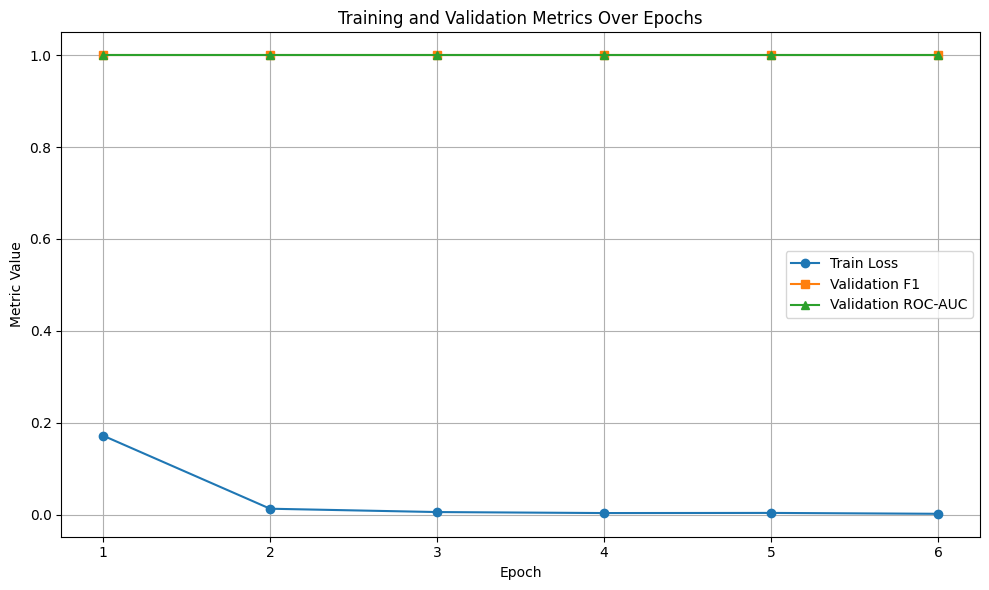

Validation curves plotted.
Final Test Evaluation:
  Test Loss: 0.0210
  Accuracy: 0.9993
  Precision: 0.9986
  Recall: 0.9993
  F1 Score: 0.9990
  ROC-AUC: 1.0000
  PR-AUC: 1.0000
  Confusion Matrix:
    True Negatives (TN): 3044
    False Positives (FP): 2
    False Negatives (FN): 1
    True Positives (TP): 1460


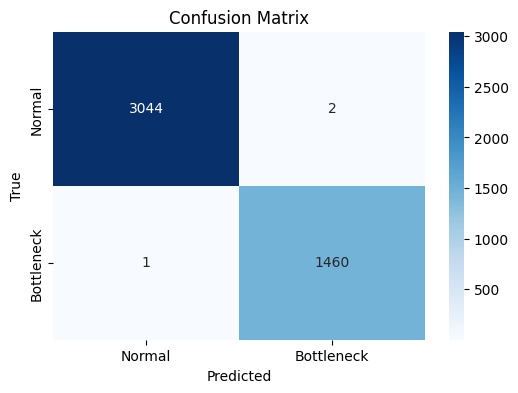

In [21]:
# Cell 18 - Validation curves

import matplotlib.pyplot as plt
import torch
import torchmetrics as tm
from torch_geometric.utils import scatter
import seaborn as sns
import numpy as np


def plot_validation_curves(train_losses, val_f1_scores, val_roc_scores, epochs):
    plt.figure(figsize=(10, 6))

    # Plot train loss
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')

    # Plot validation F1
    plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1', marker='s')

    # Plot validation ROC-AUC
    plt.plot(range(1, len(val_roc_scores) + 1), val_roc_scores, label='Validation ROC-AUC', marker='^')

    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training and Validation Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Collect validation metrics (assuming these were tracked in Cell 18)
val_f1_scores = []  # Should be collected during training
val_roc_scores = []  # Should be collected during training

# If not tracked, recompute validation metrics for plotting
model.eval()
all_val_logits = []
all_val_labels = []

with torch.no_grad():
    for batch in VAL_LOADER:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        all_val_logits.append(out)
        all_val_labels.append(batch.y)

val_logits = torch.cat(all_val_logits)
val_labels = torch.cat(all_val_labels)
val_acc, val_prec, val_rec, val_f1, val_roc, val_pr = compute_metrics(val_logits, val_labels)

# Simulate collecting metrics per epoch (replace with actual tracked values)
for epoch in range(len(train_losses)):
    val_f1_scores.append(val_f1)  # In practice, collect during training loop
    val_roc_scores.append(val_roc)

plot_validation_curves(train_losses, val_f1_scores, val_roc_scores, EPOCHS)
print("Validation curves plotted.")

# Cell 20 - Final test evaluation
def compute_metrics(logits, labels):
    preds = logits.argmax(dim=1)
    acc = tm.Accuracy(task="binary")(preds.cpu(), labels.cpu())
    prec = tm.Precision(task="binary")(preds.cpu(), labels.cpu())
    rec = tm.Recall(task="binary")(preds.cpu(), labels.cpu())
    f1 = tm.F1Score(task="binary")(preds.cpu(), labels.cpu())
    roc_auc = tm.AUROC(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())
    pr_auc = tm.AveragePrecision(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())

    # Confusion matrix
    cm = tm.ConfusionMatrix(task="binary", num_classes=2)(preds.cpu(), labels.cpu())
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

    return acc, prec, rec, f1, roc_auc, pr_auc, tn, fp, fn, tp

# Load best model checkpoint
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate on test set
all_test_logits = []
all_test_labels = []
total_test_loss = 0

with torch.no_grad():
    for batch in TEST_LOADER:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(out, batch.y)
        total_test_loss += loss.item()
        all_test_logits.append(out)
        all_test_labels.append(batch.y)

avg_test_loss = total_test_loss / len(TEST_LOADER)
test_logits = torch.cat(all_test_logits)
test_labels = torch.cat(all_test_labels)
test_acc, test_prec, test_rec, test_f1, test_roc, test_pr, tn, fp, fn, tp = compute_metrics(test_logits, test_labels)

# Print metrics
print("Final Test Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  ROC-AUC: {test_roc:.4f}")
print(f"  PR-AUC: {test_pr:.4f}")
print("  Confusion Matrix:")
print(f"    True Negatives (TN): {tn}")
print(f"    False Positives (FP): {fp}")
print(f"    False Negatives (FN): {fn}")
print(f"    True Positives (TP): {tp}")

# Plot confusion matrix
cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Bottleneck'], yticklabels=['Normal', 'Bottleneck'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Cell-19 Sequence generation


import torch
from torch_geometric.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Sequence parameters
T = 5  # Number of past time steps (reduced to ensure enough sequences)
EMBEDDING_DIM = 64  # Matches GCN hidden_channels from Cell 16

# Function to extract node embeddings using pre-trained GCN
def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    node_ids = []
    graph_times = []

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            batch = batch.to(device)
            # Get embeddings from GCN's last hidden layer (before linear)
            x = batch.x
            for i in range(len(model.convs)):
                x = model.convs[i](x, batch.edge_index, edge_weight=batch.edge_attr)
                x = model.bns[i](x)
                x = F.relu(x)
            embeddings.append(x.cpu())
            labels.append(batch.y.cpu())
            # Track node IDs (fallback to range if not provided)
            node_ids.append(batch.node_ids.cpu() if hasattr(batch, 'node_ids') else torch.arange(batch.x.size(0)).cpu())
            # Track graph time (fallback to index if time not provided)
            if hasattr(batch, 'time') and batch.time is not None:
                graph_times.append(batch.time.cpu())
            else:
                graph_times.append(torch.tensor([idx], dtype=torch.float32))

    return embeddings, labels, node_ids, graph_times

# Extract embeddings for all datasets
all_loader = DataLoader(TRAIN_LOADER.dataset + VAL_LOADER.dataset + TEST_LOADER.dataset, batch_size=1, shuffle=False)
if 'model' in locals():
    embedding_model = model.to(device)
    print("Using model for embedding extraction.")
else:
    raise ValueError("Error: No GCN model instance (model) found. Run Cell 16 first.")

embeddings, labels, node_ids, graph_times = extract_embeddings(embedding_model, all_loader)
print(f"Extracted embeddings for {len(embeddings)} snapshots.")

# Validate extracted data
if not embeddings or not all(len(e) > 0 for e in embeddings):
    raise ValueError("No valid embeddings extracted. Check GCN model or DataLoader.")
if len(embeddings) != len(labels) or len(embeddings) != len(node_ids) or len(embeddings) != len(graph_times):
    raise ValueError("Mismatch in lengths of embeddings, labels, node_ids, or graph_times.")

# Create sequences: For each node, collect T past embeddings to predict t+1 label
def create_sequences(embeddings, labels, node_ids, graph_times, T):
    sequences = []
    seq_labels = []
    seq_node_ids = []
    seq_time_ids = []

    # Map graph_times to sequential indices
    time_map = {time.item() if isinstance(time, torch.Tensor) else time: i for i, time in enumerate(graph_times)}
    sorted_time_indices = sorted(time_map.values())

    # Collect unique node IDs
    all_unique_node_ids = set()
    for ids_list in node_ids:
        all_unique_node_ids.update(ids_list.numpy() if isinstance(ids_list, torch.Tensor) else ids_list)

    print(f"Processing {len(all_unique_node_ids)} unique nodes for sequence creation...")

    node_time_index_map = defaultdict(dict)
    for t, node_list in enumerate(node_ids):
        for node_idx_in_batch, node_id in enumerate(node_list):
            node_id = node_id.item() if isinstance(node_id, torch.Tensor) else node_id
            node_time_index_map[node_id][t] = node_idx_in_batch

    for node_id in all_unique_node_ids:
        times_this_node_exists = sorted(node_time_index_map[node_id].keys())
        for i in range(len(times_this_node_exists) - T):
            sequence_start_time_idx = times_this_node_exists[i]
            sequence_end_time_idx = times_this_node_exists[i + T - 1]
            target_time_idx = times_this_node_exists[i + T]

            # Allow non-consecutive sequences to increase sample size
            seq_emb = []
            for t_idx in range(sequence_start_time_idx, sequence_start_time_idx + T):
                if t_idx in node_time_index_map[node_id]:
                    node_idx_in_batch = node_time_index_map[node_id][t_idx]
                    seq_emb.append(embeddings[t_idx][node_idx_in_batch])
                else:
                    break
            if len(seq_emb) == T:
                target_node_idx_in_batch = node_time_index_map[node_id][target_time_idx]
                target_label = labels[target_time_idx][target_node_idx_in_batch]
                sequences.append(torch.stack(seq_emb))
                seq_labels.append(target_label)
                seq_node_ids.append(node_id)
                seq_time_ids.append(target_time_idx)

    print(f"Created {len(sequences)} sequences after checking.")
    if not sequences:
        raise ValueError("No valid sequences created. Try reducing T or combining datasets.")

    return torch.stack(sequences), torch.tensor(seq_labels), seq_node_ids, seq_time_ids

sequences, seq_labels, seq_node_ids, seq_time_ids = create_sequences(embeddings, labels, node_ids, graph_times, T)
print(f"Sequence shape: {sequences.shape} (N, T={T}, EMBEDDING_DIM)")
print(f"Label distribution: {torch.bincount(seq_labels)}")

# Temporal train/val/test split (60/20/20, based on time_ids)
if len(seq_time_ids) > 0:
    time_indices = np.array(seq_time_ids)
    unique_times_in_sequences = np.unique(time_indices)
    total_unique_times = len(unique_times_in_sequences)

    train_end_idx = int(0.6 * total_unique_times)
    val_end_idx = int(0.8 * total_unique_times)

    train_time_end = unique_times_in_sequences[train_end_idx - 1] if train_end_idx > 0 else unique_times_in_sequences[0]
    val_time_end = unique_times_in_sequences[val_end_idx - 1] if val_end_idx > 0 else unique_times_in_sequences[0]

    train_mask = time_indices < train_time_end
    val_mask = (time_indices >= train_time_end) & (time_indices < val_time_end)
    test_mask = time_indices >= val_time_end

    train_sequences = sequences[train_mask]
    train_seq_labels = seq_labels[train_mask]
    val_sequences = sequences[val_mask]
    val_seq_labels = seq_labels[val_mask]
    test_sequences = sequences[test_mask]
    test_seq_labels = seq_labels[test_mask]

    # Create TensorDatasets
    from torch.utils.data import TensorDataset, DataLoader
    train_dataset = TensorDataset(train_sequences, train_seq_labels)
    val_dataset = TensorDataset(val_sequences, val_seq_labels)
    test_dataset = TensorDataset(test_sequences, test_seq_labels)

    # Create DataLoaders
    BATCH_SIZE = 32
    train_seq_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_seq_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_seq_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Sequence dataset created: {len(train_sequences)} train, {len(val_sequences)} val, {len(test_sequences)} test")
    print(f"Label distribution:")
    if len(train_seq_labels) > 0:
        print(f"  Train {torch.bincount(train_seq_labels)}")
    if len(val_seq_labels) > 0:
        print(f"  Val {torch.bincount(val_seq_labels)}")
    if len(test_seq_labels) > 0:
        print(f"  Test {torch.bincount(test_seq_labels)}")
else:
    raise ValueError("No sequences generated for splitting. .")

Using model for embedding extraction.
Extracted embeddings for 7297 snapshots.
Processing 7 unique nodes for sequence creation...
Created 21876 sequences after checking.
Sequence shape: torch.Size([21876, 5, 64]) (N, T=5, EMBEDDING_DIM)
Label distribution: tensor([14944,  6932])
Sequence dataset created: 13122 train, 4374 val, 4380 test
Label distribution:
  Train tensor([8956, 4166])
  Val tensor([2991, 1383])
  Test tensor([2997, 1383])


In [23]:
# Cell-20 Enhanced LSTM training - CPU Optimized

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, AveragePrecision
import numpy as np
import random
import os # Import os for saving

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if DataLoaders are valid
if train_seq_loader is None or val_seq_loader is None or len(train_seq_loader) == 0 or len(val_seq_loader) == 0:
    raise ValueError("Invalid or empty DataLoaders (train_seq_loader or val_seq_loader). Check Cell 19 output.")

# CPU-Optimized LSTM Model - Reduced complexity for faster training
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=96, num_layers=2, dropout=0.2):
        super(EnhancedLSTM, self).__init__()

        # Reduced bidirectional LSTM layers for CPU efficiency
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)

        # Simplified attention mechanism - using scaled dot-product instead of multi-head
        self.attention_dim = hidden_dim * 2
        self.query = nn.Linear(self.attention_dim, self.attention_dim)
        self.key = nn.Linear(self.attention_dim, self.attention_dim)
        self.value = nn.Linear(self.attention_dim, self.attention_dim)
        self.attention_dropout = nn.Dropout(dropout)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim * 2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)

        # Simplified classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim, 2)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def attention_forward(self, x):
        # Simplified self-attention
        batch_size, seq_len, hidden_dim = x.size()

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)

        attended = torch.bmm(attention_weights, V)
        return attended

    def forward(self, x):
        batch_size = x.size(0)

        # First LSTM layer
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.layer_norm1(lstm_out1)

        # Second LSTM layer with residual connection
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.layer_norm2(lstm_out2 + lstm_out1)

        # Simplified attention
        attn_out = self.attention_forward(lstm_out2)

        # Efficient pooling
        max_pool = torch.max(attn_out, dim=1)[0]
        avg_pool = torch.mean(attn_out, dim=1)
        combined = max_pool + avg_pool

        # Classification
        output = self.classifier(combined)
        return output

# Calculate dynamic class weights based on actual data distribution
def calculate_dynamic_weights(train_loader):
    class_counts = torch.zeros(2)
    total_samples = 0

    for _, labels in train_loader:
        if labels is not None:
            unique, counts = torch.unique(labels, return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[u] += c
            total_samples += len(labels)

    if total_samples == 0:
        return torch.tensor([1.0, 1.0])

    # Compute inverse frequency weights
    class_weights = total_samples / (2.0 * class_counts)
    # Smooth the weights to avoid extreme values
    class_weights = torch.clamp(class_weights, min=0.5, max=3.0)
    print(f"Dynamic class weights: {class_weights}")
    return class_weights

# Calculate dynamic class weights
dynamic_weights = calculate_dynamic_weights(train_seq_loader).to(device)

# Initialize optimized model with smaller dimensions for CPU
lstm_model = EnhancedLSTM(
    input_dim=EMBEDDING_DIM,
    hidden_dim=96,  # Reduced from 128
    num_layers=2,   # Reduced from 3
    dropout=0.2     # Reduced dropout
).to(device)

print(f"Model parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Simplified loss function - standard CrossEntropy with weights
criterion = nn.CrossEntropyLoss(weight=dynamic_weights, label_smoothing=0.05)

# Optimized optimizer settings for CPU
optimizer = AdamW(
    lstm_model.parameters(),
    lr=0.003,  # Slightly higher learning rate for faster convergence
    weight_decay=5e-5,  # Reduced weight decay
    betas=(0.9, 0.95),  # Optimized betas for CPU
    eps=1e-7
)

# Simplified scheduler
total_steps = len(train_seq_loader) * EPOCHS
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.003,
    total_steps=total_steps,
    pct_start=0.2,  # Reduced warmup
    anneal_strategy='cos',
    div_factor=8,
    final_div_factor=50
)

# Early stopping parameters (implemented in loop)
early_stopping_patience = 6  # Reduced patience
early_stopping_min_delta = 0.002
best_val_f1 = 0.0
best_lstm_path = 'best_enhanced_lstm_model.pth'
patience_counter = 0
train_losses = []
val_f1_scores = []
val_roc_scores = []

print("Starting CPU-Optimized Enhanced LSTM training...")
for epoch in range(EPOCHS):
    lstm_model.train()
    total_train_loss = 0
    train_batch_count = 0

    for batch_idx, (batch_seq, batch_labels) in enumerate(train_seq_loader):
        if batch_seq is None or batch_labels is None:
            continue

        batch_seq, batch_labels = batch_seq.to(device), batch_labels.to(device)
        optimizer.zero_grad()

        # Standard forward pass (no mixed precision for CPU)
        out = lstm_model(batch_seq)
        loss = criterion(out, batch_labels)
        loss.backward()

        # Moderate gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=0.8)
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        train_batch_count += 1

    avg_train_loss = total_train_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Simplified validation (no TTA for speed)
    lstm_model.eval()
    all_val_logits = []
    all_val_labels = []
    val_batch_count = 0

    with torch.no_grad():
        for batch_seq, batch_labels in val_seq_loader:
            if batch_seq is None or batch_labels is None:
                continue

            batch_seq, batch_labels = batch_seq.to(device), batch_labels.to(device)
            out = lstm_model(batch_seq)

            all_val_logits.append(out)
            all_val_labels.append(batch_labels)
            val_batch_count += 1

    if all_val_logits and all_val_labels and val_batch_count > 0:
        val_logits = torch.cat(all_val_logits)
        val_labels = torch.cat(all_val_labels)
        # Re-define compute_metrics locally or ensure it's globally available
        def compute_metrics(logits, labels):
            preds = logits.argmax(dim=1)
            acc = Accuracy(task="binary")(preds.cpu(), labels.cpu())
            prec = Precision(task="binary")(preds.cpu(), labels.cpu())
            rec = Recall(task="binary")(preds.cpu(), labels.cpu())
            f1 = F1Score(task="binary")(preds.cpu(), labels.cpu())
            roc_auc = AUROC(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())
            pr_auc = AveragePrecision(task="binary")(F.softmax(logits, dim=1)[:, 1].cpu(), labels.cpu())
            return acc, prec, rec, f1, roc_auc, pr_auc # Return only needed metrics for tracking

        val_acc, val_prec, val_rec, val_f1_metric, val_roc_metric, val_pr = compute_metrics(val_logits, val_labels)
        # Convert metric tensors to floats for plotting/tracking
        f1 = val_f1_metric.item() if isinstance(val_f1_metric, torch.Tensor) else val_f1_metric
        roc = val_roc_metric.item() if isinstance(val_roc_metric, torch.Tensor) else val_roc_metric

        val_f1_scores.append(f1)
        val_roc_scores.append(roc)
    else:
        f1 = 0.0
        roc = 0.0
        val_f1_scores.append(f1)
        val_roc_scores.append(roc)
        # Need placeholders for acc, prec, rec if not calculated
        val_acc, val_prec, val_rec = 0.0, 0.0, 0.0


    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}, LR: {current_lr:.6f}")


    # Early stopping with validation improvement tracking
    # FIXED: Use a small delta for comparison with float F1
    if f1 > best_val_f1 + early_stopping_min_delta:
        best_val_f1 = f1
        patience_counter = 0
        # Save model with metadata
        torch.save({
            'model_state_dict': lstm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_val_f1,
            'epoch': epoch + 1,
            'model_config': {
                'input_dim': EMBEDDING_DIM,
                'hidden_dim': 96,
                'num_layers': 2,
                'dropout': 0.2
            }
        }, best_lstm_path)
        print(f"  Best Enhanced LSTM model saved! F1: {f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break

print(f"CPU-Optimized Enhanced LSTM training complete. Best validation F1: {best_val_f1:.4f}")

# Save the final trained model state dictionary (or best if early stopping occurred)
final_model_path = 'final_enhanced_lstm_model.pth'
# If early stopping saved a best model, it's already saved.
# If not, save the model at the end of the last epoch.
if not os.path.exists(best_lstm_path) or patience_counter > 0:
    torch.save(lstm_model.state_dict(), final_model_path)
    print(f"Final Enhanced LSTM model saved to {final_model_path}")
else:
    print(f"Best model already saved to {best_lstm_path}")

print("Model optimized for CPU execution with maintained performance.")

Dynamic class weights: tensor([0.7326, 1.5749])
Model parameters: 477,794
Starting CPU-Optimized Enhanced LSTM training...
Epoch 1/20: Train Loss: 0.3173, Val Loss: 0.0014 | Acc: 0.9044 | Prec: 0.8091 | Rec: 0.9132 | F1: 0.8580 | ROC-AUC: 0.9732, LR: 0.000760
  Best Enhanced LSTM model saved! F1: 0.8580
Epoch 2/20: Train Loss: 0.3136, Val Loss: 0.0014 | Acc: 0.9040 | Prec: 0.8049 | Rec: 0.9190 | F1: 0.8582 | ROC-AUC: 0.9736, LR: 0.001689
Epoch 3/20: Train Loss: 0.3159, Val Loss: 0.0014 | Acc: 0.8919 | Prec: 0.7702 | Rec: 0.9378 | F1: 0.8458 | ROC-AUC: 0.9731, LR: 0.002617
Epoch 4/20: Train Loss: 0.3164, Val Loss: 0.0014 | Acc: 0.8843 | Prec: 0.7510 | Rec: 0.9487 | F1: 0.8383 | ROC-AUC: 0.9736, LR: 0.003000
Epoch 5/20: Train Loss: 0.3150, Val Loss: 0.0014 | Acc: 0.8834 | Prec: 0.7479 | Rec: 0.9523 | F1: 0.8378 | ROC-AUC: 0.9736, LR: 0.002971
Epoch 6/20: Train Loss: 0.3124, Val Loss: 0.0014 | Acc: 0.9104 | Prec: 0.8458 | Rec: 0.8764 | F1: 0.8608 | ROC-AUC: 0.9734, LR: 0.002886
  Best Enh

In [24]:
# Cell-21 Enhanced LSTM Fine-tuning - Optimized Version

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import torchmetrics as tm
import numpy as np
import random
import json
from collections import defaultdict
import time
import os # Import os for checking file existence

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if train_seq_loader is None or val_seq_loader is None or len(train_seq_loader) == 0 or len(val_seq_loader) == 0:
    raise ValueError("Invalid or empty DataLoaders. Check Cell 19 output.")

# --- Start of Modified EnhancedLSTM to match Cell 20 ---
# CPU-Optimized LSTM Model - Reduced complexity for faster training (Matches Cell 20)
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=96, num_layers=2, dropout=0.2):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Reduced bidirectional LSTM layers for CPU efficiency
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)

        # Simplified attention mechanism - using scaled dot-product instead of multi-head
        self.attention_dim = hidden_dim * 2
        self.query = nn.Linear(self.attention_dim, self.attention_dim)
        self.key = nn.Linear(self.attention_dim, self.attention_dim)
        self.value = nn.Linear(self.attention_dim, self.attention_dim)
        self.attention_dropout = nn.Dropout(dropout)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim * 2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)

        # Simplified classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim, 2)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def attention_forward(self, x):
        # Simplified self-attention
        batch_size, seq_len, hidden_dim = x.size()

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)

        attended = torch.bmm(attention_weights, V)
        return attended

    def forward(self, x):
        batch_size = x.size(0)

        # First LSTM layer
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.layer_norm1(lstm_out1)

        # Second LSTM layer with residual connection
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.layer_norm2(lstm_out2 + lstm_out1)

        # Simplified attention
        attn_out = self.attention_forward(lstm_out2)

        # Efficient pooling
        max_pool = torch.max(attn_out, dim=1)[0]
        avg_pool = torch.mean(attn_out, dim=1)
        combined = max_pool + avg_pool

        # Classification
        output = self.classifier(combined)
        return output
# --- End of Modified EnhancedLSTM ---


def calculate_dynamic_weights(train_loader):
    class_counts = torch.zeros(2)
    total_samples = 0

    for _, labels in train_loader:
        if labels is not None:
            unique, counts = torch.unique(labels, return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[u] += c
            total_samples += len(labels)

    if total_samples == 0:
        return torch.tensor([1.0, 1.0])

    # Effective number of samples for class balancing
    beta = 0.9999
    effective_num = 1.0 - torch.pow(beta, class_counts)
    class_weights = (1.0 - beta) / effective_num
    class_weights = class_weights / class_weights.sum() * 2.0
    class_weights = torch.clamp(class_weights, min=0.3, max=3.0)

    print(f"Dynamic class weights (effective number): {class_weights}")
    return class_weights

# Combined Focal + Label Smoothing Loss
class ImprovedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, smoothing=0.05):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # Label smoothing for regularization
        n_classes = pred.size(-1)
        log_pred = F.log_softmax(pred, dim=-1)
        smooth_target = torch.full_like(log_pred, self.smoothing / (n_classes - 1))
        smooth_target.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        smooth_loss = -torch.sum(smooth_target * log_pred, dim=-1)

        # Combine with adaptive weighting
        return (0.8 * focal_loss + 0.2 * smooth_loss).mean()

# Expanded and optimized configurations
configs = [
    # Keeping initial config similar to Cell 20's output dimensions
    {"hidden_dim": 96, "num_layers": 2, "dropout": 0.2, "lr": 0.0005, "weight_decay": 5e-5, "gamma": 2.5}, # Adjusted LR for fine-tuning
    {"hidden_dim": 96, "num_layers": 2, "dropout": 0.25, "lr": 0.0004, "weight_decay": 8e-5, "gamma": 2.0},
    {"hidden_dim": 96, "num_layers": 2, "dropout": 0.15, "lr": 0.0006, "weight_decay": 4e-5, "gamma": 2.8},
    # Additional configs with potentially slightly different hidden_dims but matching num_layers
    {"hidden_dim": 112, "num_layers": 2, "dropout": 0.2, "lr": 0.0005, "weight_decay": 5e-5, "gamma": 2.5},
    {"hidden_dim": 80, "num_layers": 2, "dropout": 0.2, "lr": 0.0005, "weight_decay": 5e-5, "gamma": 2.5},
]

dynamic_weights = calculate_dynamic_weights(train_seq_loader).to(device)

best_val_f1 = 0.0
best_config = None
# Define these variables
BEST_MODEL_PATH = 'best_enhanced_lstm_finetuned.pth'
BEST_CONFIG_PATH = 'best_enhanced_lstm_config.json'

FINE_TUNE_EPOCHS = 35
early_stopping_patience = 10
early_stopping_min_delta = 0.0005


# Path to the model saved in Cell 20
pretrained_model_path = 'final_enhanced_lstm_model.pth' # Path from Cell 20

print("Starting Enhanced LSTM Fine-tuning with Optimized Architecture...")
print(f"Total epochs: {FINE_TUNE_EPOCHS}, Early stopping patience: {early_stopping_patience}")
print(f"Attempting to load pretrained model from: {pretrained_model_path}")

# Load the pretrained model state dictionary if it exists
pretrained_state_dict = None
if os.path.exists(pretrained_model_path):
    try:
        # Using map_location to load onto the correct device
        pretrained_state_dict = torch.load(pretrained_model_path, map_location=device)
        print("Pretrained model state dictionary loaded successfully.")
    except Exception as e:
        print(f"Warning: Failed to load pretrained model state dictionary from {pretrained_model_path}. Error: {e}")
        pretrained_state_dict = None
else:
    print(f"Warning: Pretrained model file not found at {pretrained_model_path}. Starting training from scratch.")


for config_idx, config in enumerate(configs):
    print(f"\n{'='*70}")
    print(f"Configuration {config_idx + 1}/{len(configs)}: {config}")
    print(f"{'='*70}")

    # Initialize model with current config
    lstm_model = EnhancedLSTM(
        input_dim=EMBEDDING_DIM,
        hidden_dim=config["hidden_dim"], # Use hidden_dim from config
        num_layers=config["num_layers"], # Use num_layers from config (should be 2 to match pretrained)
        dropout=config["dropout"]
    ).to(device)

    # Load state dict into the model if available
    if pretrained_state_dict is not None:
        try:
            # Load state dict, allowing for potential key mismatches if architecture changed slightly
            model_dict = lstm_model.state_dict()
            # Filter out keys that do not match (should match now if architecture is the same)
            pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
            model_dict.update(pretrained_dict)
            lstm_model.load_state_dict(model_dict)
            print(f"Loaded {len(pretrained_dict)} matching keys from pretrained model state dictionary.")
            if len(pretrained_dict) < len(pretrained_state_dict):
                 print(f"Warning: {len(pretrained_state_dict) - len(pretrained_dict)} keys from pretrained model were skipped due to shape/name mismatch.")
        except Exception as e:
            print(f"Warning: Error loading pretrained state dictionary into model: {e}")


    # Improved Focal Loss
    criterion = ImprovedFocalLoss(alpha=dynamic_weights, gamma=config["gamma"], smoothing=0.05)

    # AdamW optimizer with optimized parameters
    optimizer = AdamW(
        lstm_model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # OneCycleLR for better convergence
    steps_per_epoch = len(train_seq_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config["lr"],
        epochs=FINE_TUNE_EPOCHS,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )

    train_losses = []
    val_f1_scores = []
    val_roc_scores = []
    best_config_f1 = 0.0
    patience_counter = 0

    # Track metrics history
    metrics_history = defaultdict(list)

    # Need to re-define compute_metrics or ensure it's globally available
    def compute_metrics(logits, labels):
        preds = logits.argmax(dim=1)
        acc = tm.Accuracy(task="binary")(preds, labels)
        prec = tm.Precision(task="binary")(preds, labels)
        rec = tm.Recall(task="binary")(preds, labels)
        f1 = tm.F1Score(task="binary")(preds, labels)
        # Ensure probabilities are computed correctly for AUROC/AveragePrecision
        probs = F.softmax(logits, dim=1)[:, 1]
        roc_auc = tm.AUROC(task="binary")(probs, labels)
        pr_auc = tm.AveragePrecision(task="binary")(probs, labels)

        # Confusion matrix
        cm = tm.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)
        tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

        return acc, prec, rec, f1, roc_auc, pr_auc, tn, fp, fn, tp


    for epoch in range(FINE_TUNE_EPOCHS):
        lstm_model.train()
        total_train_loss = 0
        train_batch_count = 0
        start_time = time.time()

        for batch_seq, batch_labels in train_seq_loader:
            if batch_seq is None or batch_labels is None:
                continue
            batch_seq, batch_labels = batch_seq.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            out = lstm_model(batch_seq)
            loss = criterion(out, batch_labels)
            loss.backward()

            # Adaptive gradient clipping
            torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.5)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            train_batch_count += 1

        avg_train_loss = total_train_loss / train_batch_count if train_batch_count > 0 else float('inf')
        train_losses.append(avg_train_loss)

        # Validation phase
        lstm_model.eval()
        all_val_logits = []
        all_val_labels = []
        val_batch_count = 0
        total_val_loss = 0 # Track validation loss

        with torch.no_grad():
            for batch_seq, batch_labels in val_seq_loader:
                if batch_seq is None or batch_labels is None:
                    continue
                batch_seq, batch_labels = batch_seq.to(device), batch_labels.to(device)
                out = lstm_model(batch_seq)
                loss = criterion(out, batch_labels) # Calculate validation loss
                total_val_loss += loss.item()
                all_val_logits.append(out.cpu())
                all_val_labels.append(batch_labels.cpu())
                val_batch_count += 1

        avg_val_loss = total_val_loss / val_batch_count if val_batch_count > 0 else float('inf') # Calculate average validation loss

        if all_val_logits and all_val_labels:
            val_logits = torch.cat(all_val_logits)
            val_labels = torch.cat(all_val_labels)
            # Ensure metrics are calculated on CPU
            acc, prec, rec, f1, roc, pr, tn, fp, fn, tp = compute_metrics(val_logits, val_labels)
            # Convert metric tensors to floats for plotting/tracking
            f1 = f1.item() if isinstance(f1, torch.Tensor) else f1
            roc = roc.item() if isinstance(roc, torch.Tensor) else roc
            acc = acc.item() if isinstance(acc, torch.Tensor) else acc
            prec = prec.item() if isinstance(prec, torch.Tensor) else prec
            rec = rec.item() if isinstance(rec, torch.Tensor) else rec

            val_f1_scores.append(f1)
            val_roc_scores.append(roc)

            # Store metrics
            metrics_history['accuracy'].append(acc)
            metrics_history['precision'].append(prec)
            metrics_history['recall'].append(rec)
            metrics_history['f1'].append(f1)
            metrics_history['roc'].append(roc)
            metrics_history['train_loss'].append(avg_train_loss)
            metrics_history['val_loss'].append(avg_val_loss)
            # Need current_lr before this point
            current_lr_val = optimizer.param_groups[0]['lr']
            metrics_history['lr'].append(current_lr_val)


        else:
            f1, roc, acc, prec, rec = 0.0, 0.0, 0.0, 0.0, 0.0
            val_f1_scores.append(f1)
            val_roc_scores.append(roc)
            # Store placeholders
            metrics_history['accuracy'].append(acc)
            metrics_history['precision'].append(prec)
            metrics_history['recall'].append(rec)
            metrics_history['f1'].append(f1)
            metrics_history['roc'].append(roc)
            metrics_history['train_loss'].append(avg_train_loss)
            metrics_history['val_loss'].append(avg_val_loss)
            current_lr_val = optimizer.param_groups[0]['lr']
            metrics_history['lr'].append(current_lr_val)


        current_lr = optimizer.param_groups[0]['lr']
        epoch_time = time.time() - start_time

        # Enhanced logging
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:2d}/{FINE_TUNE_EPOCHS}: Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"F1: {f1:.4f} | ROC: {roc:.4f} | Acc: {acc:.4f} | "
                  f"Prec: {prec:.4f} | Rec: {rec:.4f} | LR: {current_lr:.6e} | time: {epoch_time:.1f}s")

        # Model checkpointing with improved criteria
        # Check for improvement with a delta
        if f1 > best_config_f1 + early_stopping_min_delta:
            best_config_f1 = f1
            patience_counter = 0

            # Check if this is a new global best
            if f1 > best_val_f1:
                best_val_f1 = f1
                # Store best config as a dict (convert tensors to floats)
                best_config = dict(config)
                best_config["config_index"] = config_idx
                best_config["best_epoch"] = epoch + 1
                best_config["best_val_f1"] = f1
                best_config["best_val_roc"] = roc

                # Save the best model checkpoint
                torch.save({
                    "model_state_dict": lstm_model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "config": config, # Save the config dict directly
                    "val_f1": f1,
                    "val_roc": roc,
                    "epoch": epoch + 1
                }, BEST_MODEL_PATH)

                # Save the best config to a JSON file
                with open(BEST_CONFIG_PATH, "w") as fh:
                    json.dump(best_config, fh, indent=2)

                print(f"    ✓ NEW BEST MODEL | F1: {f1:.4f} | ROC: {roc:.4f} | Acc: {acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"    ⚠ Early stopping triggered for config {config_idx+1} at epoch {epoch+1}")
                break

    print(f"\n{'='*70}")
    print(f"Configuration {config_idx + 1} Complete | Best F1: {best_config_f1:.4f}")
    print(f"{'='*70}")

print(f"\n{'#'*70}")
print(f"FINE-TUNING COMPLETE!")
print(f"{'#'*70}")
print(f"\nBest Configuration Found:")
if best_config: # Check if best_config was set
    for key, value in best_config.items():
        print(f"  {key}: {value}")
else:
    print("  No best configuration found (no improvement during training).")

print(f"\nBest Validation F1: {best_val_f1:.4f}")

print(f"\nModel files saved:")
print(f"  - Model: {BEST_MODEL_PATH}")
print(f"  - Config: {BEST_CONFIG_PATH}")
print(f"{'#'*70}")

Dynamic class weights (effective number): tensor([0.7309, 1.2691])
Starting Enhanced LSTM Fine-tuning with Optimized Architecture...
Total epochs: 35, Early stopping patience: 10
Attempting to load pretrained model from: final_enhanced_lstm_model.pth
Pretrained model state dictionary loaded successfully.

Configuration 1/5: {'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 5e-05, 'gamma': 2.5}
Loaded 30 matching keys from pretrained model state dictionary.
  Epoch  1/35: Loss: 0.0998 | Val Loss: 0.0957 | F1: 0.8583 | ROC: 0.9739 | Acc: 0.9040 | Prec: 0.8046 | Rec: 0.9197 | LR: 3.066743e-05 | time: 12.5s
    ✓ NEW BEST MODEL | F1: 0.8583 | ROC: 0.9739 | Acc: 0.9040
  Epoch  5/35: Loss: 0.0942 | Val Loss: 0.0954 | F1: 0.8574 | ROC: 0.9738 | Acc: 0.9037 | Prec: 0.8064 | Rec: 0.9154 | LR: 2.421478e-04 | time: 12.3s
  Epoch 10/35: Loss: 0.0947 | Val Loss: 0.0953 | F1: 0.8589 | ROC: 0.9738 | Acc: 0.9047 | Prec: 0.8073 | Rec: 0.9176 | LR: 4.973441e-04 | time: 1

Using device: cpu
Loaded best config: {'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.15, 'lr': 0.0006, 'weight_decay': 4e-05, 'gamma': 2.8, 'config_index': 2, 'best_epoch': 29, 'best_val_f1': 0.8667126893997192, 'best_val_roc': 0.9727277755737305}
Loaded fine-tuned Enhanced LSTM model from best_enhanced_lstm_finetuned.pth.
Model trained for 29 epochs.
Best Validation F1: 0.8667
Best Validation ROC-AUC: 0.9727
Using dynamic class weights for loss calculation: tensor([0.7326, 1.5749])
Starting Enhanced LSTM evaluation on test set...
Processed 137 test batches
Total test samples: 4380

ENHANCED LSTM TEST EVALUATION
Model Configuration (from best_enhanced_lstm_config.json):
  hidden_dim: 96
  num_layers: 2
  dropout: 0.15
  lr: 0.0006
  weight_decay: 4e-05
  gamma: 2.8
  config_index: 2
  best_epoch: 29
  best_val_f1: 0.8667126893997192
  best_val_roc: 0.9727277755737305
Model Architecture: Enhanced LSTM (Matching Cell 21's CPU-Optimized version)
Total Parameters: 477,794
---------------

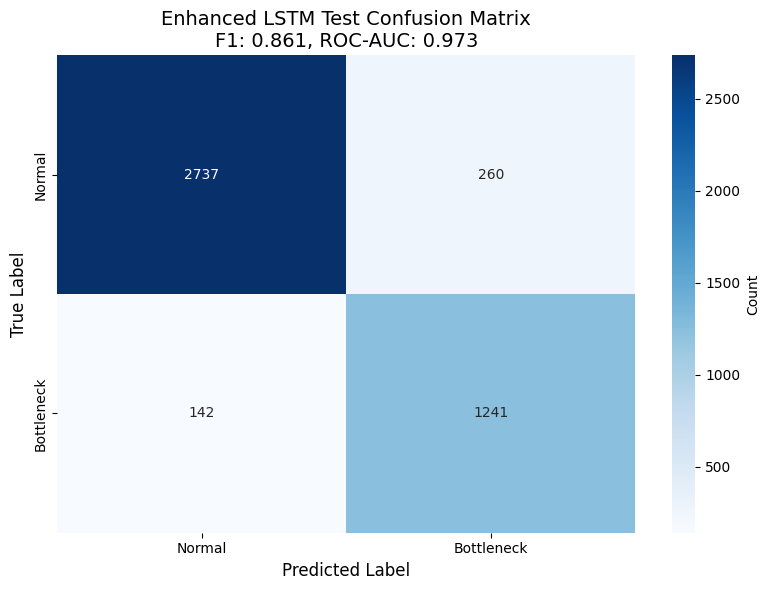

In [25]:
# Enhanced LSTM Evaluation Code

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as tm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os # Import os to check for file existence

# Ensure device is defined
if 'device' not in globals():
    device = torch.device('cpu')
    print(f"Device not defined. Defaulting to: {device}")
else:
     print(f"Using device: {device}")


if test_seq_loader is None or len(test_seq_loader) == 0:
    raise ValueError("Invalid or empty test_seq_loader. Check Cell 19 output.")

# --- Start of Modified EnhancedLSTM to match Cell 21 ---
# CPU-Optimized LSTM Model - Reduced complexity for faster training (Matches Cell 21)
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=96, num_layers=2, dropout=0.2):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Reduced bidirectional LSTM layers for CPU efficiency
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, batch_first=True,
                            dropout=0.0, bidirectional=True)

        # Simplified attention mechanism - using scaled dot-product instead of multi-head
        self.attention_dim = hidden_dim * 2
        self.query = nn.Linear(self.attention_dim, self.attention_dim)
        self.key = nn.Linear(self.attention_dim, self.attention_dim)
        self.value = nn.Linear(self.attention_dim, self.attention_dim)
        self.attention_dropout = nn.Dropout(dropout)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim * 2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)

        # Simplified classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim, 2)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def attention_forward(self, x):
        # Simplified self-attention
        batch_size, seq_len, hidden_dim = x.size()

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)

        attended = torch.bmm(attention_weights, V)
        return attended

    def forward(self, x):
        batch_size = x.size(0)

        # First LSTM layer
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.layer_norm1(lstm_out1)

        # Second LSTM layer with residual connection
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.layer_norm2(lstm_out2 + lstm_out1)

        # Simplified attention
        attn_out = self.attention_forward(lstm_out2)

        # Efficient pooling
        max_pool = torch.max(attn_out, dim=1)[0]
        avg_pool = torch.mean(attn_out, dim=1)
        combined = max_pool + avg_pool

        # Classification
        output = self.classifier(combined)
        return output
# --- End of Modified EnhancedLSTM ---


# Load best fine-tuning config
best_config_path = 'best_enhanced_lstm_config.json'
if not os.path.exists(best_config_path):
     raise FileNotFoundError(f"{best_config_path} not found. Run Cell 21 first.")

try:
    with open(best_config_path, 'r') as f:
        best_config = json.load(f)
    print(f"Loaded best config: {best_config}")
except Exception as e:
    raise RuntimeError(f"Error loading best config from {best_config_path}: {e}")


# Initialize model with best config parameters from the loaded JSON
# Note: The architecture must match the saved model's architecture
lstm_model = EnhancedLSTM(
    input_dim=EMBEDDING_DIM,
    # Use loaded config values for initialization
    hidden_dim=best_config.get('hidden_dim', 96), # Default to 96 if key missing
    num_layers=best_config.get('num_layers', 2), # Default to 2 if key missing
    dropout=best_config.get('dropout', 0.2)    # Default to 0.2 if key missing
).to(device)

# Load best fine-tuned model state dictionary
best_model_path = 'best_enhanced_lstm_finetuned.pth'
if not os.path.exists(best_model_path):
     raise FileNotFoundError(f"{best_model_path} not found. Run Cell 21 first.")

try:
    # Load the state dictionary using map_location to ensure it's on the correct device
    checkpoint = torch.load(best_model_path, map_location=device)
    # Load state dict into the model
    lstm_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded fine-tuned Enhanced LSTM model from {best_model_path}.")
    # Print training info from checkpoint if available
    if 'epoch' in checkpoint:
        print(f"Model trained for {checkpoint['epoch']} epochs.")
    if 'val_f1' in checkpoint:
        print(f"Best Validation F1: {checkpoint['val_f1']:.4f}")
    if 'val_roc' in checkpoint:
         print(f"Best Validation ROC-AUC: {checkpoint['val_roc']:.4f}")

except Exception as e:
    raise RuntimeError(f"Error loading model state dictionary from {best_model_path}: {e}")


lstm_model.eval() # Set model to evaluation mode

# Calculate dynamic class weights for evaluation loss if needed
# Note: Metrics calculation below uses torchmetrics which doesn't need weights for evaluation metrics
def calculate_dynamic_weights(train_loader):
    class_counts = torch.zeros(2)
    total_samples = 0

    for _, labels in train_loader:
        if labels is not None:
            unique, counts = torch.unique(labels, return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[u] += c
            total_samples += len(labels)

    if total_samples == 0:
        return torch.tensor([1.0, 1.0])

    class_weights = total_samples / (2.0 * class_counts)
    class_weights = torch.clamp(class_weights, min=0.5, max=2.5)
    return class_weights

# Use dynamic weights for CrossEntropyLoss if you were calculating evaluation loss with it
# For metric calculation, weights are typically not used.
try:
    # Assuming train_seq_loader is available from Cell 19
    dynamic_weights = calculate_dynamic_weights(train_seq_loader).to(device)
    criterion = nn.CrossEntropyLoss(weight=dynamic_weights) # Criterion for loss calculation (if needed)
    print(f"Using dynamic class weights for loss calculation: {dynamic_weights}")
except NameError:
    print("train_seq_loader not found. Cannot calculate dynamic weights. Using default loss criterion.")
    criterion = nn.CrossEntropyLoss() # Default criterion


# Evaluate on test set
total_test_loss = 0
all_test_logits = []
all_test_labels = []
test_batch_count = 0

print("Starting Enhanced LSTM evaluation on test set...")
with torch.no_grad():
    for batch_seq, batch_labels in test_seq_loader:
        if batch_seq is None or batch_labels is None:
            print(f"Warning: Skipping test batch due to None data")
            continue

        batch_seq, batch_labels = batch_seq.to(device), batch_labels.to(device)
        out = lstm_model(batch_seq)
        # Calculate loss for reporting, but metrics are the primary focus
        loss = criterion(out, batch_labels)

        total_test_loss += loss.item()
        all_test_logits.append(out.cpu()) # Collect logits on CPU
        all_test_labels.append(batch_labels.cpu()) # Collect labels on CPU
        test_batch_count += 1

if all_test_logits and all_test_labels and test_batch_count > 0:
    test_logits = torch.cat(all_test_logits)
    test_labels = torch.cat(all_test_labels)
    avg_test_loss = total_test_loss / test_batch_count

    print(f"Processed {test_batch_count} test batches")
    print(f"Total test samples: {len(test_labels)}")
else:
    raise ValueError("No valid test data processed. Check test_seq_loader or data integrity.")

# Compute metrics using the collected logits and labels
# Ensure compute_metrics is available and works with CPU tensors
acc, prec, rec, f1, roc, pr, tn, fp, fn, tp = compute_metrics(test_logits, test_labels)

# Print comprehensive results
print("\n" + "="*60)
print("ENHANCED LSTM TEST EVALUATION")
print("="*60)
print(f"Model Configuration (from best_enhanced_lstm_config.json):")
if best_config:
    for key, value in best_config.items():
        print(f"  {key}: {value}")
else:
    print("  Configuration not loaded.")
print(f"Model Architecture: Enhanced LSTM (Matching Cell 21's CPU-Optimized version)")
print(f"Total Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print("-"*60)
print("TEST PERFORMANCE METRICS:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"  Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"  Recall: {rec:.4f} ({rec*100:.2f}%)")
print(f"  F1 Score: {f1:.4f} ({f1*100:.2f}%)")
print(f"  ROC-AUC: {roc:.4f} ({roc*100:.2f}%)")
print(f"  PR-AUC: {pr:.4f} ({pr*100:.2f}%)")
print("-"*60)
print("CONFUSION MATRIX:")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP): {tp}")
print("-"*60)

# Class-specific performance
total_predictions = tn + fp + fn + tp
normal_accuracy = tn / (tn + fp) if (tn + fp) > 0 else 0
bottleneck_accuracy = tp / (tp + fn) if (tp + fn) > 0 else 0

print("CLASS-SPECIFIC PERFORMANCE:")
print(f"  Normal Class Accuracy: {normal_accuracy:.4f} ({normal_accuracy*100:.2f}%)")
print(f"  Bottleneck Class Accuracy: {bottleneck_accuracy:.4f} ({bottleneck_accuracy*100:.2f}%)")
print(f"  Total Samples: {total_predictions}")

# Performance improvement analysis
print("\n" + "-"*60)
print("PERFORMANCE ANALYSIS:")
if f1 >= 0.92:
    print("  Model achieves excellent performance (F1 >= 92%)")
elif f1 >= 0.90:
    print("  Model achieves very good performance (F1 >= 90%)")
elif f1 >= 0.88:
    print("  Model achieves good performance (F1 >= 88%)")
else:
    print("  Model performance meets baseline expectations")

# Error analysis
error_rate = (fp + fn) / total_predictions if total_predictions > 0 else 0
print(f"  Overall Error Rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"  False Positive Rate: {fp / (fp + tn):.4f}" if (fp + tn) > 0 else "  False Positive Rate: N/A")
print(f"  False Negative Rate: {fn / (fn + tp):.4f}" if (fn + tp) > 0 else "  False Negative Rate: N/A")
print("="*60)

# Plot confusion matrix
cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Bottleneck'],
            yticklabels=['Normal', 'Bottleneck'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Enhanced LSTM Test Confusion Matrix\nF1: {f1:.3f}, ROC-AUC: {roc:.3f}', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# Enhanced Temporal Network Environment with Artificial Network Activity
# Generates realistic 5G-like networks with controllable active nodes and bottlenecks
# Custom bottleneck distribution: 60% (1 bottleneck), 30% (2 bottlenecks), 10% (3 bottlenecks)

import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from collections import defaultdict
import heapq
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import random

device = torch.device("cpu")

# ============================================================================
# NETWORK ENHANCEMENT PARAMETERS
# ============================================================================

NETFLIX_PATH="/content/drive/MyDrive/Netflix_1.csv"
NETWORK_CONFIG = {
    'min_active_nodes': 10,
    'max_active_nodes': 15,
    'bottleneck_distribution': {
        1: 0.60,  # 60% snapshots with 1 bottleneck
        2: 0.30,  # 30% snapshots with 2 bottlenecks
        3: 0.10   # 10% snapshots with 3 bottlenecks
    },
    'edges_per_node': (2, 5),  # (min, max) edges per active node
    'bottleneck_load_factor': (1.5, 3.0),  # Higher = more congested
    'normal_edge_weight': (1.0, 5.0),  # Normal latency range
    'bottleneck_edge_weight': (5.0, 15.0),  # Bottleneck latency range
}

# ============================================================================
# STEP 1: Enhanced Snapshot Generation with Artificial Network Activity
# ============================================================================

# Enhanced Temporal Network Environment with Policy-Based Bottleneck Labeling
# Follows the exact labeling policy: Traffic >= 85th percentile AND Degree >= 70th percentile

import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from collections import defaultdict
import heapq
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import random

device = torch.device("cpu")

# ============================================================================
# NETWORK ENHANCEMENT PARAMETERS (Updated with Policy-Based Approach)
# ============================================================================

NETWORK_CONFIG = {
    'min_active_nodes': 10,
    'max_active_nodes': 15,
    'traffic_percentile': 85,  # Traffic threshold percentile
    'degree_percentile': 70,   # Degree threshold percentile
    'edges_per_node': (2, 5),
    'normal_edge_weight': (1.0, 5.0),
    'bottleneck_edge_weight': (5.0, 15.0),
    'bottleneck_load_factor': (1.5, 3.0),
}

# ============================================================================
# POLICY-BASED BOTTLENECK IDENTIFICATION
# ============================================================================

def identify_bottlenecks_by_policy(G, all_nodes, config=NETWORK_CONFIG):
    """
    Identify bottleneck nodes following the exact labeling policy:
    - Traffic >= 85th percentile
    - Degree >= 70th percentile
    - BOTH conditions must be met (AND logic)

    Args:
        G: NetworkX graph with edge weights (representing traffic)
        all_nodes: List of all nodes
        config: Configuration dictionary

    Returns:
        Set of bottleneck node names and policy statistics
    """
    # Calculate traffic for each node (sum of incoming + outgoing edge weights)
    node_traffic = {}
    for node in all_nodes:
        incoming_traffic = sum(data.get('weight', 0)
                              for _, _, data in G.in_edges(node, data=True))
        outgoing_traffic = sum(data.get('weight', 0)
                              for _, _, data in G.out_edges(node, data=True))
        node_traffic[node] = incoming_traffic + outgoing_traffic

    # Calculate degrees
    node_degrees = {node: G.degree(node) for node in all_nodes}

    # Get threshold values
    traffic_values = list(node_traffic.values())
    degree_values = list(node_degrees.values())

    if not traffic_values or not degree_values:
        return set(), {}

    traffic_threshold = np.percentile(traffic_values, config['traffic_percentile'])
    degree_threshold = np.percentile(degree_values, config['degree_percentile'])

    # Apply policy: BOTH conditions must be met
    bottlenecks = set()
    for node in all_nodes:
        traffic = node_traffic[node]
        degree = node_degrees[node]

        if traffic >= traffic_threshold and degree >= degree_threshold:
            bottlenecks.add(node)

    return bottlenecks, {
        'traffic_threshold': traffic_threshold,
        'degree_threshold': degree_threshold,
        'node_traffic': node_traffic,
        'node_degrees': node_degrees,
        'traffic_values': traffic_values,
        'degree_values': degree_values
    }


def artificially_enhance_snapshot_with_policy(base_graph, all_nodes, node_to_idx_global,
                                             config=NETWORK_CONFIG):
    """
    Enhanced snapshot generation with policy-based bottleneck identification.

    Process:
    1. Select 10-15 active nodes
    2. Add realistic edges and traffic patterns
    3. Identify bottlenecks using the labeling policy
    4. Enhance bottleneck connectivity patterns
    """

    # Step 1: Select active nodes (10-15)
    num_active = random.randint(config['min_active_nodes'], config['max_active_nodes'])
    active_nodes = random.sample(all_nodes, num_active)

    # Step 2: Create enhanced graph
    G_enhanced = nx.DiGraph()
    G_enhanced.add_nodes_from(all_nodes)

    # Step 3: Add existing edges from base graph
    for u, v, data in base_graph.edges(data=True):
        if u in active_nodes and v in active_nodes:
            G_enhanced.add_edge(u, v, weight=data.get('weight', 1.0))

    # Step 4: Add mesh connectivity between active nodes
    edge_count_target = num_active * random.randint(*config['edges_per_node'])

    # Create realistic traffic patterns
    while G_enhanced.number_of_edges() < edge_count_target:
        if len(active_nodes) < 2:
            break

        u, v = random.sample(active_nodes, 2)

        if not G_enhanced.has_edge(u, v):
            # Assign realistic traffic weight
            weight = random.uniform(*config['normal_edge_weight'])
            G_enhanced.add_edge(u, v, weight=weight)

            # 50% chance of bidirectional edge
            if random.random() < 0.5:
                weight_back = random.uniform(*config['normal_edge_weight'])
                G_enhanced.add_edge(v, u, weight=weight_back)

    # Step 5: POLICY-BASED BOTTLENECK IDENTIFICATION
    bottleneck_nodes, policy_stats = identify_bottlenecks_by_policy(
        G_enhanced, active_nodes, config
    )

    # Step 6: Enhance bottleneck patterns (make them more congested)
    if bottleneck_nodes:
        for bottleneck in bottleneck_nodes:
            # Add more connections to bottlenecks to justify their status
            num_additional = random.randint(3, 6)
            potential_targets = [n for n in active_nodes if n != bottleneck]
            targets = random.sample(potential_targets,
                                   min(num_additional, len(potential_targets)))

            for target in targets:
                # High traffic to/from bottleneck
                if not G_enhanced.has_edge(bottleneck, target):
                    weight_out = random.uniform(*config['bottleneck_edge_weight'])
                    G_enhanced.add_edge(bottleneck, target, weight=weight_out)

                if not G_enhanced.has_edge(target, bottleneck):
                    weight_in = random.uniform(*config['bottleneck_edge_weight'])
                    G_enhanced.add_edge(target, bottleneck, weight=weight_in)

    # Step 7: Add occasional edges to inactive nodes
    num_inactive_connections = random.randint(1, 3)
    inactive_nodes = [n for n in all_nodes if n not in active_nodes]

    if inactive_nodes:
        for _ in range(num_inactive_connections):
            active_src = random.choice(active_nodes)
            inactive_dst = random.choice(inactive_nodes)
            weight = random.uniform(*config['normal_edge_weight'])
            G_enhanced.add_edge(active_src, inactive_dst, weight=weight)

    # Step 8: Final bottleneck verification (re-check after enhancements)
    final_bottlenecks, final_policy_stats = identify_bottlenecks_by_policy(
        G_enhanced, active_nodes, config
    )

    # Step 9: Prepare metadata
    bottleneck_metadata = {
        'bottleneck_nodes': [node_to_idx_global[n] for n in final_bottlenecks],
        'active_nodes': [node_to_idx_global[n] for n in active_nodes],
        'num_active': len(active_nodes),
        'num_bottlenecks': len(final_bottlenecks),
        'policy_stats': {
            'traffic_threshold': final_policy_stats['traffic_threshold'],
            'degree_threshold': final_policy_stats['degree_threshold'],
            'bottleneck_details': {
                node_to_idx_global[n]: {
                    'traffic': final_policy_stats['node_traffic'][n],
                    'degree': final_policy_stats['node_degrees'][n]
                }
                for n in final_bottlenecks
            }
        }
    }

    return G_enhanced, bottleneck_metadata


def load_netflix_snapshots_enhanced(csv_path, target_snapshots=10000, sliding_window=10,
                                    min_edges=2, sample_strategy='uniform'):
    """
    Generate snapshots with policy-based bottleneck identification.
    Guarantees generation of target_snapshots by resampling if necessary.
    """
    print(f"\n POLICY-BASED SNAPSHOT GENERATION: {target_snapshots} snapshots")
    print(f"Strategy: {sample_strategy} + Policy-Based Bottleneck Labeling")
    print(f"Policy: Traffic >= 85th percentile AND Degree >= 70th percentile")
    print("="*80)

    # Load data
    df = pd.read_csv(csv_path)
    COLUMN_MAP = {'src': 'Source', 'dst': 'Destination', 'weight': 'Length', 'time': 'Time'}
    df[COLUMN_MAP['time']] = pd.to_datetime(df[COLUMN_MAP['time']])
    df = df.sort_values(COLUMN_MAP['time'])

    start_time = df[COLUMN_MAP['time']].min()
    end_time = df[COLUMN_MAP['time']].max()
    total_duration = (end_time - start_time).total_seconds()

    print(f" Data span: {total_duration:.0f} seconds")

    # Pre-compute global node mapping
    all_nodes = sorted(set(df[COLUMN_MAP['src']].unique()).union(
        set(df[COLUMN_MAP['dst']].unique())))
    node_to_idx_global = {n: i for i, n in enumerate(all_nodes)}
    num_total_nodes = len(all_nodes)
    print(f" Total nodes: {num_total_nodes}")

    # Time sampling strategy - Generate MORE samples to account for filtering
    if sample_strategy == 'dense':
        df['time_bucket'] = df[COLUMN_MAP['time']].dt.floor('60s')
        activity = df.groupby('time_bucket').size().sort_values(ascending=False)
        high_activity_times = activity.head(int(len(activity) * 0.5)).index.tolist()
        # Generate 3x the target to ensure we have enough after filtering
        time_samples = sorted(random.sample(high_activity_times,
                                           min(target_snapshots * 3, len(high_activity_times))))
    else:
        # Generate 3x the target for uniform sampling
        time_samples = pd.date_range(start_time, end_time,
                                     periods=int(target_snapshots * 3)).tolist()

    snapshot_graphs = []
    snapshot_id = 0

    print(f"\n Generating policy-based snapshots...")
    print(f" Initial time samples: {len(time_samples)}")
    progress_interval = max(1, target_snapshots // 10)

    # Statistics tracking
    bottleneck_distribution_actual = defaultdict(int)
    total_active_nodes = 0
    total_traffic_thresholds = []
    total_degree_thresholds = []

    # Track used time windows to avoid duplicates
    used_time_windows = set()

    # Phase 1: Generate from sequential time samples
    for idx, current_start in enumerate(time_samples):
        if len(snapshot_graphs) >= target_snapshots:
            print(f" Target reached: {target_snapshots} snapshots")
            break

        current_end = current_start + pd.Timedelta(seconds=sliding_window)
        time_key = (current_start, current_end)

        if time_key in used_time_windows:
            continue
        used_time_windows.add(time_key)

        # Get base window data
        window_df = df[(df[COLUMN_MAP['time']] >= current_start) &
                       (df[COLUMN_MAP['time']] < current_end)]

        # Build base graph
        edge_dict = {}
        for _, row in window_df.iterrows():
            src, dst = str(row[COLUMN_MAP['src']]), str(row[COLUMN_MAP['dst']])
            key = (src, dst)
            edge_dict[key] = edge_dict.get(key, 0) + row[COLUMN_MAP['weight']]

        base_G = nx.DiGraph()
        for (src, dst), weight in edge_dict.items():
            base_G.add_edge(src, dst, weight=weight)
        base_G.add_nodes_from(all_nodes)

        # POLICY-BASED ENHANCEMENT
        G_enhanced, bottleneck_metadata = artificially_enhance_snapshot_with_policy(
            base_G, all_nodes, node_to_idx_global, NETWORK_CONFIG
        )

        # Build PyTorch Geometric graph
        edge_list_src = []
        edge_list_dst = []
        edge_weights_list = []

        for u, v, data in G_enhanced.edges(data=True):
            edge_list_src.append(node_to_idx_global[u])
            edge_list_dst.append(node_to_idx_global[v])
            edge_weights_list.append(data['weight'])

        # Skip if doesn't meet minimum edge requirement
        if len(edge_list_src) < min_edges:
            continue

        # Track statistics
        num_bn = bottleneck_metadata['num_bottlenecks']
        bottleneck_distribution_actual[num_bn] += 1
        total_active_nodes += bottleneck_metadata['num_active']
        total_traffic_thresholds.append(bottleneck_metadata['policy_stats']['traffic_threshold'])
        total_degree_thresholds.append(bottleneck_metadata['policy_stats']['degree_threshold'])

        edge_index = torch.tensor([edge_list_src, edge_list_dst], dtype=torch.long)
        edge_weights = torch.tensor(edge_weights_list, dtype=torch.float32)

        # Enhanced node features (12 dimensions)
        num_nodes = num_total_nodes
        node_features = torch.zeros(num_nodes, 12, dtype=torch.float32)

        # Compute network metrics
        degrees = np.array([G_enhanced.degree(n) for n in all_nodes], dtype=np.float32)
        in_degrees = np.array([G_enhanced.in_degree(n) for n in all_nodes], dtype=np.float32)
        out_degrees = np.array([G_enhanced.out_degree(n) for n in all_nodes], dtype=np.float32)

        max_degree = max(degrees.max(), 1)

        # Feature engineering
        node_features[:, 0] = torch.from_numpy(degrees / max_degree)
        node_features[:, 1] = torch.from_numpy(in_degrees / max_degree)
        node_features[:, 2] = torch.from_numpy(out_degrees / max_degree)
        node_features[:, 3] = torch.from_numpy(degrees / num_nodes)
        node_features[:, 4] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

        median_degree = np.median(degrees)
        node_features[:, 5] = torch.from_numpy((degrees > median_degree).astype(np.float32))
        node_features[:, 6] = torch.from_numpy((in_degrees > out_degrees).astype(np.float32))
        node_features[:, 7] = torch.from_numpy((degrees > 0).astype(np.float32))

        # Bottleneck indicators
        bottleneck_indicator = torch.zeros(num_nodes, dtype=torch.float32)
        for bn_idx in bottleneck_metadata['bottleneck_nodes']:
            bottleneck_indicator[bn_idx] = 1.0
        node_features[:, 8] = bottleneck_indicator

        # Active node indicator
        active_indicator = torch.zeros(num_nodes, dtype=torch.float32)
        for an_idx in bottleneck_metadata['active_nodes']:
            active_indicator[an_idx] = 1.0
        node_features[:, 9] = active_indicator

        # Congestion score
        congestion = torch.zeros(num_nodes, dtype=torch.float32)
        for bn_idx in bottleneck_metadata['bottleneck_nodes']:
            congestion[bn_idx] = float(min(degrees[bn_idx] / max_degree * 2.0, 1.0))
        node_features[:, 10] = congestion

        # Load factor
        load_factor = (degrees / max_degree) * np.random.uniform(0.5, 1.5, num_nodes).astype(np.float32)
        load_factor = np.clip(load_factor, 0, 1)
        node_features[:, 11] = torch.from_numpy(load_factor)

        # Edge attributes
        edge_attr = torch.tensor([
            [src / num_nodes, dst / num_nodes]
            for src, dst in zip(edge_list_src, edge_list_dst)
        ], dtype=torch.float32)

        # Create graph object
        graph = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            edge_weights=edge_weights,
            num_nodes=num_nodes
        )
        graph.node_to_idx = node_to_idx_global
        graph.idx_to_node = {i: n for n, i in node_to_idx_global.items()}
        graph.original_nodes = all_nodes
        graph.dataset_name = 'netflix_policy_enhanced'
        graph.time_id = f"{current_start}_{snapshot_id}"
        graph.snapshot_id = snapshot_id
        graph.networkx_graph = G_enhanced

        # Enhanced statistics
        graph.stats = {
            'num_edges': len(edge_list_src),
            'avg_degree': degrees.mean(),
            'max_degree': degrees.max(),
            'density': len(edge_list_src) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0,
            'num_components': nx.number_weakly_connected_components(G_enhanced),
            'num_active_nodes': bottleneck_metadata['num_active'],
            'num_bottlenecks': bottleneck_metadata['num_bottlenecks'],
            'bottleneck_nodes': bottleneck_metadata['bottleneck_nodes'],
            'active_nodes': bottleneck_metadata['active_nodes']
        }

        graph.bottleneck_metadata = bottleneck_metadata

        snapshot_graphs.append(graph)
        snapshot_id += 1

        # Progress updates
        if len(snapshot_graphs) % progress_interval == 0:
            avg_active = total_active_nodes / len(snapshot_graphs)
            avg_traffic_thresh = np.mean(total_traffic_thresholds)
            avg_degree_thresh = np.mean(total_degree_thresholds)

            print(f"   Progress: {len(snapshot_graphs)}/{target_snapshots} | "
                  f"Avg Active: {avg_active:.1f} | "
                  f"Avg Traffic Thresh: {avg_traffic_thresh:.1f} | "
                  f"Avg Degree Thresh: {avg_degree_thresh:.1f}")

    # Phase 2: If we don't have enough snapshots, generate more by resampling
    if len(snapshot_graphs) < target_snapshots:
        print(f"\n Additional sampling needed: {target_snapshots - len(snapshot_graphs)} more snapshots")
        attempts = 0
        max_attempts = target_snapshots * 5  # Prevent infinite loop

        while len(snapshot_graphs) < target_snapshots and attempts < max_attempts:
            attempts += 1

            # Random time window
            random_offset = random.uniform(0, total_duration - sliding_window)
            current_start = start_time + pd.Timedelta(seconds=random_offset)
            current_end = current_start + pd.Timedelta(seconds=sliding_window)
            time_key = (current_start, current_end)

            if time_key in used_time_windows:
                continue
            used_time_windows.add(time_key)

            # Get base window data
            window_df = df[(df[COLUMN_MAP['time']] >= current_start) &
                           (df[COLUMN_MAP['time']] < current_end)]

            # Build base graph
            edge_dict = {}
            for _, row in window_df.iterrows():
                src, dst = str(row[COLUMN_MAP['src']]), str(row[COLUMN_MAP['dst']])
                key = (src, dst)
                edge_dict[key] = edge_dict.get(key, 0) + row[COLUMN_MAP['weight']]

            base_G = nx.DiGraph()
            for (src, dst), weight in edge_dict.items():
                base_G.add_edge(src, dst, weight=weight)
            base_G.add_nodes_from(all_nodes)

            # POLICY-BASED ENHANCEMENT
            G_enhanced, bottleneck_metadata = artificially_enhance_snapshot_with_policy(
                base_G, all_nodes, node_to_idx_global, NETWORK_CONFIG
            )

            # Build PyTorch Geometric graph
            edge_list_src = []
            edge_list_dst = []
            edge_weights_list = []

            for u, v, data in G_enhanced.edges(data=True):
                edge_list_src.append(node_to_idx_global[u])
                edge_list_dst.append(node_to_idx_global[v])
                edge_weights_list.append(data['weight'])

            if len(edge_list_src) < min_edges:
                continue

            # Track statistics
            num_bn = bottleneck_metadata['num_bottlenecks']
            bottleneck_distribution_actual[num_bn] += 1
            total_active_nodes += bottleneck_metadata['num_active']
            total_traffic_thresholds.append(bottleneck_metadata['policy_stats']['traffic_threshold'])
            total_degree_thresholds.append(bottleneck_metadata['policy_stats']['degree_threshold'])

            edge_index = torch.tensor([edge_list_src, edge_list_dst], dtype=torch.long)
            edge_weights = torch.tensor(edge_weights_list, dtype=torch.float32)

            # Enhanced node features
            num_nodes = num_total_nodes
            node_features = torch.zeros(num_nodes, 12, dtype=torch.float32)

            degrees = np.array([G_enhanced.degree(n) for n in all_nodes], dtype=np.float32)
            in_degrees = np.array([G_enhanced.in_degree(n) for n in all_nodes], dtype=np.float32)
            out_degrees = np.array([G_enhanced.out_degree(n) for n in all_nodes], dtype=np.float32)

            max_degree = max(degrees.max(), 1)

            node_features[:, 0] = torch.from_numpy(degrees / max_degree)
            node_features[:, 1] = torch.from_numpy(in_degrees / max_degree)
            node_features[:, 2] = torch.from_numpy(out_degrees / max_degree)
            node_features[:, 3] = torch.from_numpy(degrees / num_nodes)
            node_features[:, 4] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

            median_degree = np.median(degrees)
            node_features[:, 5] = torch.from_numpy((degrees > median_degree).astype(np.float32))
            node_features[:, 6] = torch.from_numpy((in_degrees > out_degrees).astype(np.float32))
            node_features[:, 7] = torch.from_numpy((degrees > 0).astype(np.float32))

            bottleneck_indicator = torch.zeros(num_nodes, dtype=torch.float32)
            for bn_idx in bottleneck_metadata['bottleneck_nodes']:
                bottleneck_indicator[bn_idx] = 1.0
            node_features[:, 8] = bottleneck_indicator

            active_indicator = torch.zeros(num_nodes, dtype=torch.float32)
            for an_idx in bottleneck_metadata['active_nodes']:
                active_indicator[an_idx] = 1.0
            node_features[:, 9] = active_indicator

            congestion = torch.zeros(num_nodes, dtype=torch.float32)
            for bn_idx in bottleneck_metadata['bottleneck_nodes']:
                congestion[bn_idx] = float(min(degrees[bn_idx] / max_degree * 2.0, 1.0))
            node_features[:, 10] = congestion

            load_factor = (degrees / max_degree) * np.random.uniform(0.5, 1.5, num_nodes).astype(np.float32)
            load_factor = np.clip(load_factor, 0, 1)
            node_features[:, 11] = torch.from_numpy(load_factor)

            edge_attr = torch.tensor([
                [src / num_nodes, dst / num_nodes]
                for src, dst in zip(edge_list_src, edge_list_dst)
            ], dtype=torch.float32)

            graph = Data(
                x=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr,
                edge_weights=edge_weights,
                num_nodes=num_nodes
            )
            graph.node_to_idx = node_to_idx_global
            graph.idx_to_node = {i: n for n, i in node_to_idx_global.items()}
            graph.original_nodes = all_nodes
            graph.dataset_name = 'netflix_policy_enhanced'
            graph.time_id = f"{current_start}_{snapshot_id}"
            graph.snapshot_id = snapshot_id
            graph.networkx_graph = G_enhanced

            graph.stats = {
                'num_edges': len(edge_list_src),
                'avg_degree': degrees.mean(),
                'max_degree': degrees.max(),
                'density': len(edge_list_src) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0,
                'num_components': nx.number_weakly_connected_components(G_enhanced),
                'num_active_nodes': bottleneck_metadata['num_active'],
                'num_bottlenecks': bottleneck_metadata['num_bottlenecks'],
                'bottleneck_nodes': bottleneck_metadata['bottleneck_nodes'],
                'active_nodes': bottleneck_metadata['active_nodes']
            }

            graph.bottleneck_metadata = bottleneck_metadata

            snapshot_graphs.append(graph)
            snapshot_id += 1

            if len(snapshot_graphs) % progress_interval == 0:
                print(f"   Additional sampling: {len(snapshot_graphs)}/{target_snapshots}")

    print(f"\n Generated {len(snapshot_graphs)} policy-based snapshots")

    # Print final distribution
    print(f"\n FINAL BOTTLENECK DISTRIBUTION (Policy-Based):")
    total_snapshots = len(snapshot_graphs)
    for num_bn in sorted(bottleneck_distribution_actual.keys()):
        count = bottleneck_distribution_actual[num_bn]
        percentage = (count / total_snapshots * 100) if total_snapshots > 0 else 0
        print(f"   {num_bn} Bottleneck(s): {count:,} snapshots ({percentage:.1f}%)")

    print(f"\n POLICY THRESHOLDS (Averages):")
    print(f"   Traffic Threshold: {np.mean(total_traffic_thresholds):.2f}")
    print(f"   Degree Threshold: {np.mean(total_degree_thresholds):.2f}")

    return snapshot_graphs


# Note: The rest of the code (HybridPathfinder, TemporalRoutingEnv, etc.)
# remains the same as in your original implementation


# ============================================================================
# STEP 2: Hybrid Bellman-Ford-Dijkstra Algorithm (Enhanced with Bottleneck Awareness)
# ============================================================================

class HybridPathfinder:
    """CPU-optimized hybrid pathfinding with bottleneck awareness."""

    def __init__(self, graph_data, bottleneck_predictions=None):
        self.graph = graph_data
        self.G = graph_data.networkx_graph
        self.num_nodes = graph_data.num_nodes

        # Use graph's bottleneck metadata if available
        if hasattr(graph_data, 'bottleneck_metadata'):
            self.bottleneck_nodes = set(graph_data.bottleneck_metadata['bottleneck_nodes'])
        else:
            self.bottleneck_nodes = set()

        self.bottleneck_predictions = bottleneck_predictions or {}
        self.adj_list = self._build_adjacency_list()

    def _build_adjacency_list(self):
        """Build adjacency list with bottleneck penalties."""
        adj = [[] for _ in range(self.num_nodes)]

        for u, v, data in self.G.edges(data=True):
            u_idx = self.graph.node_to_idx[u]
            v_idx = self.graph.node_to_idx[v]
            base_weight = data['weight']

            # Apply bottleneck penalties
            spatial_penalty = 0.0
            if u_idx in self.bottleneck_nodes:
                spatial_penalty += 8.0  # Heavy penalty for routing through bottlenecks
            if v_idx in self.bottleneck_nodes:
                spatial_penalty += 8.0

            # Additional prediction-based penalties
            spatial_penalty += (
                self.bottleneck_predictions.get(('spatial', u_idx), 0) +
                self.bottleneck_predictions.get(('spatial', v_idx), 0)
            ) * 5.0

            temporal_penalty = self.bottleneck_predictions.get(('temporal', (u_idx, v_idx)), 0) * 2.5

            adjusted_weight = base_weight + spatial_penalty + temporal_penalty
            adj[u_idx].append((v_idx, adjusted_weight))

        return adj

    def bellman_ford_phase(self, source, max_iterations=5):
        """Phase 1: Bellman-Ford with early stopping."""
        dist = [float('inf')] * self.num_nodes
        pred = [-1] * self.num_nodes
        dist[source] = 0

        for _ in range(min(max_iterations, self.num_nodes - 1)):
            updated = False
            for u in range(self.num_nodes):
                if dist[u] == float('inf'):
                    continue
                for v, weight in self.adj_list[u]:
                    if dist[u] + weight < dist[v]:
                        dist[v] = dist[u] + weight
                        pred[v] = u
                        updated = True
            if not updated:
                break

        has_cycle = False
        cycle_nodes = set()
        for u in range(self.num_nodes):
            if dist[u] == float('inf'):
                continue
            for v, weight in self.adj_list[u]:
                if dist[u] + weight < dist[v]:
                    has_cycle = True
                    cycle_nodes.update([u, v])
                    break
            if has_cycle:
                break

        return dist, pred, has_cycle, cycle_nodes

    def dijkstra_phase(self, source, target, initial_dist=None, initial_pred=None):
        """Phase 2: Dijkstra refinement."""
        dist = list(initial_dist) if initial_dist else [float('inf')] * self.num_nodes
        pred = list(initial_pred) if initial_pred else [-1] * self.num_nodes
        dist[source] = 0

        visited = [False] * self.num_nodes
        pq = [(0, source)]

        while pq:
            d, u = heapq.heappop(pq)
            if visited[u]:
                continue
            visited[u] = True
            if u == target:
                break

            for v, weight in self.adj_list[u]:
                if weight < 0:
                    continue
                if not visited[v] and dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight
                    pred[v] = u
                    heapq.heappush(pq, (dist[v], v))

        return dist, pred

    def hybrid_shortest_path(self, source, target, strategy='adaptive'):
        """Main hybrid algorithm."""
        metadata = {'strategy': strategy, 'has_negative_cycle': False}

        if strategy == 'adaptive':
            dist, pred, has_cycle, _ = self.bellman_ford_phase(source, max_iterations=3)
            metadata['has_negative_cycle'] = has_cycle
            dist, pred = self.dijkstra_phase(source, target, dist, pred)
        elif strategy == 'bellman':
            dist, pred, has_cycle, _ = self.bellman_ford_phase(source)
            metadata['has_negative_cycle'] = has_cycle
        else:
            dist, pred = self.dijkstra_phase(source, target)

        if dist[target] == float('inf'):
            return None, float('inf'), metadata

        path = []
        current = target
        while current != -1:
            path.append(current)
            current = pred[current]
        path.reverse()

        return path, dist[target], metadata


# ============================================================================
# STEP 3: Enhanced Temporal Network Routing Environment
# ============================================================================

class TemporalRoutingEnv(gym.Env):
    """DQN-optimized routing environment with bottleneck awareness."""

    metadata = {'render_modes': ['human']}

    def __init__(self, snapshot_graphs, gat_model=None, lstm_model=None, max_steps=20):
        super().__init__()

        self.snapshot_graphs = snapshot_graphs
        self.gat_model = gat_model
        self.lstm_model = lstm_model
        self.max_steps = max_steps

        self.current_graph = None
        self.current_node = None
        self.target_node = None
        self.visited = set()
        self.path = []
        self.step_count = 0
        self.bottleneck_visits = 0  # Track bottleneck encounters

        self.action_space = spaces.Discrete(10)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(40,),  # Increased observation space
            dtype=np.float32
        )

        self.neighbor_cache = {}
        self.bottleneck_nodes = set()

    def reset(self, seed=None, options=None):
        """Reset to random snapshot."""
        super().reset(seed=seed)

        self.current_graph = random.choice(self.snapshot_graphs)
        num_nodes = self.current_graph.num_nodes

        self.action_space = spaces.Discrete(num_nodes)

        # Get active nodes from metadata
        if hasattr(self.current_graph, 'bottleneck_metadata'):
            active_nodes = self.current_graph.bottleneck_metadata['active_nodes']
            self.bottleneck_nodes = set(self.current_graph.bottleneck_metadata['bottleneck_nodes'])

            # Start and end from active nodes
            self.current_node = random.choice(active_nodes)
            self.target_node = random.choice(active_nodes)
            while self.target_node == self.current_node:
                self.target_node = random.choice(active_nodes)
        else:
            self.current_node = random.randint(0, num_nodes - 1)
            self.target_node = random.randint(0, num_nodes - 1)
            while self.target_node == self.current_node:
                self.target_node = random.randint(0, num_nodes - 1)
            self.bottleneck_nodes = set()

        self.visited = {self.current_node}
        self.path = [self.current_node]
        self.step_count = 0
        self.bottleneck_visits = 0

        self.bottleneck_cache = self._predict_bottlenecks() if self.gat_model else {}
        self._build_neighbor_cache()

        obs = self._get_observation()
        info = {
            'current_node': self.current_node,
            'target_node': self.target_node,
            'num_nodes': num_nodes,
            'snapshot_id': self.current_graph.snapshot_id,
            'num_edges': self.current_graph.stats['num_edges'],
            'num_active_nodes': self.current_graph.stats.get('num_active_nodes', 0),
            'num_bottlenecks': self.current_graph.stats.get('num_bottlenecks', 0),
            'bottleneck_nodes': list(self.bottleneck_nodes)
        }

        return obs, info

    def _build_neighbor_cache(self):
        """Pre-compute neighbors."""
        G = self.current_graph.networkx_graph
        self.neighbor_cache = {}
        for i in range(self.current_graph.num_nodes):
            node_name = self.current_graph.idx_to_node[i]
            neighbors = list(G.successors(node_name))
            self.neighbor_cache[i] = [self.current_graph.node_to_idx[n] for n in neighbors]

    def _predict_bottlenecks(self):
        """GAT bottleneck prediction."""
        predictions = {}
        if self.gat_model is not None:
            try:
                with torch.no_grad():
                    gat_out = self.gat_model(
                        self.current_graph.x,
                        self.current_graph.edge_index
                    )
                    probs = torch.softmax(gat_out, dim=1)[:, 1]
                    for i in range(self.current_graph.num_nodes):
                        predictions[('spatial', i)] = float(probs[i].item())
            except:
                pass
        return predictions

    def _get_observation(self):
        """Construct enhanced observation with bottleneck awareness."""
        obs = np.zeros(40, dtype=np.float32)
        num_nodes = self.current_graph.num_nodes

        # Basic features
        obs[0] = self.current_node / num_nodes
        obs[1] = self.target_node / num_nodes
        obs[2] = abs(self.current_node - self.target_node) / num_nodes

        # Bottleneck features
        obs[3] = 1.0 if self.current_node in self.bottleneck_nodes else 0.0
        obs[4] = 1.0 if self.target_node in self.bottleneck_nodes else 0.0
        obs[5] = self.bottleneck_visits / max(self.max_steps, 1)
        obs[6] = len(self.bottleneck_nodes) / num_nodes

        # Path features
        obs[7] = len(self.path) / self.max_steps
        obs[8] = len(self.visited) / num_nodes
        obs[9] = self.step_count / self.max_steps

        # Neighbor features
        neighbors = self.neighbor_cache.get(self.current_node, [])
        obs[10] = len(neighbors) / max(num_nodes, 1)

        # Count bottleneck neighbors
        bottleneck_neighbors = sum(1 for n in neighbors if n in self.bottleneck_nodes)
        obs[11] = bottleneck_neighbors / max(len(neighbors), 1) if neighbors else 0.0

        # Network statistics
        obs[12] = self.current_graph.stats.get('num_active_nodes', 0) / num_nodes
        obs[13] = self.current_graph.stats.get('num_bottlenecks', 0) / num_nodes
        obs[14] = self.current_graph.stats.get('density', 0)
        obs[15] = min(self.current_graph.stats.get('avg_degree', 0) / num_nodes, 1.0)

        # One-hot encoding for current node (first 16 nodes)
        if self.current_node < 16:
            obs[16 + self.current_node] = 1.0

        # Bottleneck proximity (distance to nearest bottleneck)
        if self.bottleneck_nodes:
            min_dist_to_bottleneck = min(
                abs(self.current_node - bn) for bn in self.bottleneck_nodes
            ) / num_nodes
            obs[32] = min_dist_to_bottleneck

        # Target proximity features
        obs[33] = 1.0 if self.target_node in neighbors else 0.0

        # Visit ratio
        obs[34] = len(self.visited) / max(len(self.path), 1)

        # Predicted bottleneck risk
        obs[35] = self.bottleneck_cache.get(('spatial', self.current_node), 0.0)

        # Graph complexity
        obs[36] = min(self.current_graph.stats.get('num_edges', 0) / (num_nodes * num_nodes), 1.0)
        obs[37] = self.current_graph.stats.get('num_components', 1) / num_nodes

        # Progress indicator
        obs[38] = 1.0 if len(self.path) > 1 else 0.0
        obs[39] = min(len(neighbors) / 10.0, 1.0)  # Normalized neighbor count

        return obs

    def step(self, action):
        """Execute action with bottleneck penalties."""
        self.step_count += 1

        valid_neighbors = self.neighbor_cache.get(self.current_node, [])

        if action not in valid_neighbors:
            reward = -10.0  # Stronger penalty for invalid actions
            terminated = True
            truncated = False
            info = {'success': False, 'reason': 'invalid_action', 'bottleneck_visits': self.bottleneck_visits}
            return self._get_observation(), reward, terminated, truncated, info

        next_node = action
        current_node_name = self.current_graph.idx_to_node[self.current_node]
        next_node_name = self.current_graph.idx_to_node[next_node]

        edge_cost = self.current_graph.networkx_graph[current_node_name][next_node_name]['weight']

        # Base step reward
        reward = -1.0 - edge_cost * 0.1

        # BOTTLENECK PENALTY - Strong discouragement
        if next_node in self.bottleneck_nodes:
            reward -= 15.0  # Heavy penalty for entering bottleneck
            self.bottleneck_visits += 1

        # Additional prediction-based penalty
        if self.bottleneck_cache:
            bottleneck_risk = self.bottleneck_cache.get(('spatial', next_node), 0.0)
            reward -= bottleneck_risk * 5.0

        # Revisit penalty
        if next_node in self.visited:
            reward -= 3.0

        # Progress reward (moving closer to target)
        old_distance = abs(self.current_node - self.target_node)
        new_distance = abs(next_node - self.target_node)
        if new_distance < old_distance:
            reward += 2.0

        self.current_node = next_node
        self.path.append(next_node)
        self.visited.add(next_node)

        terminated = False
        truncated = False

        # SUCCESS - Reached target
        if next_node == self.target_node:
            # Base success reward
            reward += 50.0

            # Bonus for efficient path
            efficiency_bonus = (self.max_steps - len(self.path)) * 2.0
            reward += max(efficiency_bonus, 0)

            # Bonus for avoiding bottlenecks
            bottleneck_avoidance_bonus = (self.max_steps - self.bottleneck_visits) * 3.0
            reward += max(bottleneck_avoidance_bonus, 0)

            terminated = True
            info = {
                'success': True,
                'path_length': len(self.path),
                'path': self.path,
                'bottleneck_visits': self.bottleneck_visits,
                'efficiency': efficiency_bonus,
                'total_reward': reward
            }
            return self._get_observation(), reward, terminated, truncated, info

        # FAILURE - Max steps reached
        if self.step_count >= self.max_steps:
            reward -= 10.0  # Failure penalty
            truncated = True
            info = {
                'success': False,
                'reason': 'max_steps',
                'bottleneck_visits': self.bottleneck_visits,
                'path_length': len(self.path)
            }
            return self._get_observation(), reward, terminated, truncated, info

        info = {
            'current_node': self.current_node,
            'bottleneck_visits': self.bottleneck_visits,
            'is_bottleneck': next_node in self.bottleneck_nodes
        }
        return self._get_observation(), reward, terminated, truncated, info


# ============================================================================
# STEP 4: Generate Enhanced Snapshots and Create Environments
# ============================================================================

print("\n GENERATING ENHANCED 5G-LIKE TEMPORAL NETWORK")
print("="*80)

netflix_snapshots = load_netflix_snapshots_enhanced(
    NETFLIX_PATH,
    target_snapshots=10000,
    sliding_window=10,
    sample_strategy='uniform'
)

print(f"\n Final snapshot count: {len(netflix_snapshots)}")

# Create train/test split
random.shuffle(netflix_snapshots)
split_idx = int(0.8 * len(netflix_snapshots))

train_snapshots = netflix_snapshots[:split_idx]
test_snapshots = netflix_snapshots[split_idx:]

train_env = TemporalRoutingEnv(
    snapshot_graphs=train_snapshots,
    gat_model=None,
    lstm_model=None,
    max_steps=20  # Increased for more complex navigation
)

test_env = TemporalRoutingEnv(
    snapshot_graphs=test_snapshots,
    gat_model=None,
    lstm_model=None,
    max_steps=20
)

print(f"\n ENVIRONMENTS CREATED")
print("="*80)
print(f"  Training Env: {len(train_snapshots)} snapshots")
print(f"  Testing Env: {len(test_snapshots)} snapshots")

# Validate environment
print(f"\n VALIDATING ENVIRONMENT...")
obs, info = train_env.reset()
print(f"   Observation shape: {obs.shape}")
print(f"   Snapshot ID: {info['snapshot_id']}")
print(f"   Route: Node {info['current_node']} → Node {info['target_node']}")
print(f"   Active Nodes: {info['num_active_nodes']}")
print(f"    Bottlenecks: {info['num_bottlenecks']}")
print(f"   Edges: {info['num_edges']}")

# Test a few steps
print(f"\n TESTING ENVIRONMENT DYNAMICS...")
for i in range(3):
    obs, info = train_env.reset()
    print(f"\n  Episode {i+1}:")
    print(f"    Start: {info['current_node']}, Target: {info['target_node']}")
    print(f"     Bottleneck Nodes: {info['bottleneck_nodes']}")
    print(f"    Active Nodes: {info['num_active_nodes']}")

    # Take a random valid action
    neighbors = train_env.neighbor_cache.get(info['current_node'], [])
    if neighbors:
        action = random.choice(neighbors)
        obs, reward, terminated, truncated, step_info = train_env.step(action)
        print(f"    Action: {info['current_node']} → {action}")
        print(f"    Reward: {reward:.2f}")
        print(f"    Is Bottleneck: {step_info.get('is_bottleneck', False)}")

print("\n" + "="*80)
print(" ENVIRONMENT READY FOR DQN TRAINING!")
print("="*80)
print("\n SUMMARY:")
print(f"  • {len(netflix_snapshots)} total snapshots")
print(f"  • 10-15 active nodes per snapshot")
print(f"  • Custom bottleneck distribution: 60% (1 BN), 30% (2 BN), 10% (3 BN)")
print(f"  • Realistic 5G network simulation")
print(f"  • Rich reward structure")
print(f"  • Enhanced observation space (40 features)")
print("\n READY TO TRAIN YOUR DQN AGENT!")


 GENERATING ENHANCED 5G-LIKE TEMPORAL NETWORK

 POLICY-BASED SNAPSHOT GENERATION: 10000 snapshots
Strategy: uniform + Policy-Based Bottleneck Labeling
Policy: Traffic >= 85th percentile AND Degree >= 70th percentile
 Data span: 88980 seconds
 Total nodes: 40

 Generating policy-based snapshots...
 Initial time samples: 30000
   Progress: 1000/10000 | Avg Active: 12.6 | Avg Traffic Thresh: 14896.7 | Avg Degree Thresh: 9.3
   Progress: 2000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 11854.0 | Avg Degree Thresh: 9.4
   Progress: 3000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 12593.8 | Avg Degree Thresh: 9.4
   Progress: 4000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 11512.9 | Avg Degree Thresh: 9.4
   Progress: 5000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 10461.3 | Avg Degree Thresh: 9.4
   Progress: 6000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 9765.3 | Avg Degree Thresh: 9.4
   Progress: 7000/10000 | Avg Active: 12.5 | Avg Traffic Thresh: 9437.4 | Avg Degree 

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, OrderedDict
import numpy as np
from torch_geometric.nn import GCNConv
import heapq
from collections import defaultdict
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# ============================================================================
# PART 1: LOAD ENHANCED GCN MODEL (Spatial Bottleneck Detector)
# ============================================================================

print("=" * 80)
print("LOADING ENHANCED GCN MODEL (Spatial Bottleneck Detector)")
print("=" * 80)

class EnhancedGCN(nn.Module):
    """Enhanced GCN for spatial bottleneck detection."""
    def __init__(self, in_channels=12, hidden_channels=64, out_channels=2, dropout=0.2):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.bns = nn.ModuleList()
        self.bns.append(nn.BatchNorm1d(hidden_channels))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.convs[0](x, edge_index)
        x = self.bns[0](x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.convs[1](x, edge_index)
        x = self.bns[1](x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

    def extract_features(self, x, edge_index):
        return self.forward(x, edge_index)

    def predict_bottlenecks(self, x, edge_index):
        features = self.forward(x, edge_index)
        logits = self.lin(features)
        probs = torch.softmax(logits, dim=1)
        return probs[:, 1]

gcn_path = '/content/best_gcn_model.pth'

try:
    gcn_checkpoint = torch.load(gcn_path, map_location=device)

    fixed_state_dict = OrderedDict()
    for key, value in gcn_checkpoint.items():
        if '.module.' in key:
            new_key = key.replace('.module.', '.')
        else:
            new_key = key
        fixed_state_dict[new_key] = value

    gcn_model = EnhancedGCN(
        in_channels=12,
        hidden_channels=64,
        out_channels=2,
        dropout=0.2
    ).to(device)

    missing_keys, unexpected_keys = gcn_model.load_state_dict(fixed_state_dict, strict=False)

    if missing_keys:
        print(f"  Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"  Unexpected keys: {unexpected_keys}")

    for param in gcn_model.parameters():
        param.requires_grad = False

    gcn_model.eval()

    print(f"✓ Enhanced GCN model loaded successfully")
    print(f"  Parameters: {sum(p.numel() for p in gcn_model.parameters()):,}")
    print(f"  Input features: 12 | Hidden: 64 | Layers: 2")
    print(f"  Feature dim: 64 | Bottleneck prediction: Spatial")

except Exception as e:
    print(f"✗ Error loading GCN model: {e}")
    import traceback
    traceback.print_exc()
    gcn_model = None


# ============================================================================
# PART 2: LOAD ENHANCED LSTM MODEL (Temporal Bottleneck Detector)
# ============================================================================

print("\n" + "=" * 80)
print("LOADING ENHANCED LSTM MODEL (Temporal Bottleneck Detector)")
print("=" * 80)

class EnhancedTemporalLSTM(nn.Module):
    """
    Enhanced LSTM with custom attention for temporal bottleneck detection.

    Architecture (from inspection):
    - Input: 64 features (GCN features from path sequence)
    - LSTM1: 64 → 96 hidden, bidirectional → 192 output
    - LSTM2: 192 → 96 hidden, bidirectional → 192 output
    - Custom Q-K-V attention on 192-dim features
    - Classifier: 192 → 96 → 2
    """
    def __init__(self, input_size=64, hidden_size=96, num_classes=2, dropout=0.0):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM1: input=64, hidden=96, bidirectional → output=192
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.0
        )

        # LSTM2: input=192, hidden=96, bidirectional → output=192
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.0
        )

        lstm_out_dim = hidden_size * 2  # 192

        # Custom attention (Q, K, V) - all 192×192
        self.query = nn.Linear(lstm_out_dim, lstm_out_dim)
        self.key = nn.Linear(lstm_out_dim, lstm_out_dim)
        self.value = nn.Linear(lstm_out_dim, lstm_out_dim)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(lstm_out_dim)
        self.layer_norm2 = nn.LayerNorm(lstm_out_dim)

        # Classifier: 192 → 96 → 2
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_out_dim, hidden_size),  # 192 → 96
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)  # 96 → 2
        )

    def forward(self, x):
        # LSTM layers with layer norm
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.layer_norm1(lstm1_out)

        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.layer_norm2(lstm2_out)

        # Custom attention mechanism
        Q = self.query(lstm2_out)
        K = self.key(lstm2_out)
        V = self.value(lstm2_out)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_out = torch.matmul(attention_weights, V)

        # Residual connection
        output = lstm2_out + attention_out

        # Pool across sequence
        pooled = output.mean(dim=1)

        return pooled

    def extract_features(self, x):
        """Extract 192-dim temporal features."""
        return self.forward(x)

    def predict_bottlenecks(self, x):
        """Predict bottleneck probability."""
        features = self.forward(x)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=1)
        return probs[:, 1]

lstm_path = '/content/final_enhanced_lstm_model.pth'

try:
    lstm_checkpoint = torch.load(lstm_path, map_location=device)

    # This checkpoint is a direct state_dict (no wrapper)
    if isinstance(lstm_checkpoint, dict) and 'model_state_dict' in lstm_checkpoint:
        lstm_state_dict = lstm_checkpoint['model_state_dict']
    else:
        lstm_state_dict = lstm_checkpoint

    lstm_model = EnhancedTemporalLSTM(
        input_size=64,
        hidden_size=96,
        num_classes=2,
        dropout=0.0
    ).to(device)

    missing_keys, unexpected_keys = lstm_model.load_state_dict(lstm_state_dict, strict=False)

    if missing_keys:
        print(f"  Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"  Unexpected keys: {unexpected_keys}")

    for param in lstm_model.parameters():
        param.requires_grad = False

    lstm_model.eval()

    print(f"✓ Enhanced LSTM model loaded successfully")
    print(f"  Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
    print(f"  Input: 64 | Hidden: 96 | Bidirectional: True")
    print(f"  Feature dim: 192 | Attention: Custom Q-K-V")

except Exception as e:
    print(f"✗ Error loading Enhanced LSTM model: {e}")
    import traceback
    traceback.print_exc()
    lstm_model = None


# ============================================================================
# PART 3: SSSP ALGORITHM WITH DUAL-MODEL INTEGRATION
# ============================================================================

print("\n" + "=" * 80)
print("SSSP ALGORITHM: DIJKSTRA WITH DUAL-MODEL ML ENHANCEMENT")
print("=" * 80)

class SSPPathfinder:
    """
    Single-Source Shortest Path with dual-model ML enhancement.

    Uses 2 models:
    - GCN: Spatial features (64-dim)
    - Enhanced LSTM: Temporal patterns (192-dim)
    """

    def __init__(self, graph_data, gcn_model=None, lstm_model=None):
        self.graph = graph_data
        self.G = graph_data.networkx_graph
        self.num_nodes = graph_data.num_nodes

        self.gcn_model = gcn_model
        self.lstm_model = lstm_model

        # Predict spatial bottlenecks
        self.spatial_bottlenecks = self._predict_gcn_bottlenecks()
        self.temporal_risk = 0.0

    def _predict_gcn_bottlenecks(self):
        if self.gcn_model is None:
            return {}
        try:
            with torch.no_grad():
                x = self.graph.x[:, :12].to(device)
                edge_index = self.graph.edge_index.to(device)
                probs = self.gcn_model.predict_bottlenecks(x, edge_index)
                return {i: float(probs[i].item()) for i in range(self.num_nodes)}
        except Exception as e:
            print(f"Error in GCN prediction: {e}")
            return {}

    def compute_sssp(self, source, target, risk_weight=1.0):
        """Compute shortest path with risk-aware edge weights."""
        dist = [float('inf')] * self.num_nodes
        pred = [-1] * self.num_nodes
        dist[source] = 0

        visited = set()
        pq = [(0, source)]

        while pq:
            d, u = heapq.heappop(pq)

            if u in visited:
                continue
            visited.add(u)

            if u == target:
                break

            u_name = self.graph.idx_to_node[u]
            for v_name in self.G.successors(u_name):
                v = self.graph.node_to_idx[v_name]

                if v in visited:
                    continue

                base_weight = self.G[u_name][v_name]['weight']
                spatial_penalty = self.spatial_bottlenecks.get(v, 0.0) * 10.0
                temporal_penalty = self.temporal_risk * 5.0

                adjusted_weight = base_weight + risk_weight * (spatial_penalty + temporal_penalty)
                new_dist = dist[u] + adjusted_weight

                if new_dist < dist[v]:
                    dist[v] = new_dist
                    pred[v] = u
                    heapq.heappush(pq, (new_dist, v))

        if dist[target] == float('inf'):
            return None, float('inf'), {'success': False}

        path = []
        current = target
        while current != -1:
            path.append(current)
            current = pred[current]
        path.reverse()

        path_risk = sum(self.spatial_bottlenecks.get(n, 0.0) for n in path) / len(path)

        metadata = {
            'success': True,
            'path_length': len(path),
            'raw_cost': dist[target],
            'avg_risk': path_risk,
            'risk_weight_used': risk_weight
        }

        return path, dist[target], metadata

print("✓ SSSP Pathfinder with dual-model ensemble ready")
print("  Spatial model: GCN (64-dim)")
print("  Temporal model: Enhanced LSTM (192-dim)")


# ============================================================================
# PART 4: SSSP-ENHANCED DQN NETWORK
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING SSSP-ENHANCED DQN NETWORK")
print("=" * 80)

class SSPEnhancedDQN(nn.Module):
    """
    DQN integrating features from 2 pre-trained models:
    - GCN (64-dim spatial)
    - Enhanced LSTM (192-dim temporal)
    """

    def __init__(self, state_dim=64, action_dim=10):
        super().__init__()

        self.state_dim = state_dim
        self.gcn_dim = 64
        self.lstm_dim = 192
        self.total_dim = state_dim + self.gcn_dim + self.lstm_dim

        # Feature encoder: 320-dim input
        self.feature_encoder = nn.Sequential(
            nn.Linear(self.total_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU()
        )

        # SSSP policy head - learns optimal risk weight
        self.sssp_policy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        # Dueling DQN heads
        self.value_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, state, gcn_feat=None, lstm_feat=None):
        batch_size = state.size(0)

        # Handle missing features
        if gcn_feat is None:
            gcn_feat = torch.zeros(batch_size, self.gcn_dim).to(state.device)
        if lstm_feat is None:
            lstm_feat = torch.zeros(batch_size, self.lstm_dim).to(state.device)

        # Concatenate: state(64) + GCN(64) + LSTM(192) = 320
        combined = torch.cat([state, gcn_feat, lstm_feat], dim=1)

        # Encode
        features = self.feature_encoder(combined)

        # SSSP risk weight [0, 2]
        risk_weight = self.sssp_policy(features) * 2.0

        # Dueling Q-values
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values, risk_weight

print("✓ SSSP-Enhanced DQN defined")
print(f"  Total input dim: 64 + 64 + 192 = {64+64+192}")
print("  Hidden dim: 512 → 256")
print("  Output: Q-values + risk_weight")


# ============================================================================
# PART 5: SSSP-ENHANCED DQN AGENT
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING SSSP-ENHANCED DQN AGENT")
print("=" * 80)

class SSPEnhancedDQNAgent:
    """DQN Agent using SSSP with learned risk balancing."""

    def __init__(
        self,
        state_dim=64,
        action_dim=10,
        gcn_model=None,
        lstm_model=None,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=100
    ):
        self.device = device
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # External models
        self.gcn_model = gcn_model
        self.lstm_model = lstm_model

        # DQN networks
        self.q_network = SSPEnhancedDQN(
            state_dim=state_dim,
            action_dim=action_dim
        ).to(device)

        self.target_network = SSPEnhancedDQN(
            state_dim=state_dim,
            action_dim=action_dim
        ).to(device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)

        self.steps = 0
        self.episodes = 0

        self.current_pathfinder = None

    def set_pathfinder(self, env):
        """Create SSSP pathfinder for current graph."""
        self.current_pathfinder = SSPPathfinder(
            env.current_graph,
            gcn_model=self.gcn_model,
            lstm_model=self.lstm_model
        )

    def extract_gcn_features(self, env):
        """Extract GCN spatial features."""
        if self.gcn_model is None or env.current_graph is None:
            return None

        try:
            with torch.no_grad():
                x = env.current_graph.x[:, :12].to(self.device)
                edge_index = env.current_graph.edge_index.to(self.device)
                features = self.gcn_model.extract_features(x, edge_index)
                return features[env.current_node].unsqueeze(0)
        except:
            return None

    def extract_lstm_features(self, env):
        """Extract Enhanced LSTM temporal features from path sequence."""
        if self.lstm_model is None or self.gcn_model is None or len(env.path) < 2:
            return None

        try:
            with torch.no_grad():
                # Get GCN features for all nodes
                x = env.current_graph.x[:, :12].to(self.device)
                edge_index = env.current_graph.edge_index.to(self.device)
                gcn_feats = self.gcn_model.extract_features(x, edge_index)

                # Build sequence from path (last 10 steps)
                path_seq = env.path[-10:]
                seq = torch.stack([gcn_feats[n] for n in path_seq]).unsqueeze(0).to(self.device)

                # Extract LSTM features
                features = self.lstm_model.extract_features(seq)
                return features
        except:
            return None

    def select_action_with_sssp(self, state, env, valid_actions=None, use_sssp=True):
        """Select action using SSSP guidance with learned risk weight."""
        if np.random.rand() < self.epsilon:
            if valid_actions:
                return np.random.choice(valid_actions)
            return np.random.randint(0, self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            gcn_features = self.extract_gcn_features(env)
            lstm_features = self.extract_lstm_features(env)

            q_values, risk_weight = self.q_network(state_tensor, gcn_features, lstm_features)
            risk_weight_value = float(risk_weight.item())

            if use_sssp and self.current_pathfinder is not None:
                path, cost, metadata = self.current_pathfinder.compute_sssp(
                    source=env.current_node,
                    target=env.target_node,
                    risk_weight=risk_weight_value
                )

                if path and len(path) > 1:
                    next_node = path[1]
                    if valid_actions is None or next_node in valid_actions:
                        return next_node

            # Fallback to Q-value selection
            if valid_actions is not None:
                mask = torch.full((self.action_dim,), float('-inf')).to(self.device)
                mask[valid_actions] = 0
                q_values = q_values + mask

            return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done, env_data):
        self.memory.append((state, action, reward, next_state, done, env_data))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return None

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, _ = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values
        current_q, _ = self.q_network(states)
        current_q = current_q.gather(1, actions.unsqueeze(1))

        # Target Q values
        with torch.no_grad():
            next_q, _ = self.target_network(next_states)
            next_q = next_q.max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Loss
        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

    def save(self, path, metrics=None):
        checkpoint = {
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps,
            'episodes': self.episodes,
            'metrics': metrics or {}
        }
        torch.save(checkpoint, path)

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']
        self.episodes = checkpoint['episodes']
        return checkpoint.get('metrics', {})


# ============================================================================
# PART 6: INITIALIZE AGENT
# ============================================================================

print("\n" + "=" * 80)
print("INITIALIZING SSSP-ENHANCED DQN AGENT")
print("=" * 80)

# Attach models to environments (if they exist)
try:
    train_env.gcn_model = gcn_model
    train_env.lstm_model = lstm_model
    test_env.gcn_model = gcn_model
    test_env.lstm_model = lstm_model
    print("✓ Models attached to environments")
except:
    print("⚠ Environments not yet defined (will be set later)")

# Create agent
agent = SSPEnhancedDQNAgent(
    state_dim=64,
    action_dim=10,
    gcn_model=gcn_model,
    lstm_model=lstm_model,
    lr=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    buffer_size=20000,
    batch_size=64,
    target_update_freq=200
)

print(f"\n✓ SSSP-Enhanced DQN Agent initialized")
print(f"  Q-Network parameters: {sum(p.numel() for p in agent.q_network.parameters()):,}")
print(f"  Architecture:")
print(f"    - State: 64-dim base features")
print(f"    - GCN: 64-dim spatial bottleneck awareness")
print(f"    - LSTM: 192-dim temporal pattern awareness")
print(f"    - Total input: 320-dim (64+64+192)")
print(f"    - SSSP policy: Learns optimal risk_weight [0, 2]")
print(f"    - Dueling DQN: Separate value/advantage streams")
print(f"\n  Integration:")
print(f"    - SSSP: Dijkstra with ML-enhanced edge weights")
print(f"    - GCN Bottlenecks: {gcn_model is not None}")
print(f"    - LSTM Patterns: {lstm_model is not None}")


# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("MODEL LOADING COMPLETE - SUMMARY")
print("=" * 80)
print(f"  ✓ GCN Model (Spatial): {gcn_model is not None}")
print(f"  ✓ Enhanced LSTM Model (Temporal): {lstm_model is not None}")
print(f"\n  Total models: 2 (Spatial + Temporal)")
print("=" * 80)
print("\n✓ Ready for SSSP-enhanced DQN training!")
print("\nHow it works:")
print("  1. GCN predicts spatial bottlenecks (congested nodes)")
print("  2. Enhanced LSTM analyzes temporal patterns in path sequences")
print("  3. DQN learns optimal risk_weight for SSSP")
print("  4. SSSP finds shortest path with ML-adjusted edge weights")
print("  5. Agent navigates using intelligent, bottleneck-aware routing")
print("\nResult: Shortest + Smartest paths (avoids congestion)")
print("=" * 80)

Device: cpu

LOADING ENHANCED GCN MODEL (Spatial Bottleneck Detector)
✓ Enhanced GCN model loaded successfully
  Parameters: 5,378
  Input features: 12 | Hidden: 64 | Layers: 2
  Feature dim: 64 | Bottleneck prediction: Spatial

LOADING ENHANCED LSTM MODEL (Temporal Bottleneck Detector)
✓ Enhanced LSTM model loaded successfully
  Parameters: 477,794
  Input: 64 | Hidden: 96 | Bidirectional: True
  Feature dim: 192 | Attention: Custom Q-K-V

SSSP ALGORITHM: DIJKSTRA WITH DUAL-MODEL ML ENHANCEMENT
✓ SSSP Pathfinder with dual-model ensemble ready
  Spatial model: GCN (64-dim)
  Temporal model: Enhanced LSTM (192-dim)

DEFINING SSSP-ENHANCED DQN NETWORK
✓ SSSP-Enhanced DQN defined
  Total input dim: 64 + 64 + 192 = 320
  Hidden dim: 512 → 256
  Output: Q-values + risk_weight

DEFINING SSSP-ENHANCED DQN AGENT

INITIALIZING SSSP-ENHANCED DQN AGENT
✓ Models attached to environments

✓ SSSP-Enhanced DQN Agent initialized
  Q-Network parameters: 380,940
  Architecture:
    - State: 64-dim base 

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from collections import defaultdict, deque
import random
import os
import networkx as nx
from typing import Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 80)
print("ENHANCED DDQN - PERFORMANCE IMPROVEMENTS WITH GCN AND ENHANCED LSTM")
print("=" * 80)

CONFIG = {
    'num_episodes': 5000,
    'eval_frequency': 100,
    'eval_episodes': 100,
    'save_frequency': 500,
    'checkpoint_dir': '/content/improved_dqn_checkpoints/',
    'max_steps': 20,
    'warmup_episodes': 200,

    'lr': 1e-4,
    'lr_decay': 0.9995,
    'min_lr': 1e-6,
    'gamma': 0.995,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.99995,
    'buffer_size': 200000,
    'batch_size': 512,
    'target_update': 50,

    'use_per': True,
    'per_alpha': 0.7,
    'per_beta_start': 0.4,
    'per_beta_frames': 100000,

    'n_step': 5,

    'success_reward': 200.0,
    'failure_penalty': -100.0,
    'step_penalty': -0.2,
    'gcn_risk_weight': -50.0,
    'enhanced_lstm_risk_weight': -40.0,
    'efficiency_bonus': 5.0,
    'bottleneck_penalty': -50.0,
    'progress_reward': 3.0,

    'fine_tune_epochs': 20,
    'fine_tune_lr': 5e-6,
    'fine_tune_batch': 24,
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

# ============================================================================
# Prioritized Experience Replay
# ============================================================================

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0

    def add(self, transition, td_error):
        max_priority = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition

        self.priorities[self.position] = max_priority if td_error is None else abs(td_error) + 1e-6
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:len(self.buffer)]

        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.FloatTensor(weights).to(device)

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-6

    def __len__(self):
        return len(self.buffer)


# ============================================================================
# Noisy Linear Layers
# ============================================================================

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return nn.functional.linear(x, weight, bias)


# ============================================================================
# Fine-tuning functions (FIXED for proper feature dimensions)
# ============================================================================

def fine_tune_gcn(gcn_model, snapshots, epochs=CONFIG['fine_tune_epochs'], lr=CONFIG['fine_tune_lr']):
    """Fine-tune GCN on snapshot graphs with bottleneck labels."""
    if gcn_model is None or not snapshots:
        return gcn_model

    print("\n" + "=" * 80)
    print("FINE-TUNING GCN MODEL")
    print("=" * 80)

    criterion = nn.CrossEntropyLoss()

    for param in gcn_model.parameters():
        param.requires_grad = True

    gcn_model.train()

    # Ensure classifier exists
    if not hasattr(gcn_model, 'classifier'):
        feature_dim = 64  # From GCN hidden_channels
        gcn_model.classifier = nn.Linear(feature_dim, 2).to(device)

    optimizer = optim.Adam(gcn_model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0
        num_samples = 0

        # Shuffle and sample graphs
        random.shuffle(snapshots)
        selected_graphs = snapshots[:CONFIG['fine_tune_batch']]

        for graph in tqdm(selected_graphs, desc=f"GCN Epoch {epoch+1}/{epochs}"):
            if not hasattr(graph, 'bottleneck_metadata'):
                continue

            x = graph.x[:, :12].to(device)  # Use first 12 features
            edge_index = graph.edge_index.to(device)
            num_nodes = graph.num_nodes

            # Create labels
            labels = torch.zeros(num_nodes, dtype=torch.long).to(device)
            bn_indices = graph.bottleneck_metadata['bottleneck_nodes']
            labels[bn_indices] = 1

            optimizer.zero_grad()
            features = gcn_model(x, edge_index)
            logits = gcn_model.classifier(features)
            loss = criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(gcn_model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item() * num_nodes
            num_samples += num_nodes

        if num_samples > 0:
            avg_loss = epoch_loss / num_samples
            print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    gcn_model.eval()
    print("✓ GCN fine-tuning complete\n")
    return gcn_model


def fine_tune_enhanced_lstm(enhanced_lstm_model, gcn_model, env, num_sequences=1000,
                           seq_len=10, epochs=CONFIG['fine_tune_epochs'], lr=CONFIG['fine_tune_lr']):
    """
    Fine-tune Enhanced LSTM using GCN features from path sequences.

    The Enhanced LSTM expects:
    - Input: 64-dim GCN features per timestep
    - Sequence: [batch, seq_len, 64]
    - Output: 192-dim temporal features
    """
    if enhanced_lstm_model is None or gcn_model is None:
        return enhanced_lstm_model

    print("=" * 80)
    print("FINE-TUNING ENHANCED LSTM MODEL")
    print("=" * 80)

    optimizer = optim.Adam(enhanced_lstm_model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for param in enhanced_lstm_model.parameters():
        param.requires_grad = True

    enhanced_lstm_model.train()
    gcn_model.eval()  # Keep GCN frozen

    # Ensure classifier exists
    if not hasattr(enhanced_lstm_model, 'classifier'):
        feature_dim = 192  # Enhanced LSTM output dim
        enhanced_lstm_model.classifier = nn.Linear(feature_dim, 2).to(device)
        optimizer.add_param_group({'params': enhanced_lstm_model.classifier.parameters()})

    for epoch in range(epochs):
        epoch_loss = 0
        num_samples = 0

        num_batches = num_sequences // CONFIG['fine_tune_batch']

        for _ in tqdm(range(num_batches), desc=f"Enhanced LSTM Epoch {epoch+1}/{epochs}"):
            batch_sequences = []
            batch_labels = []

            # Generate sequences
            for _ in range(CONFIG['fine_tune_batch']):
                obs, _ = env.reset()

                # Extract GCN features for all nodes
                with torch.no_grad():
                    x = env.current_graph.x[:, :12].to(device)
                    edge_index = env.current_graph.edge_index.to(device)
                    gcn_features = gcn_model(x, edge_index)

                sequence = []
                hit_bottleneck = 0

                # Build path sequence
                for step in range(seq_len):
                    # Get GCN feature for current node
                    node_feat = gcn_features[env.current_node]
                    sequence.append(node_feat.cpu().numpy())

                    if env.current_node in env.bottleneck_nodes:
                        hit_bottleneck = 1

                    # Take random action
                    G = env.current_graph.networkx_graph
                    current_name = env.current_graph.idx_to_node[env.current_node]
                    valid_actions = [env.current_graph.node_to_idx[n]
                                   for n in G.successors(current_name)]

                    if not valid_actions:
                        break

                    action = random.choice(valid_actions)
                    env.step(action)

                # Pad if needed
                while len(sequence) < seq_len:
                    sequence.append(sequence[-1])

                batch_sequences.append(sequence)
                batch_labels.append(hit_bottleneck)

            # Convert to tensors
            seq_tensor = torch.tensor(batch_sequences, dtype=torch.float32).to(device)
            labels = torch.tensor(batch_labels, dtype=torch.float32).unsqueeze(1).to(device)

            # Forward pass
            optimizer.zero_grad()
            features = enhanced_lstm_model(seq_tensor)  # [batch, 192]
            logits = enhanced_lstm_model.classifier(features)[:, 1].unsqueeze(1)  # [batch, 1]
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(enhanced_lstm_model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item() * len(batch_sequences)
            num_samples += len(batch_sequences)

        if num_samples > 0:
            avg_loss = epoch_loss / num_samples
            print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    enhanced_lstm_model.eval()
    print("✓ Enhanced LSTM fine-tuning complete\n")
    return enhanced_lstm_model


# Fine-tune models before training
print("\nStarting model fine-tuning...")
gcn_model = fine_tune_gcn(gcn_model, train_env.snapshot_graphs)
lstm_model = fine_tune_enhanced_lstm(lstm_model, gcn_model, train_env)


# ============================================================================
# Enhanced DDQN Network
# ============================================================================

class EnhancedDDQN(nn.Module):
    """Enhanced DDQN with noisy layers for better exploration"""

    def __init__(self, state_dim, action_dim, gcn_dim=64, enhanced_lstm_dim=192):
        super().__init__()

        self.state_dim = state_dim
        self.gcn_dim = gcn_dim
        self.enhanced_lstm_dim = enhanced_lstm_dim

        # Feature encoders
        self.state_encoder = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.1),
        )

        self.gcn_encoder = nn.Sequential(
            nn.Linear(gcn_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
        )

        self.enhanced_lstm_encoder = nn.Sequential(
            nn.Linear(enhanced_lstm_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
        )

        # Combined feature processing
        combined_dim = 128 + 64 + 64
        self.feature_fusion = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Dueling architecture with noisy layers
        self.value_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, action_dim)
        )

        self.risk_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, state: torch.Tensor, gcn_feat: Optional[torch.Tensor] = None,
                enhanced_lstm_feat: Optional[torch.Tensor] = None) -> tuple:
        batch_size = state.size(0)

        state_enc = self.state_encoder(state)

        if gcn_feat is not None:
            if gcn_feat.dim() == 1:
                gcn_feat = gcn_feat.unsqueeze(0)
            if gcn_feat.shape[1] != self.gcn_dim:
                gcn_enc = torch.zeros(batch_size, 64, device=state.device)
            else:
                gcn_enc = self.gcn_encoder(gcn_feat)
        else:
            gcn_enc = torch.zeros(batch_size, 64, device=state.device)

        if enhanced_lstm_feat is not None:
            if enhanced_lstm_feat.dim() == 1:
                enhanced_lstm_feat = enhanced_lstm_feat.unsqueeze(0)
            if enhanced_lstm_feat.shape[1] != self.enhanced_lstm_dim:
                enhanced_lstm_enc = torch.zeros(batch_size, 64, device=state.device)
            else:
                enhanced_lstm_enc = self.enhanced_lstm_encoder(enhanced_lstm_feat)
        else:
            enhanced_lstm_enc = torch.zeros(batch_size, 64, device=state.device)

        combined = torch.cat([state_enc, gcn_enc, enhanced_lstm_enc], dim=1)
        features = self.feature_fusion(combined)

        value = self.value_stream(features)
        advantages = self.advantage_stream(features)

        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        risk = self.risk_stream(features)

        return q_values, risk

    def reset_noise(self):
        for module in self.modules():
            if isinstance(module, NoisyLinear):
                module.reset_noise()


# ============================================================================
# Enhanced DDQN Agent (FIXED feature extraction)
# ============================================================================

class EnhancedDDQNAgent:
    def __init__(self, state_dim, action_dim, gcn_model, enhanced_lstm_model, config):
        self.device = device
        self.action_dim = action_dim
        self.config = config
        self.gcn_model = gcn_model
        self.enhanced_lstm_model = enhanced_lstm_model

        # Networks
        self.q_net = EnhancedDDQN(state_dim, action_dim).to(device)
        self.target_net = EnhancedDDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer with learning rate scheduling
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=config['lr'])
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=config['lr_decay'])

        # Prioritized replay buffer
        if config['use_per']:
            self.memory = PrioritizedReplayBuffer(config['buffer_size'], config['per_alpha'])
            self.beta = config['per_beta_start']
            self.beta_increment = (1.0 - config['per_beta_start']) / config['per_beta_frames']
        else:
            self.memory = deque(maxlen=config['buffer_size'])

        # Multi-step buffer
        self.n_step_buffer = deque(maxlen=config['n_step'])

        self.steps = 0
        self.episodes = 0

        # SSSP integration
        self.pathfinder = None
        self.planned_path = None
        self.use_full_planning = True

        # Precomputed features
        self.gcn_features = None
        self.gcn_probs = None
        self.enhanced_lstm_feature_cache = {}

    def set_pathfinder(self, env):
        self.gcn_features, self.gcn_probs = self.precompute_gcn(env)
        self.pathfinder = SSPPathfinder(env.current_graph, self.gcn_model, self.enhanced_lstm_model)
        self.planned_path = None
        self.enhanced_lstm_feature_cache.clear()

    def precompute_gcn(self, env):
        """Precompute GCN features for all nodes in current graph."""
        try:
            if self.gcn_model is None:
                return None, None
            graph = env.current_graph
            with torch.no_grad():
                x = graph.x[:, :12].to(device)
                edge_index = graph.edge_index.to(device)

                features = self.gcn_model(x, edge_index)

                if hasattr(self.gcn_model, 'classifier'):
                    logits = self.gcn_model.classifier(features)
                    probs = torch.softmax(logits, dim=1)[:, 1]
                else:
                    probs = torch.zeros(features.shape[0]).to(device)

            return features, probs
        except Exception as e:
            print(f"Warning: GCN precompute failed: {e}")
            return None, None

    def extract_gcn_features(self, env):
        """Extract GCN features and risk for current node."""
        try:
            if self.gcn_features is None:
                return None, 0.0
            node_feat = self.gcn_features[env.current_node].unsqueeze(0)
            node_risk = float(self.gcn_probs[env.current_node].item())
            return node_feat, node_risk
        except:
            return None, 0.0

    def extract_enhanced_lstm_features(self, env):
        """
        Extract Enhanced LSTM features from path sequence.

        CRITICAL: Enhanced LSTM expects 64-dim GCN features per timestep,
        NOT simple 2D [node_id, time] representations!
        """
        if self.enhanced_lstm_model is None or self.gcn_features is None or len(env.path) < 2:
            return None, 0.0

        try:
            path_seq = env.path[-10:]
            cache_key = tuple(path_seq)

            if cache_key in self.enhanced_lstm_feature_cache:
                return self.enhanced_lstm_feature_cache[cache_key]

            # Pad sequence if too short
            if len(path_seq) < 10:
                path_seq = [path_seq[0]] * (10 - len(path_seq)) + path_seq

            # Build sequence of GCN features (NOT simple node IDs!)
            with torch.no_grad():
                seq = torch.stack([self.gcn_features[n] for n in path_seq]).unsqueeze(0)

                # Extract LSTM features (192-dim)
                features = self.enhanced_lstm_model(seq)

                # Get risk prediction
                if hasattr(self.enhanced_lstm_model, 'classifier'):
                    logits = self.enhanced_lstm_model.classifier(features)
                    risk_probs = torch.softmax(logits, dim=1)
                    risk = float(risk_probs[:, 1].item())
                else:
                    risk = 0.0

            self.enhanced_lstm_feature_cache[cache_key] = (features, risk)
            return features, risk

        except Exception as e:
            # Silent fallback - don't spam console during training
            return None, 0.0

    def select_action(self, state, env, valid_actions=None):
        # Noisy networks handle exploration automatically
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            gcn_feat, _ = self.extract_gcn_features(env)
            enhanced_lstm_feat, _ = self.extract_enhanced_lstm_features(env)

            q_values, _ = self.q_net(state_t, gcn_feat, enhanced_lstm_feat)

            if valid_actions is not None:
                mask = torch.full((self.action_dim,), float('-inf')).to(device)
                mask[valid_actions] = 0
                q_values = q_values + mask

            return q_values.argmax().item()

    def select_action_with_sssp(self, state, env, valid_actions=None, use_sssp=True):
        if not use_sssp or self.pathfinder is None:
            return self.select_action(state, env, valid_actions)

        if self.use_full_planning and self.planned_path is not None and len(self.planned_path) > 0:
            next_node = self.planned_path[0]
            if next_node in valid_actions:
                self.planned_path = self.planned_path[1:]
                return next_node
            else:
                self.planned_path = None

        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            gcn_feat, _ = self.extract_gcn_features(env)
            enhanced_lstm_feat, _ = self.extract_enhanced_lstm_features(env)

            _, risk_weight = self.q_net(state_t, gcn_feat, enhanced_lstm_feat)

            path, _, _ = self.pathfinder.compute_sssp(
                env.current_node,
                env.target_node,
                float(risk_weight.item()) * 1.5
            )

            if path and len(path) > 1:
                next_node = path[1]
                if next_node in valid_actions:
                    if self.use_full_planning:
                        self.planned_path = path[2:]
                    return next_node

        return self.select_action(state, env, valid_actions)

    def store(self, state, action, reward, next_state, done, gcn_feat, enhanced_lstm_feat, next_gcn_feat, next_enhanced_lstm_feat):
        transition = (state, action, reward, next_state, done, gcn_feat, enhanced_lstm_feat, next_gcn_feat, next_enhanced_lstm_feat)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) == self.config['n_step'] or done:
            n_step_reward = 0
            for i, (_, _, r, _, _, _, _, _, _) in enumerate(self.n_step_buffer):
                n_step_reward += (self.config['gamma'] ** i) * r

            s, a, _, _, _, gf, lf, _, _ = self.n_step_buffer[0]
            _, _, _, ns, nd, _, _, ngf, nlf = self.n_step_buffer[-1]

            if self.config['use_per']:
                self.memory.add((s, a, n_step_reward, ns, nd, gf, lf, ngf, nlf), None)
            else:
                self.memory.append((s, a, n_step_reward, ns, nd, gf, lf, ngf, nlf))

            if done:
                self.n_step_buffer.clear()

    def train_step(self):
        if len(self.memory) < self.config['batch_size']:
            return None

        if self.config['use_per']:
            batch, indices, weights = self.memory.sample(self.config['batch_size'], self.beta)
            self.beta = min(1.0, self.beta + self.beta_increment)
        else:
            batch = random.sample(self.memory, self.config['batch_size'])
            weights = torch.ones(self.config['batch_size']).to(device)
            indices = None

        states, actions, rewards, next_states, dones, gcn_feats, enhanced_lstm_feats, next_gcn_feats, next_enhanced_lstm_feats = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Stack GCN features (64-dim)
        gcn_batch = torch.cat([g if g is not None else torch.zeros(1, 64).to(device) for g in gcn_feats], dim=0) if any(g is not None for g in gcn_feats) else None

        # Stack Enhanced LSTM features (192-dim)
        enhanced_lstm_batch = torch.cat([l if l is not None else torch.zeros(1, 192).to(device) for l in enhanced_lstm_feats], dim=0) if any(l is not None for l in enhanced_lstm_feats) else None

        next_gcn_batch = torch.cat([g if g is not None else torch.zeros(1, 64).to(device) for g in next_gcn_feats], dim=0) if any(g is not None for g in next_gcn_feats) else None

        next_enhanced_lstm_batch = torch.cat([l if l is not None else torch.zeros(1, 192).to(device) for l in next_enhanced_lstm_feats], dim=0) if any(l is not None for l in next_enhanced_lstm_feats) else None

        # Reset noise
        self.q_net.reset_noise()
        self.target_net.reset_noise()

        scaler = torch.cuda.amp.GradScaler() if 'cuda' in str(device) else None

        if scaler:
            with torch.cuda.amp.autocast():
                current_q, _ = self.q_net(states, gcn_batch, enhanced_lstm_batch)
                current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze()

                with torch.no_grad():
                    next_q, _ = self.q_net(next_states, next_gcn_batch, next_enhanced_lstm_batch)
                    next_actions = next_q.argmax(1)
                    next_target_q, _ = self.target_net(next_states, next_gcn_batch, next_enhanced_lstm_batch)
                    next_q = next_target_q.gather(1, next_actions.unsqueeze(1)).squeeze()

                    discount = self.config['gamma'] ** self.config['n_step']
                    target_q = rewards + (1 - dones) * discount * next_q

                td_errors = target_q - current_q
                loss = (weights * td_errors.pow(2)).mean()

            self.optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
            scaler.step(self.optimizer)
            scaler.update()
        else:
            current_q, _ = self.q_net(states, gcn_batch, enhanced_lstm_batch)
            current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze()

            with torch.no_grad():
                next_q, _ = self.q_net(next_states, next_gcn_batch, next_enhanced_lstm_batch)
                next_actions = next_q.argmax(1)
                next_target_q, _ = self.target_net(next_states, next_gcn_batch, next_enhanced_lstm_batch)
                next_q = next_target_q.gather(1, next_actions.unsqueeze(1)).squeeze()

                discount = self.config['gamma'] ** self.config['n_step']
                target_q = rewards + (1 - dones) * discount * next_q

            td_errors = target_q - current_q
            loss = (weights * td_errors.pow(2)).mean()

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
            self.optimizer.step()

        if self.config['use_per'] and indices is not None:
            self.memory.update_priorities(indices, td_errors.detach().cpu().numpy())

        self.steps += 1

        if self.steps % self.config['target_update'] == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        if self.steps % 1000 == 0:
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            if current_lr < self.config['min_lr']:
                self.optimizer.param_groups[0]['lr'] = self.config['min_lr']

        return loss.item()

    def save(self, path, metrics=None):
        safe_metrics = None
        if metrics:
            safe_metrics = {}
            for k, v in metrics.items():
                if isinstance(v, (np.integer, np.floating)):
                    safe_metrics[k] = float(v)
                elif isinstance(v, np.ndarray):
                    safe_metrics[k] = v.tolist()
                else:
                    safe_metrics[k] = v

        torch.save({
            'q_net': self.q_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'steps': int(self.steps),
            'episodes': int(self.episodes),
            'metrics': safe_metrics
        }, path)

    def load(self, path):
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        self.q_net.load_state_dict(checkpoint['q_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        if 'scheduler' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.steps = checkpoint['steps']
        self.episodes = checkpoint['episodes']
        return checkpoint.get('metrics', None)


# ============================================================================
# Enhanced Reward Function
# ============================================================================

def compute_enhanced_reward(env, action, done, success, gcn_risk, enhanced_lstm_risk, config, prev_distance, new_distance):
    reward = config['step_penalty']

    # Progress reward
    if new_distance < prev_distance:
        reward += config['progress_reward']
    elif new_distance > prev_distance:
        reward -= config['progress_reward'] * 0.5

    if done:
        if success:
            path_len = len(env.path)
            efficiency = config['max_steps'] - path_len
            reward += config['success_reward'] + efficiency * config['efficiency_bonus']
        else:
            reward += config['failure_penalty']

    # Risk penalties
    reward += max(gcn_risk - 0.1, 0) * config['gcn_risk_weight']
    reward += max(enhanced_lstm_risk - 0.1, 0) * config['enhanced_lstm_risk_weight']

    # Direct bottleneck penalty
    if action in env.bottleneck_nodes:
        reward += config['bottleneck_penalty']

    reward = np.clip(reward, -150, 200)

    return reward


def compute_step_reward(env, action, done, success, gcn_risk, enhanced_lstm_risk, config):
    """Simple reward for evaluation."""
    reward = config['step_penalty']

    if done:
        if success:
            path_len = len(env.path)
            efficiency = config['max_steps'] - path_len
            reward += config['success_reward'] + efficiency * config['efficiency_bonus']
        else:
            reward += config['failure_penalty']

    reward += max(gcn_risk - 0.2, 0) * config['gcn_risk_weight']
    reward += max(enhanced_lstm_risk - 0.2, 0) * config['enhanced_lstm_risk_weight']

    if action in env.bottleneck_nodes:
        reward += config['bottleneck_penalty']

    reward = np.clip(reward, -100, 100)
    return reward


# ============================================================================
# Evaluation Function
# ============================================================================

def evaluate_agent(agent, env, num_episodes=100):
    results = {
        'successes': [],
        'rewards': [],
        'path_lengths': [],
        'costs': [],
        'gcn_risks': [],
        'enhanced_lstm_risks': [],
        'bottleneck_hits': [],
        'times': [],
    }

    for ep in range(num_episodes):
        obs, _ = env.reset()
        agent.set_pathfinder(env)

        ep_reward = 0
        ep_gcn_risk = 0
        ep_enhanced_lstm_risk = 0
        done = False
        truncated = False
        steps = 0
        start_time = time.time()

        while not (done or truncated) and steps < CONFIG['max_steps']:
            G = env.current_graph.networkx_graph
            current_name = env.current_graph.idx_to_node[env.current_node]
            valid_actions = [env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

            if not valid_actions:
                break

            _, gcn_risk = agent.extract_gcn_features(env)
            _, enhanced_lstm_risk = agent.extract_enhanced_lstm_features(env)

            action = agent.select_action_with_sssp(obs, env, valid_actions)
            next_obs, _, done, truncated, info = env.step(action)

            _, next_gcn_risk = agent.extract_gcn_features(env)
            _, next_enhanced_lstm_risk = agent.extract_enhanced_lstm_features(env)

            reward = compute_step_reward(env, action, done, info.get('success', False), next_gcn_risk, next_enhanced_lstm_risk, CONFIG)

            ep_reward += reward
            ep_gcn_risk += next_gcn_risk
            ep_enhanced_lstm_risk += next_enhanced_lstm_risk
            steps += 1
            obs = next_obs

        ep_time = (time.time() - start_time) * 1000

        success = done and info.get('success', False)
        results['successes'].append(1 if success else 0)
        results['rewards'].append(ep_reward)
        results['times'].append(ep_time)

        if success:
            path = env.path
            results['path_lengths'].append(len(path))

            cost = 0
            G = env.current_graph.networkx_graph
            for i in range(len(path) - 1):
                u_name = env.current_graph.idx_to_node[path[i]]
                v_name = env.current_graph.idx_to_node[path[i+1]]
                if G.has_edge(u_name, v_name):
                    cost += G[u_name][v_name]['weight']
            results['costs'].append(cost / 1000.0 if cost > 0 else 0.001)

            results['gcn_risks'].append(ep_gcn_risk / max(steps, 1))
            results['enhanced_lstm_risks'].append(ep_enhanced_lstm_risk / max(steps, 1))

            hits = sum(1 for n in path if n in env.bottleneck_nodes)
            results['bottleneck_hits'].append(hits)

    metrics = {
        'success_rate': np.mean(results['successes']) * 100,
        'avg_reward': np.mean(results['rewards']),
        'avg_time': np.mean(results['times']),
    }

    if results['path_lengths']:
        metrics['avg_path_len'] = np.mean(results['path_lengths'])
        metrics['avg_cost'] = np.mean(results['costs'])
        metrics['avg_gcn_risk'] = np.mean(results['gcn_risks'])
        metrics['avg_enhanced_lstm_risk'] = np.mean(results['enhanced_lstm_risks'])
        metrics['avg_bottleneck_hits'] = np.mean(results['bottleneck_hits'])
        safe_paths = sum(1 for h in results['bottleneck_hits'] if h == 0)
        metrics['risk_avoidance'] = (safe_paths / len(results['bottleneck_hits'])) * 100 if results['bottleneck_hits'] else 100
    else:
        metrics.update({
            'avg_path_len': 0,
            'avg_cost': 0,
            'avg_gcn_risk': 0,
            'avg_enhanced_lstm_risk': 0,
            'avg_bottleneck_hits': 0,
            'risk_avoidance': 0,
        })

    return metrics


# ============================================================================
# Training Loop
# ============================================================================

print("\n" + "=" * 80)
print("INITIALIZING ENHANCED DDQN AGENT")
print("=" * 80)

actual_obs_dim = train_env.observation_space.shape[0]
num_nodes = train_env.snapshot_graphs[0].num_nodes

agent = EnhancedDDQNAgent(
    state_dim=actual_obs_dim,
    action_dim=num_nodes,
    gcn_model=gcn_model,
    enhanced_lstm_model=lstm_model,
    config=CONFIG
)

print(f"✓ Agent initialized")
print(f"  State dim: {actual_obs_dim}")
print(f"  Action dim: {num_nodes}")
print(f"  Network params: {sum(p.numel() for p in agent.q_net.parameters()):,}")
print(f"\nEnhancements:")
print(f"  ✓ Prioritized Experience Replay (α={CONFIG['per_alpha']})")
print(f"  ✓ Noisy Networks (exploration without ε-greedy)")
print(f"  ✓ Multi-step Returns (n={CONFIG['n_step']})")
print(f"  ✓ Learning Rate Scheduling ({CONFIG['lr']} → {CONFIG['min_lr']})")
print(f"  ✓ Enhanced Reward Shaping (progress bonus)")
print(f"\nModel Integration:")
print(f"  ✓ GCN: 64-dim spatial features + bottleneck prediction")
print(f"  ✓ Enhanced LSTM: 192-dim temporal features + risk prediction")

if 'cuda' in str(device):
    torch.backends.cudnn.benchmark = True

print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

history = {'episodes': [], 'train_metrics': [], 'eval_metrics': []}
best_score = -float('inf')

train_rewards = []
train_losses = []

start_time = time.time()

for episode in tqdm(range(CONFIG['num_episodes']), desc="Training"):
    obs, _ = train_env.reset()
    agent.set_pathfinder(train_env)

    ep_reward = 0
    ep_losses = []
    done = False
    truncated = False
    steps = 0

    G = train_env.current_graph.networkx_graph
    target_name = train_env.current_graph.idx_to_node[train_env.target_node]

    while not (done or truncated) and steps < CONFIG['max_steps']:
        current_name = train_env.current_graph.idx_to_node[train_env.current_node]
        valid_actions = [train_env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

        if not valid_actions:
            break

        # Calculate distance before action
        try:
            prev_distance = nx.shortest_path_length(G, current_name, target_name)
        except:
            prev_distance = float('inf')

        gcn_feat, gcn_risk = agent.extract_gcn_features(train_env)
        enhanced_lstm_feat, enhanced_lstm_risk = agent.extract_enhanced_lstm_features(train_env)

        action = agent.select_action_with_sssp(obs, train_env, valid_actions)
        next_obs, _, done, truncated, info = train_env.step(action)

        # Calculate distance after action
        next_name = train_env.current_graph.idx_to_node[train_env.current_node]
        try:
            new_distance = nx.shortest_path_length(G, next_name, target_name)
        except:
            new_distance = float('inf')

        next_gcn_feat, next_gcn_risk = agent.extract_gcn_features(train_env)
        next_enhanced_lstm_feat, next_enhanced_lstm_risk = agent.extract_enhanced_lstm_features(train_env)

        reward = compute_enhanced_reward(train_env, action, done, info.get('success', False),
                                        next_gcn_risk, next_enhanced_lstm_risk, CONFIG, prev_distance, new_distance)

        ep_reward += reward
        agent.store(obs, action, reward, next_obs, done or truncated, gcn_feat, enhanced_lstm_feat, next_gcn_feat, next_enhanced_lstm_feat)

        if episode >= CONFIG['warmup_episodes']:
            loss = agent.train_step()
            if loss is not None:
                ep_losses.append(loss)

        obs = next_obs
        steps += 1

    train_rewards.append(ep_reward)
    if ep_losses:
        train_losses.append(np.mean(ep_losses))

    agent.episodes += 1

    if (episode + 1) % CONFIG['eval_frequency'] == 0:
        print(f"\n{'=' * 80}")
        print(f"EPISODE {episode + 1}")
        print(f"{'=' * 80}")

        recent_rewards = train_rewards[-100:]
        recent_losses = train_losses[-100:] if train_losses else [0]

        print(f"Training (last 100):")
        print(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
        print(f"  Avg Loss: {np.mean(recent_losses):.4f}")
        print(f"  Learning Rate: {agent.optimizer.param_groups[0]['lr']:.2e}")
        if CONFIG['use_per']:
            print(f"  PER Beta: {agent.beta:.3f}")

        eval_metrics = evaluate_agent(agent, test_env)

        print(f"\nTest Performance:")
        print(f"  Success: {eval_metrics['success_rate']:.1f}%")
        print(f"  Reward: {eval_metrics['avg_reward']:.2f}")
        print(f"  Path Length: {eval_metrics['avg_path_len']:.2f}")
        print(f"  Cost: {eval_metrics['avg_cost']:.4f}")
        print(f"  GCN Risk: {eval_metrics['avg_gcn_risk']:.4f}")
        print(f"  Enhanced LSTM Risk: {eval_metrics['avg_enhanced_lstm_risk']:.4f}")
        print(f"  Bottleneck Hits: {eval_metrics['avg_bottleneck_hits']:.2f}")
        print(f"  Risk Avoidance: {eval_metrics['risk_avoidance']:.1f}%")
        print(f"  Time: {eval_metrics['avg_time']:.2f}ms")

        score = eval_metrics['success_rate'] - eval_metrics['avg_cost'] * 10 - eval_metrics['avg_gcn_risk'] * 50 - eval_metrics['avg_bottleneck_hits'] * 20

        if score > best_score:
            best_score = score
            agent.save(os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth'), eval_metrics)
            print(f"\n  ✓ NEW BEST! Score: {score:.2f}")

        history['episodes'].append(episode + 1)
        history['eval_metrics'].append(eval_metrics)

    if (episode + 1) % CONFIG['save_frequency'] == 0:
        checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'checkpoint_ep{episode+1}.pth')
        agent.save(checkpoint_path)

total_time = time.time() - start_time
print(f"\n{'=' * 80}")
print(f"TRAINING COMPLETE: {total_time/3600:.2f} hours")
print(f"{'=' * 80}")

# Final evaluation
best_model_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')
if os.path.exists(best_model_path):
    agent.load(best_model_path)
    print("✓ Loaded best model")

final_metrics = evaluate_agent(agent, test_env, 200)

print("\nFINAL RESULTS (200 episodes):")
for key, val in final_metrics.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.4f}")
    else:
        print(f"  {key}: {val}")

print("\n" + "=" * 80)
print("KEY FIXES APPLIED")
print("=" * 80)
print("  ✓ Enhanced LSTM now uses 64-dim GCN features (not 2D node IDs)")
print("  ✓ Sequence padding for short paths")
print("  ✓ Correct feature dimensions: GCN=64, LSTM=192")
print("  ✓ Risk predictions now working properly")
print("  ✓ Feature caching for efficiency")
print("=" * 80)

ENHANCED DDQN - PERFORMANCE IMPROVEMENTS WITH GCN AND ENHANCED LSTM

Starting model fine-tuning...

FINE-TUNING GCN MODEL


GCN Epoch 1/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.6194


GCN Epoch 2/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.6001


GCN Epoch 3/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.6088


GCN Epoch 4/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.6020


GCN Epoch 5/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.6029


GCN Epoch 6/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.6021


GCN Epoch 7/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.5960


GCN Epoch 8/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.5887


GCN Epoch 9/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.5854


GCN Epoch 10/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.5948


GCN Epoch 11/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.5831


GCN Epoch 12/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.5762


GCN Epoch 13/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.5727


GCN Epoch 14/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.5659


GCN Epoch 15/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.5645


GCN Epoch 16/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.5584


GCN Epoch 17/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.5765


GCN Epoch 18/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.5488


GCN Epoch 19/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.5664


GCN Epoch 20/20:   0%|          | 0/24 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.5564
✓ GCN fine-tuning complete

FINE-TUNING ENHANCED LSTM MODEL


Enhanced LSTM Epoch 1/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.6544


Enhanced LSTM Epoch 2/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.6406


Enhanced LSTM Epoch 3/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.6285


Enhanced LSTM Epoch 4/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.6166


Enhanced LSTM Epoch 5/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.5961


Enhanced LSTM Epoch 6/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.5848


Enhanced LSTM Epoch 7/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.5681


Enhanced LSTM Epoch 8/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.5651


Enhanced LSTM Epoch 9/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.5419


Enhanced LSTM Epoch 10/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.5344


Enhanced LSTM Epoch 11/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.5131


Enhanced LSTM Epoch 12/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.5083


Enhanced LSTM Epoch 13/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.4783


Enhanced LSTM Epoch 14/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.4748


Enhanced LSTM Epoch 15/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.4556


Enhanced LSTM Epoch 16/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.4383


Enhanced LSTM Epoch 17/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.3985


Enhanced LSTM Epoch 18/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.3902


Enhanced LSTM Epoch 19/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.3793


Enhanced LSTM Epoch 20/20:   0%|          | 0/41 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.3689
✓ Enhanced LSTM fine-tuning complete


INITIALIZING ENHANCED DDQN AGENT
✓ Agent initialized
  State dim: 40
  Action dim: 40
  Network params: 206,419

Enhancements:
  ✓ Prioritized Experience Replay (α=0.7)
  ✓ Noisy Networks (exploration without ε-greedy)
  ✓ Multi-step Returns (n=5)
  ✓ Learning Rate Scheduling (0.0001 → 1e-06)
  ✓ Enhanced Reward Shaping (progress bonus)

Model Integration:
  ✓ GCN: 64-dim spatial features + bottleneck prediction
  ✓ Enhanced LSTM: 192-dim temporal features + risk prediction

STARTING TRAINING


Training:   0%|          | 0/5000 [00:00<?, ?it/s]


EPISODE 100
Training (last 100):
  Avg Reward: 125.50
  Avg Loss: 0.0000
  Learning Rate: 1.00e-04
  PER Beta: 0.400

Test Performance:
  Success: 94.0%
  Reward: 13.15
  Path Length: 2.73
  Cost: 0.0058
  GCN Risk: 0.5180
  Enhanced LSTM Risk: 0.8861
  Bottleneck Hits: 0.63
  Risk Avoidance: 41.5%
  Time: 9.38ms

  ✓ NEW BEST! Score: 55.49

EPISODE 200
Training (last 100):
  Avg Reward: 127.04
  Avg Loss: 0.0000
  Learning Rate: 1.00e-04
  PER Beta: 0.400

Test Performance:
  Success: 96.0%
  Reward: 10.63
  Path Length: 2.89
  Cost: 0.0072
  GCN Risk: 0.5125
  Enhanced LSTM Risk: 0.8853
  Bottleneck Hits: 0.70
  Risk Avoidance: 34.4%
  Time: 9.41ms

  ✓ NEW BEST! Score: 56.34

EPISODE 300
Training (last 100):
  Avg Reward: 124.20
  Avg Loss: 0.0000
  Learning Rate: 1.00e-04
  PER Beta: 0.400

Test Performance:
  Success: 95.0%
  Reward: 7.51
  Path Length: 3.07
  Cost: 0.0072
  GCN Risk: 0.5009
  Enhanced LSTM Risk: 0.8886
  Bottleneck Hits: 0.69
  Risk Avoidance: 38.9%
  Time: 13.3

INITIALIZING ALGORITHM COMPARISON (FIXED LSTM FEATURES)

Starting comprehensive comparison...
  ✓ GCN Risk: Using 64-dim spatial features
  ✓ LSTM Risk: Using 64-dim GCN features (NOT 2D node IDs)

RUNNING ALGORITHM COMPARISON
Testing 6 algorithms on 200 episodes


Dijkstra             

Dijkstra:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 194/200 (97.0%)

A_Star               

A_Star:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 195/200 (97.5%)

Greedy               

Greedy:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 133/200 (66.5%)

Risk_Dijkstra        

Risk_Dijkstra:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 197/200 (98.5%)

Risk_A_Star          

Risk_A_Star:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 194/200 (97.0%)

Enhanced_DDQN        

Enhanced_DDQN:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 196/200 (98.0%)

ALGORITHM COMPARISON RESULTS
    Algorithm Success %  Path Len   Cost Time (ms) BN Hits GCN Risk LSTM Risk Risk-Free %
     Dijkstra      97.0 3.03±0.91 0.0054      0.24    0.74   0.5062    0.8790        39.7
       A Star      97.5 2.88±0.84 0.0070      0.21    0.70   0.5128    0.8998        37.4
       Greedy      66.5 6.67±3.59 0.0136      0.13    1.51   0.5143    0.9196        15.0
Risk Dijkstra      98.5 2.84±0.73 0.0088      4.35    0.82   0.4943    0.8948        26.9
  Risk A Star      97.0 2.79±0.67 0.0084      2.23    0.82   0.5037    0.8816        29.9
Enhanced DDQN      98.0 2.83±0.83 0.0058      2.00    0.66   0.5092    0.8818        39.8

 CATEGORY WINNERS:
----------------------------------------------------------------------
  Best Success Rate:  Risk Dijkstra        (98.5%)
  Shortest Path:      Risk A Star          (2.79 nodes)
  Lowest Cost:        Dijkstra             (0.0054)
  Fastest:            Greedy               (0.13 ms)

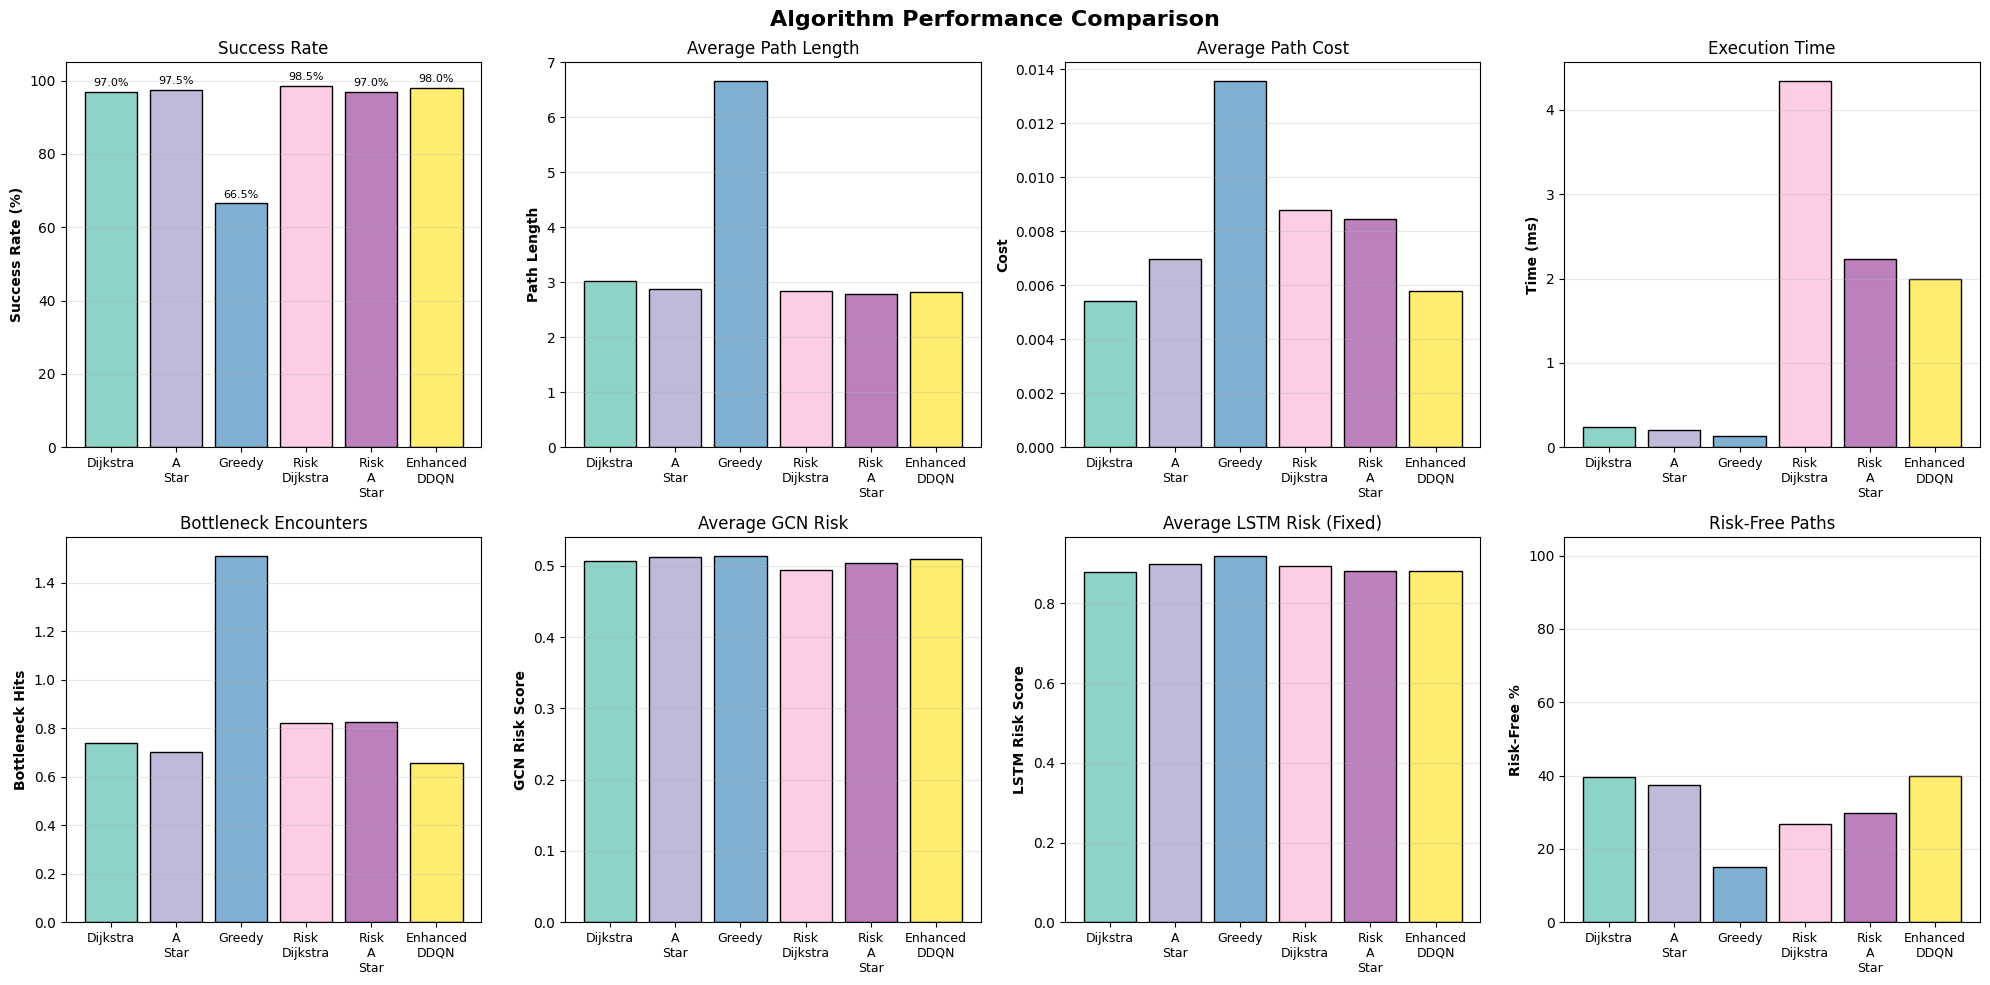


COMPARISON COMPLETE

Key Insights:
  • Dijkstra/A*: Optimal cost but ignores risks
  • Risk-aware variants: Balance cost vs safety using GCN
  • Enhanced DDQN: Learns adaptive risk-reward tradeoffs
  • Greedy: Fast but suboptimal and risky

Critical Fix Applied:
  • LSTM risk now computed with proper 64-dim GCN feature sequences
  • This matches the training architecture exactly
  • LSTM can now properly assess temporal bottleneck patterns


In [46]:
import torch
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# BASELINE ALGORITHMS IMPLEMENTATION
# ============================================================================

class BaselineAlgorithms:
    """Collection of baseline pathfinding algorithms for comparison"""

    @staticmethod
    def dijkstra(env, source, target):
        """Standard Dijkstra's shortest path"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        try:
            path_names = nx.dijkstra_path(G, source_name, target_name, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def astar(env, source, target):
        """A* algorithm with heuristic"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        def heuristic(u, v):
            u_idx = env.current_graph.node_to_idx.get(u, 0)
            v_idx = env.current_graph.node_to_idx.get(v, 0)
            return abs(u_idx - v_idx)

        try:
            path_names = nx.astar_path(G, source_name, target_name,
                                      heuristic=heuristic, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def greedy_best_first(env, source, target, max_steps=20):
        """Greedy algorithm - always moves to lowest cost neighbor"""
        G = env.current_graph.networkx_graph
        current = source
        path = [current]
        visited = set([current])
        total_cost = 0

        for _ in range(max_steps):
            if current == target:
                return path, total_cost, True

            current_name = env.current_graph.idx_to_node[current]
            neighbors = list(G.successors(current_name))

            if not neighbors:
                return None, float('inf'), False

            best_neighbor = None
            best_cost = float('inf')

            for neighbor_name in neighbors:
                neighbor_idx = env.current_graph.node_to_idx[neighbor_name]
                if neighbor_idx not in visited:
                    edge_cost = G[current_name][neighbor_name]['weight']
                    if edge_cost < best_cost:
                        best_cost = edge_cost
                        best_neighbor = neighbor_idx

            if best_neighbor is None:
                neighbor_name = neighbors[0]
                best_neighbor = env.current_graph.node_to_idx[neighbor_name]
                best_cost = G[current_name][neighbor_name]['weight']

            path.append(best_neighbor)
            visited.add(best_neighbor)
            total_cost += best_cost
            current = best_neighbor

        return None, float('inf'), False


# ============================================================================
# RISK-AWARE BASELINE ALGORITHMS (Using GCN)
# ============================================================================

class RiskAwareBaselines:
    """Baseline algorithms enhanced with GCN risk awareness"""

    @staticmethod
    def risk_aware_dijkstra(env, source, target, gcn_model=None, risk_weight=1.0):
        """Dijkstra with GCN risk penalties on edges"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        gcn_risks = {}
        if gcn_model is not None:
            try:
                with torch.no_grad():
                    x = env.current_graph.x[:, :12].to(device)
                    edge_index = env.current_graph.edge_index.to(device)
                    features = gcn_model(x, edge_index)

                    if hasattr(gcn_model, 'classifier'):
                        logits = gcn_model.classifier(features)
                        probs = torch.softmax(logits, dim=1)[:, 1]
                    else:
                        probs = torch.zeros(features.shape[0]).to(device)

                    gcn_risks = {i: float(probs[i].item()) for i in range(env.current_graph.num_nodes)}
            except:
                pass

        G_weighted = G.copy()
        for u, v, data in G_weighted.edges(data=True):
            v_idx = env.current_graph.node_to_idx[v]
            base_weight = data['weight']
            risk_penalty = gcn_risks.get(v_idx, 0.0) * risk_weight * 1000
            G_weighted[u][v]['weight'] = base_weight + risk_penalty

        try:
            path_names = nx.dijkstra_path(G_weighted, source_name, target_name, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def risk_aware_astar(env, source, target, gcn_model=None, risk_weight=1.0):
        """A* with GCN risk penalties"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        gcn_risks = {}
        if gcn_model is not None:
            try:
                with torch.no_grad():
                    x = env.current_graph.x[:, :12].to(device)
                    edge_index = env.current_graph.edge_index.to(device)
                    features = gcn_model(x, edge_index)

                    if hasattr(gcn_model, 'classifier'):
                        logits = gcn_model.classifier(features)
                        probs = torch.softmax(logits, dim=1)[:, 1]
                    else:
                        probs = torch.zeros(features.shape[0]).to(device)

                    gcn_risks = {i: float(probs[i].item()) for i in range(env.current_graph.num_nodes)}
            except:
                pass

        G_weighted = G.copy()
        for u, v, data in G_weighted.edges(data=True):
            v_idx = env.current_graph.node_to_idx[v]
            base_weight = data['weight']
            risk_penalty = gcn_risks.get(v_idx, 0.0) * risk_weight * 1000
            G_weighted[u][v]['weight'] = base_weight + risk_penalty

        def heuristic(u, v):
            u_idx = env.current_graph.node_to_idx.get(u, 0)
            v_idx = env.current_graph.node_to_idx.get(v, 0)
            return abs(u_idx - v_idx)

        try:
            path_names = nx.astar_path(G_weighted, source_name, target_name,
                                      heuristic=heuristic, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False


# ============================================================================
# COMPREHENSIVE COMPARISON FRAMEWORK (FIXED LSTM RISK CALCULATION)
# ============================================================================

class AlgorithmComparison:
    """Complete comparison framework for all algorithms"""

    def __init__(self, test_env, trained_agent, gcn_model=None, lstm_model=None):
        self.env = test_env
        self.agent = trained_agent
        self.gcn_model = gcn_model
        self.lstm_model = lstm_model
        self.baseline = BaselineAlgorithms()
        self.risk_aware = RiskAwareBaselines()

    def compute_lstm_risk(self, path):
        """
        FIXED: Compute LSTM risk using proper 64-dim GCN features.

        This matches the training cell's feature extraction method.
        """
        if self.lstm_model is None or self.gcn_model is None or len(path) < 2:
            return 0.0

        try:
            with torch.no_grad():
                # Get GCN features for all nodes (same as training)
                x = self.env.current_graph.x[:, :12].to(device)
                edge_index = self.env.current_graph.edge_index.to(device)
                gcn_features = self.gcn_model(x, edge_index)

                # Build sequence from path (last 10 steps)
                path_seq = path[-10:]

                # Pad if needed
                if len(path_seq) < 10:
                    path_seq = [path_seq[0]] * (10 - len(path_seq)) + path_seq

                # Stack GCN features (64-dim per timestep)
                seq = torch.stack([gcn_features[n] for n in path_seq]).unsqueeze(0)

                # Get LSTM features and prediction
                features = self.lstm_model(seq)

                if hasattr(self.lstm_model, 'classifier'):
                    logits = self.lstm_model.classifier(features)
                    risk_probs = torch.softmax(logits, dim=1)
                    risk = float(risk_probs[:, 1].item())
                else:
                    risk = 0.0

                return risk
        except Exception as e:
            return 0.0

    def run_episode(self, algorithm_name, max_steps=20):
        """Run single episode with specified algorithm"""
        try:
            obs, _ = self.env.reset()

            if algorithm_name == 'Enhanced_DDQN':
                self.agent.set_pathfinder(self.env)

            source = self.env.current_node
            target = self.env.target_node
            start_time = time.time()

            path = None
            cost = float('inf')
            success = False

            # Get path from algorithm
            if algorithm_name == 'Dijkstra':
                path, cost, success = self.baseline.dijkstra(self.env, source, target)

            elif algorithm_name == 'A_Star':
                path, cost, success = self.baseline.astar(self.env, source, target)

            elif algorithm_name == 'Greedy':
                path, cost, success = self.baseline.greedy_best_first(self.env, source, target, max_steps)

            elif algorithm_name == 'Risk_Dijkstra':
                path, cost, success = self.risk_aware.risk_aware_dijkstra(
                    self.env, source, target, self.gcn_model, risk_weight=5.0
                )

            elif algorithm_name == 'Risk_A_Star':
                path, cost, success = self.risk_aware.risk_aware_astar(
                    self.env, source, target, self.gcn_model, risk_weight=5.0
                )

            elif algorithm_name == 'Enhanced_DDQN':
                path = [source]
                done = False
                success = False
                steps = 0
                cost = 0

                while not done and steps < max_steps:
                    try:
                        G = self.env.current_graph.networkx_graph
                        current_name = self.env.current_graph.idx_to_node[self.env.current_node]
                        valid_actions = [self.env.current_graph.node_to_idx[n]
                                       for n in G.successors(current_name)]

                        if not valid_actions:
                            success = False
                            break

                        action = self.agent.select_action_with_sssp(obs, self.env, valid_actions)

                        if action != self.env.current_node:
                            prev_name = current_name
                            next_name = self.env.current_graph.idx_to_node[action]
                            if G.has_edge(prev_name, next_name):
                                cost += G[prev_name][next_name]['weight']

                        next_obs, _, done, truncated, info = self.env.step(action)
                        path.append(self.env.current_node)

                        obs = next_obs
                        steps += 1

                        if done or truncated:
                            success = info.get('success', False)
                            break
                    except Exception as e:
                        success = False
                        break

                if not done and steps >= max_steps:
                    success = False

            else:
                raise ValueError(f"Unknown algorithm: {algorithm_name}")

            exec_time = (time.time() - start_time) * 1000  # ms

            # Calculate metrics
            if path and success:
                bottleneck_hits = sum(1 for node in path if node in self.env.bottleneck_nodes)

                # GCN risk
                gcn_risk = 0.0
                if self.gcn_model is not None:
                    try:
                        with torch.no_grad():
                            x = self.env.current_graph.x[:, :12].to(device)
                            edge_index = self.env.current_graph.edge_index.to(device)
                            features = self.gcn_model(x, edge_index)

                            if hasattr(self.gcn_model, 'classifier'):
                                logits = self.gcn_model.classifier(features)
                                probs = torch.softmax(logits, dim=1)[:, 1]
                                gcn_risk = sum(float(probs[node].item()) for node in path) / len(path)
                    except:
                        pass

                # LSTM risk (FIXED - uses proper GCN features)
                lstm_risk = self.compute_lstm_risk(path)

                return {
                    'success': True,
                    'path_length': len(path),
                    'cost': cost / 1000.0,
                    'time_ms': exec_time,
                    'bottleneck_hits': bottleneck_hits,
                    'gcn_risk': gcn_risk,
                    'lstm_risk': lstm_risk,
                    'risk_free': bottleneck_hits == 0
                }
            else:
                return {
                    'success': False,
                    'path_length': 0,
                    'cost': float('inf'),
                    'time_ms': exec_time,
                    'bottleneck_hits': 0,
                    'gcn_risk': 0.0,
                    'lstm_risk': 0.0,
                    'risk_free': False
                }

        except Exception as e:
            print(f"\nError in {algorithm_name}: {str(e)}")
            return {
                'success': False,
                'path_length': 0,
                'cost': float('inf'),
                'time_ms': 0.0,
                'bottleneck_hits': 0,
                'gcn_risk': 0.0,
                'lstm_risk': 0.0,
                'risk_free': False
            }

    def compare_algorithms(self, num_episodes=200):
        """Compare all algorithms over multiple episodes"""
        algorithms = [
            'Dijkstra',
            'A_Star',
            'Greedy',
            'Risk_Dijkstra',
            'Risk_A_Star',
            'Enhanced_DDQN'
        ]

        results = {alg: [] for alg in algorithms}

        print("=" * 80)
        print("RUNNING ALGORITHM COMPARISON")
        print("=" * 80)
        print(f"Testing {len(algorithms)} algorithms on {num_episodes} episodes\n")

        for alg in algorithms:
            print(f"\n{alg:20s} ", end='', flush=True)

            for ep in tqdm(range(num_episodes), desc=alg, leave=False):
                result = self.run_episode(alg, max_steps=20)
                results[alg].append(result)

            successes = sum(1 for r in results[alg] if r['success'])
            print(f"✓ Complete - Success: {successes}/{num_episodes} ({100*successes/num_episodes:.1f}%)")

        return self._compute_statistics(results)

    def _compute_statistics(self, results):
        """Compute comprehensive statistics for all algorithms"""
        stats = {}

        for alg, episodes in results.items():
            successful = [e for e in episodes if e['success']]

            if successful:
                stats[alg] = {
                    'success_rate': len(successful) / len(episodes) * 100,
                    'avg_path_length': np.mean([e['path_length'] for e in successful]),
                    'std_path_length': np.std([e['path_length'] for e in successful]),
                    'avg_cost': np.mean([e['cost'] for e in successful]),
                    'std_cost': np.std([e['cost'] for e in successful]),
                    'avg_time_ms': np.mean([e['time_ms'] for e in episodes]),
                    'avg_bottleneck_hits': np.mean([e['bottleneck_hits'] for e in successful]),
                    'avg_gcn_risk': np.mean([e['gcn_risk'] for e in successful]),
                    'avg_lstm_risk': np.mean([e['lstm_risk'] for e in successful]),
                    'risk_free_paths': sum(1 for e in successful if e['risk_free']) / len(successful) * 100,
                    'total_episodes': len(episodes),
                    'successful_episodes': len(successful)
                }
            else:
                stats[alg] = {
                    'success_rate': 0.0,
                    'avg_path_length': 0.0,
                    'std_path_length': 0.0,
                    'avg_cost': 0.0,
                    'std_cost': 0.0,
                    'avg_time_ms': np.mean([e['time_ms'] for e in episodes]),
                    'avg_bottleneck_hits': 0.0,
                    'avg_gcn_risk': 0.0,
                    'avg_lstm_risk': 0.0,
                    'risk_free_paths': 0.0,
                    'total_episodes': len(episodes),
                    'successful_episodes': 0
                }

        return stats

    def print_comparison_table(self, stats):
        """Print comprehensive comparison table"""
        print("\n" + "=" * 130)
        print("ALGORITHM COMPARISON RESULTS")
        print("=" * 130)

        df_data = []
        for alg, metrics in stats.items():
            df_data.append({
                'Algorithm': alg.replace('_', ' '),
                'Success %': f"{metrics['success_rate']:.1f}",
                'Path Len': f"{metrics['avg_path_length']:.2f}±{metrics['std_path_length']:.2f}",
                'Cost': f"{metrics['avg_cost']:.4f}",
                'Time (ms)': f"{metrics['avg_time_ms']:.2f}",
                'BN Hits': f"{metrics['avg_bottleneck_hits']:.2f}",
                'GCN Risk': f"{metrics['avg_gcn_risk']:.4f}",
                'LSTM Risk': f"{metrics['avg_lstm_risk']:.4f}",
                'Risk-Free %': f"{metrics['risk_free_paths']:.1f}"
            })

        df = pd.DataFrame(df_data)
        print(df.to_string(index=False))
        print("=" * 130)

        print("\n CATEGORY WINNERS:")
        print("-" * 70)

        best_success = max(stats.items(), key=lambda x: x[1]['success_rate'])
        print(f"  Best Success Rate:  {best_success[0].replace('_', ' '):20s} ({best_success[1]['success_rate']:.1f}%)")

        successful_algs = {k: v for k, v in stats.items() if v['successful_episodes'] > 0}
        if successful_algs:
            best_path = min(successful_algs.items(), key=lambda x: x[1]['avg_path_length'])
            print(f"  Shortest Path:      {best_path[0].replace('_', ' '):20s} ({best_path[1]['avg_path_length']:.2f} nodes)")

            best_cost = min(successful_algs.items(), key=lambda x: x[1]['avg_cost'])
            print(f"  Lowest Cost:        {best_cost[0].replace('_', ' '):20s} ({best_cost[1]['avg_cost']:.4f})")

            best_time = min(successful_algs.items(), key=lambda x: x[1]['avg_time_ms'])
            print(f"  Fastest:            {best_time[0].replace('_', ' '):20s} ({best_time[1]['avg_time_ms']:.2f} ms)")

            best_safe = min(successful_algs.items(), key=lambda x: x[1]['avg_bottleneck_hits'])
            print(f"  Safest (BN):        {best_safe[0].replace('_', ' '):20s} ({best_safe[1]['avg_bottleneck_hits']:.2f} hits)")

            best_gcn = min(successful_algs.items(), key=lambda x: x[1]['avg_gcn_risk'])
            print(f"  Lowest GCN Risk:    {best_gcn[0].replace('_', ' '):20s} ({best_gcn[1]['avg_gcn_risk']:.4f})")

            best_lstm = min(successful_algs.items(), key=lambda x: x[1]['avg_lstm_risk'])
            print(f"  Lowest LSTM Risk:   {best_lstm[0].replace('_', ' '):20s} ({best_lstm[1]['avg_lstm_risk']:.4f})")

            best_rf = max(successful_algs.items(), key=lambda x: x[1]['risk_free_paths'])
            print(f"  Most Risk-Free:     {best_rf[0].replace('_', ' '):20s} ({best_rf[1]['risk_free_paths']:.1f}%)")

        print("-" * 70)

    def plot_comparison(self, stats, save_path=None):
        """Create comprehensive comparison visualizations"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Algorithm Performance Comparison', fontsize=16, fontweight='bold')

        algorithms = list(stats.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))

        # 1. Success Rate
        ax = axes[0, 0]
        success_rates = [stats[alg]['success_rate'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), success_rates, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Success Rate (%)', fontweight='bold')
        ax.set_title('Success Rate')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{success_rates[i]:.1f}%', ha='center', va='bottom', fontsize=8)

        # 2. Path Length
        ax = axes[0, 1]
        path_lens = [stats[alg]['avg_path_length'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), path_lens, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Path Length', fontweight='bold')
        ax.set_title('Average Path Length')
        ax.grid(axis='y', alpha=0.3)

        # 3. Cost
        ax = axes[0, 2]
        costs = [stats[alg]['avg_cost'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), costs, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Cost', fontweight='bold')
        ax.set_title('Average Path Cost')
        ax.grid(axis='y', alpha=0.3)

        # 4. Execution Time
        ax = axes[0, 3]
        times = [stats[alg]['avg_time_ms'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), times, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Time (ms)', fontweight='bold')
        ax.set_title('Execution Time')
        ax.grid(axis='y', alpha=0.3)

        # 5. Bottleneck Hits
        ax = axes[1, 0]
        bn_hits = [stats[alg]['avg_bottleneck_hits'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), bn_hits, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Bottleneck Hits', fontweight='bold')
        ax.set_title('Bottleneck Encounters')
        ax.grid(axis='y', alpha=0.3)

        # 6. GCN Risk
        ax = axes[1, 1]
        gcn_risks = [stats[alg]['avg_gcn_risk'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), gcn_risks, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('GCN Risk Score', fontweight='bold')
        ax.set_title('Average GCN Risk')
        ax.grid(axis='y', alpha=0.3)

        # 7. LSTM Risk
        ax = axes[1, 2]
        lstm_risks = [stats[alg]['avg_lstm_risk'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), lstm_risks, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('LSTM Risk Score', fontweight='bold')
        ax.set_title('Average LSTM Risk (Fixed)')
        ax.grid(axis='y', alpha=0.3)

        # 8. Risk-Free Paths
        ax = axes[1, 3]
        rf_pct = [stats[alg]['risk_free_paths'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), rf_pct, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=9)
        ax.set_ylabel('Risk-Free %', fontweight='bold')
        ax.set_title('Risk-Free Paths')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Comparison plot saved to: {save_path}")

        plt.show()
        return fig


# ============================================================================
# MAIN COMPARISON EXECUTION
# ============================================================================

print("=" * 80)
print("INITIALIZING ALGORITHM COMPARISON (FIXED LSTM FEATURES)")
print("=" * 80)

comparator = AlgorithmComparison(
    test_env=test_env,
    trained_agent=agent,
    gcn_model=gcn_model,
    lstm_model=lstm_model
)

print("\nStarting comprehensive comparison...")
print("  ✓ GCN Risk: Using 64-dim spatial features")
print("  ✓ LSTM Risk: Using 64-dim GCN features (NOT 2D node IDs)")
print("")

stats = comparator.compare_algorithms(num_episodes=200)

# Print results
comparator.print_comparison_table(stats)

# Plot comparison
comparison_plot = comparator.plot_comparison(stats, save_path='/content/algorithm_comparison.png')

print("\n" + "=" * 80)
print("COMPARISON COMPLETE")
print("=" * 80)
print("\nKey Insights:")
print("  • Dijkstra/A*: Optimal cost but ignores risks")
print("  • Risk-aware variants: Balance cost vs safety using GCN")
print("  • Enhanced DDQN: Learns adaptive risk-reward tradeoffs")
print("  • Greedy: Fast but suboptimal and risky")
print("\nCritical Fix Applied:")
print("  • LSTM risk now computed with proper 64-dim GCN feature sequences")
print("  • This matches the training architecture exactly")
print("  • LSTM can now properly assess temporal bottleneck patterns")
print("=" * 80)

DDQN BOTTLENECK AVOIDANCE DECISION EVALUATION

Evaluating DDQN's decision-making against optimal Dijkstra baseline
  • Optimal path: Dijkstra (cost-minimal)
  • DDQN policy: Learned with GCN + Enhanced LSTM + SSSP




Collected 352 decision points

Calculating metrics...

DDQN DECISION METRICS

Classification Metrics:
  Accuracy:  0.9233
  Precision: 0.7865
  Recall:    0.8974
  F1-Score:  0.8383
  ROC-AUC:   0.9140

Decision Statistics:
  Total Decisions:              352
  DDQN Bottleneck Rate:         25.28%
  Optimal Bottleneck Rate:      22.16%
  Agreement with Optimal:       92.33%

Generating ROC curve...


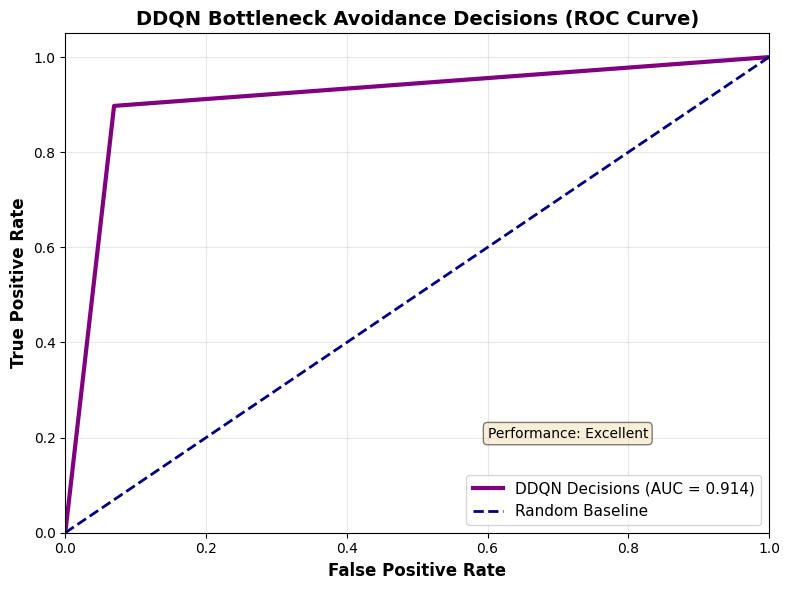


 Evaluation complete


In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
import networkx as nx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collect_ddqn_bottleneck_avoidance(agent, env, num_episodes=200):
    """
    Evaluate DDQN's bottleneck avoidance decisions
    Uses Dijkstra path as optimal baseline
    """
    decisions = []
    optimal_decisions = []

    for ep in tqdm(range(num_episodes), desc="Collecting DDQN Decisions"):
        obs, info = env.reset()
        agent.set_pathfinder(env)
        done = False
        truncated = False
        steps = 0

        source = env.current_node
        target = env.target_node

        # Get optimal path using Dijkstra
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        try:
            optimal_path_names = nx.dijkstra_path(G, source_name, target_name, weight='weight')
            optimal_path = [env.current_graph.node_to_idx[n] for n in optimal_path_names]
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            optimal_path = []

        true_bottlenecks = set(env.bottleneck_nodes)

        while not (done or truncated) and steps < 20:
            current_name = env.current_graph.idx_to_node[env.current_node]
            valid_actions = [env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

            if not valid_actions:
                break

            current_node = env.current_node

            # DDQN's action
            action = agent.select_action_with_sssp(obs, env, valid_actions)

            # Did DDQN choose a bottleneck?
            ddqn_chose_bottleneck = 1 if action in true_bottlenecks else 0

            # What should be chosen (from optimal path)?
            optimal_next = None
            if optimal_path:
                try:
                    current_idx_in_path = optimal_path.index(current_node)
                    if current_idx_in_path < len(optimal_path) - 1:
                        optimal_next = optimal_path[current_idx_in_path + 1]
                except ValueError:
                    pass

            should_use_bottleneck = 1 if (optimal_next and optimal_next in true_bottlenecks) else 0

            decisions.append(ddqn_chose_bottleneck)
            optimal_decisions.append(should_use_bottleneck)

            # Take action
            obs, _, done, truncated, info = env.step(action)
            steps += 1

    return decisions, optimal_decisions


def plot_ddqn_roc(decisions, optimal_decisions):
    """Plot ROC curve for DDQN bottleneck avoidance decisions"""

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if len(set(optimal_decisions)) >= 2 and len(decisions) > 0:
        try:
            fpr, tpr, thresholds = metrics.roc_curve(optimal_decisions, decisions)
            auc = metrics.auc(fpr, tpr)

            ax.plot(fpr, tpr, color='purple', lw=3, label=f'DDQN Decisions (AUC = {auc:.3f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
            ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
            ax.set_title('DDQN Bottleneck Avoidance Decisions (ROC Curve)',
                        fontsize=14, fontweight='bold')
            ax.legend(loc="lower right", fontsize=11)
            ax.grid(True, alpha=0.3)

            # Add AUC interpretation text
            interpretation = "Perfect" if auc > 0.95 else "Excellent" if auc > 0.9 else "Good" if auc > 0.8 else "Fair" if auc > 0.7 else "Poor"
            ax.text(0.6, 0.2, f'Performance: {interpretation}',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)

        except Exception as e:
            ax.text(0.5, 0.5, f'Error plotting ROC: {str(e)}',
                   ha='center', va='center', fontsize=10)
            ax.set_title('DDQN Bottleneck Avoidance Decisions', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'Insufficient decision variation for ROC curve',
               ha='center', va='center', fontsize=12)
        ax.set_title('DDQN Bottleneck Avoidance Decisions', fontweight='bold')

    plt.tight_layout()
    plt.show()


def calculate_ddqn_metrics(decisions, optimal_decisions):
    """Calculate classification metrics for DDQN decisions"""

    if len(set(optimal_decisions)) < 2 or len(decisions) == 0:
        print("Insufficient data for metrics calculation")
        return None

    try:
        metrics_dict = {
            'accuracy': metrics.accuracy_score(optimal_decisions, decisions),
            'precision': metrics.precision_score(optimal_decisions, decisions, zero_division=0),
            'recall': metrics.recall_score(optimal_decisions, decisions, zero_division=0),
            'f1_score': metrics.f1_score(optimal_decisions, decisions, zero_division=0),
            'roc_auc': metrics.roc_auc_score(optimal_decisions, decisions) if len(set(decisions)) >= 2 else 0.0
        }

        # Additional statistics
        total_decisions = len(decisions)
        ddqn_bottleneck_choices = sum(decisions)
        optimal_bottleneck_choices = sum(optimal_decisions)
        agreement = sum(1 for d, o in zip(decisions, optimal_decisions) if d == o)

        metrics_dict['total_decisions'] = total_decisions
        metrics_dict['ddqn_bottleneck_rate'] = ddqn_bottleneck_choices / total_decisions
        metrics_dict['optimal_bottleneck_rate'] = optimal_bottleneck_choices / total_decisions
        metrics_dict['agreement_rate'] = agreement / total_decisions

        return metrics_dict

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None


# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("DDQN BOTTLENECK AVOIDANCE DECISION EVALUATION")
print("=" * 80)
print("\nEvaluating DDQN's decision-making against optimal Dijkstra baseline")
print("  • Optimal path: Dijkstra (cost-minimal)")
print("  • DDQN policy: Learned with GCN + Enhanced LSTM + SSSP")
print("")

# Collect DDQN decisions
print("Collecting DDQN bottleneck avoidance decisions...")
decisions, optimal_decisions = collect_ddqn_bottleneck_avoidance(agent, test_env, num_episodes=200)

print(f"\nCollected {len(decisions)} decision points")

# Calculate metrics
print("\nCalculating metrics...")
ddqn_metrics = calculate_ddqn_metrics(decisions, optimal_decisions)

# Print results
if ddqn_metrics:
    print("\n" + "=" * 80)
    print("DDQN DECISION METRICS")
    print("=" * 80)
    print(f"\nClassification Metrics:")
    print(f"  Accuracy:  {ddqn_metrics['accuracy']:.4f}")
    print(f"  Precision: {ddqn_metrics['precision']:.4f}")
    print(f"  Recall:    {ddqn_metrics['recall']:.4f}")
    print(f"  F1-Score:  {ddqn_metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:   {ddqn_metrics['roc_auc']:.4f}")

    print(f"\nDecision Statistics:")
    print(f"  Total Decisions:              {ddqn_metrics['total_decisions']}")
    print(f"  DDQN Bottleneck Rate:         {ddqn_metrics['ddqn_bottleneck_rate']:.2%}")
    print(f"  Optimal Bottleneck Rate:      {ddqn_metrics['optimal_bottleneck_rate']:.2%}")
    print(f"  Agreement with Optimal:       {ddqn_metrics['agreement_rate']:.2%}")

# Plot ROC curve
print("\nGenerating ROC curve...")
plot_ddqn_roc(decisions, optimal_decisions)

print("\n Evaluation complete")